In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import xgboost as xgb
import sklearn.metrics as mtr
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import pytz

# Exploração e Tratamento dos dados

In [9]:
df = pd.read_csv('dados_floripa.csv')
df

C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\2996573664.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dados_floripa.csv')


,DataIni,HoraIni,DataFim,HoraFim,Sentido,Linha,NoVeículo,DuraçãoViagem,TotalGiros,KmPerc
0,2019-04-14,02:29:00,2019-04-14,02:30:00,Ida,100,271,00:01:00,0,0.000
1,2019-04-14,03:30:00,2019-04-14,03:30:00,Ida,100,271,00:00:00,0,0.000
2,2019-04-13,01:28:00,2019-04-13,01:28:00,Ida,100,276,00:00:00,0,0.000
3,2019-04-12,03:28:00,2019-04-12,03:28:00,Ida,100,279,00:00:00,0,0.000
4,2019-04-07,00:31:00,2019-04-07,00:31:00,Ida,100,273,00:00:00,0,0.000
...,...,...,...,...,...,...,...,...,...,...
2694355,2019-10-01,04:00:00,2019-10-01,04:34:00,Volta,477,50404,00:34:00,5,17.294
2694356,2019-10-01,04:29:00,2019-10-01,05:12:00,Volta,477,50359,00:43:00,7,17.294
2694357,2019-10-01,05:15:00,2019-10-01,05:47:00,Volta,477,50404,00:32:00,7,17.294
2694358,2019-10-01,05:47:00,2019-10-01,05:47:00,Volta,477,50404,00:00:00,0,17.294


In [10]:
# Checar o tipos dos dados
df.dtypes

DataIni           object
HoraIni           object
DataFim           object
HoraFim           object
Sentido           object
Linha             object
NoVeículo         object
DuraçãoViagem     object
TotalGiros         int64
KmPerc           float64
dtype: object

In [11]:
# Checkup geral das colunas
# Podemos ver num primeiro momento que:
# Sentido está de certa forma balanceado no geral, verificar se para todas as rotas também está próximo
# Existem 229 linhas que podem ser trabalhadas (objeto do estudo)
# Existem 1295 veículos, pode existir alguma relação do veículo com a eficiência/velocidade da rota, porém como não sabemos quem dirige o ônibus ou informações do mesmo como estado de manutenção e etc, provavelmente será um dado descartado
# Algumas rotas estão com KmPerc zerados, podem ser falhas de medição e serão descartados
# Algumas rotas estão com o tempo de viagem zerados, podem ser falhas de medição e serão descartados
# TotalGiros são o número de pessoas que passaram pela roleta podem influenciar na DuraçãoViagem das rotas, algumas estão zeradas podendo ser falha de medição
for colum in df:
    print(f'{df[colum].describe()}\n--------------------------')

count        2694360
unique           366
top       2019-10-25
freq            9276
Name: DataIni, dtype: object
--------------------------
count      2694360
unique        1440
top       07:00:00
freq          4366
Name: HoraIni, dtype: object
--------------------------
count        2694360
unique           366
top       2019-10-25
freq            9275
Name: DataFim, dtype: object
--------------------------
count      2694360
unique        1440
top       07:15:00
freq          3969
Name: HoraFim, dtype: object
--------------------------
count     2694360
unique          2
top         Volta
freq      1394073
Name: Sentido, dtype: object
--------------------------
count     2694360
unique        230
top           410
freq        68613
Name: Linha, dtype: object
--------------------------
count     2694360
unique       1301
top         11637
freq         8487
Name: NoVeículo, dtype: int64
--------------------------
count      2694360
unique         454
top       00:21:00
freq         819

In [12]:
# Id do veículos consideramos que é um informação desnecessária, visto que não temos dados dos veículos em si como modelo, motor e etc. Assim acreditamos ser um dados desnecessário para a predição
df.drop(columns='NoVeículo',inplace=True)

In [13]:
# Unindo data e hora e removendo as antigas (Visto que as datas e horas atuais estão em colunas separadas e são objetos, queremos elas como datetimes)
df['Ini'] = pd.to_datetime(df['DataIni'] + ' ' + df['HoraIni'])
df['Fim'] = pd.to_datetime(df['DataFim'] + ' ' + df['HoraFim'])
df.drop(columns=['DataIni','HoraIni','DataFim','HoraFim'],inplace=True)

In [14]:
# Transformando a DuraçãoViagem em segundos, visto que é um objeto também
def time_to_seconds(time_str):
    hours, minutes, seconds = map(int, time_str.split(':'))
    total_seconds = (hours * 3600) + (minutes * 60) + seconds
    return total_seconds
df['DuraçãoViagem'] = df['DuraçãoViagem'].apply(time_to_seconds)
df

,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim
0,Ida,100,60,0,0.000,2019-04-14 02:29:00,2019-04-14 02:30:00
1,Ida,100,0,0,0.000,2019-04-14 03:30:00,2019-04-14 03:30:00
2,Ida,100,0,0,0.000,2019-04-13 01:28:00,2019-04-13 01:28:00
3,Ida,100,0,0,0.000,2019-04-12 03:28:00,2019-04-12 03:28:00
4,Ida,100,0,0,0.000,2019-04-07 00:31:00,2019-04-07 00:31:00
...,...,...,...,...,...,...,...
2694355,Volta,477,2040,5,17.294,2019-10-01 04:00:00,2019-10-01 04:34:00
2694356,Volta,477,2580,7,17.294,2019-10-01 04:29:00,2019-10-01 05:12:00
2694357,Volta,477,1920,7,17.294,2019-10-01 05:15:00,2019-10-01 05:47:00
2694358,Volta,477,0,0,17.294,2019-10-01 05:47:00,2019-10-01 05:47:00


In [15]:
# Removendo linhas com Duração e Distância percorridas iguais a 0
df = df.loc[(df['DuraçãoViagem'] != 0) & (df['KmPerc'] != 0)]

In [16]:
# Criando uma coluna de Velocidade para identificar outliers
df['Km/H'] = df['KmPerc']/(df['DuraçãoViagem']/3600)
# Removendo valores muito baixos e altos de velocidade
df = df.loc[(df['Km/H'] > 3) & (df['Km/H'] < 80)]
df.drop(columns='Km/H', inplace=True)
df

C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\629631639.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Km/H'] = df['KmPerc']/(df['DuraçãoViagem']/3600)


,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim
6,Volta,100,3780,3,16.308,2019-05-01 00:31:00,2019-05-01 01:34:00
7,Volta,100,3660,10,16.308,2019-05-01 01:35:00,2019-05-01 02:36:00
8,Volta,100,1800,8,16.308,2019-05-01 02:36:00,2019-05-01 03:06:00
9,Volta,100,3600,7,16.308,2019-05-01 03:30:00,2019-05-01 04:30:00
10,Volta,100,1680,7,16.308,2019-05-01 04:30:00,2019-05-01 04:58:00
...,...,...,...,...,...,...,...
2694352,Volta,477,1500,1,17.294,2019-10-01 03:30:00,2019-10-01 03:55:00
2694355,Volta,477,2040,5,17.294,2019-10-01 04:00:00,2019-10-01 04:34:00
2694356,Volta,477,2580,7,17.294,2019-10-01 04:29:00,2019-10-01 05:12:00
2694357,Volta,477,1920,7,17.294,2019-10-01 05:15:00,2019-10-01 05:47:00


In [17]:
# Criando novos atributos a partir da data
df['dia_semana'] = df['Ini'].dt.dayofweek + 1
df['hora_dia'] = df['Ini'].dt.hour
df['dia_ano'] = df['Ini'].dt.dayofyear
df['mes_ano'] = df['Ini'].dt.month
df['turno_dia'] = df['hora_dia'].apply(lambda x: 1 if x < 6 else 4 if x > 17 else 2 if (x > 5 & x < 12) else 3 if (x > 11 & x < 18) else None)

In [18]:
# Analisando e removendo Linhas que não tem observações nos 12 meses do ano
meses_linha = df.groupby('Linha')['mes_ano'].unique().reset_index(name='meses')
meses_linha['contagem'] = meses_linha['meses'].apply(lambda x: len(x))
linhas_com_12_meses = meses_linha.loc[meses_linha['contagem']==12]['Linha'].values
df = df.loc[df['Linha'].isin(linhas_com_12_meses)]
df

,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim,dia_semana,hora_dia,dia_ano,mes_ano,turno_dia
6,Volta,100,3780,3,16.308,2019-05-01 00:31:00,2019-05-01 01:34:00,3,0,121,5,1
7,Volta,100,3660,10,16.308,2019-05-01 01:35:00,2019-05-01 02:36:00,3,1,121,5,1
8,Volta,100,1800,8,16.308,2019-05-01 02:36:00,2019-05-01 03:06:00,3,2,121,5,1
9,Volta,100,3600,7,16.308,2019-05-01 03:30:00,2019-05-01 04:30:00,3,3,121,5,1
10,Volta,100,1680,7,16.308,2019-05-01 04:30:00,2019-05-01 04:58:00,3,4,121,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2694235,Volta,M940,780,0,8.622,2019-09-01 17:47:00,2019-09-01 18:00:00,7,17,244,9,2
2694236,Volta,M940,660,0,8.622,2019-09-01 18:32:00,2019-09-01 18:43:00,7,18,244,9,4
2694237,Volta,M940,660,2,8.622,2019-09-01 21:20:00,2019-09-01 21:31:00,7,21,244,9,4
2694238,Volta,M940,660,0,8.622,2019-09-01 22:15:00,2019-09-01 22:26:00,7,22,244,9,4


In [19]:
# Analisando se alguma rota tem uma discrepancia muito grande entre as observações em cada Mês. Resolvemos remover apenas os dois maiores desvio e a media abaixo de 20
dias_mes_linha = df.groupby(['Linha','mes_ano'])['dia_ano'].unique().reset_index(name='dias')
dias_mes_linha['contagem'] = dias_mes_linha['dias'].apply(lambda x: len(x))
dias_mes_linha_std = dias_mes_linha.groupby('Linha')['contagem'].agg(media='mean',desvio='std').reset_index()

In [20]:
# Analisando na mão os resultados acima. Resolvemos remover apenas os dois maiores desvio e a media abaixo de 20
dias_mes_linha_std.sort_values(by='desvio')

,Linha,media,desvio
0,100,30.416667,0.900337
34,164,30.416667,0.900337
35,165,30.416667,0.900337
37,168,30.416667,0.900337
77,270,30.416667,0.900337
...,...,...,...
8,1120,26.166667,2.124889
10,1122,26.333333,2.188122
9,1121,26.333333,2.188122
134,601V,20.000000,3.567530


In [21]:
# Analisando na mão os resultados acima. Resolvemos remover apenas os dois maiores desvio e a media abaixo de 20
dias_mes_linha.loc[dias_mes_linha['Linha']=='601V']

,Linha,mes_ano,dias,contagem
1608,601V,1,"[31, 30, 29, 28, 25, 24, 23, 22, 21, 18, 17, 1...",22
1609,601V,2,"[59, 58, 57, 56, 53, 52, 51, 50, 49, 46, 45, 4...",20
1610,601V,3,"[88, 87, 86, 85, 84, 67, 66, 65, 63, 60]",10
1611,601V,4,"[120, 119, 116, 115, 114, 113, 112, 108, 107, ...",21
1612,601V,5,"[151, 150, 149, 148, 147, 144, 143, 142, 141, ...",22
1613,601V,6,"[179, 178, 177, 176, 175, 172, 170, 169, 168, ...",18
1614,601V,7,"[212, 211, 210, 207, 206, 205, 204, 203, 200, ...",23
1615,601V,8,"[242, 241, 240, 239, 238, 235, 234, 233, 232, ...",22
1616,601V,9,"[273, 270, 269, 268, 267, 266, 263, 262, 261, ...",21
1617,601V,10,"[304, 303, 302, 301, 298, 297, 296, 295, 294, ...",23


In [22]:
# Removendo as linhas com maior desvio padrão entre os meses
df = df.loc[~df['Linha'].isin(['601V','296','500V'])]
df

,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim,dia_semana,hora_dia,dia_ano,mes_ano,turno_dia
6,Volta,100,3780,3,16.308,2019-05-01 00:31:00,2019-05-01 01:34:00,3,0,121,5,1
7,Volta,100,3660,10,16.308,2019-05-01 01:35:00,2019-05-01 02:36:00,3,1,121,5,1
8,Volta,100,1800,8,16.308,2019-05-01 02:36:00,2019-05-01 03:06:00,3,2,121,5,1
9,Volta,100,3600,7,16.308,2019-05-01 03:30:00,2019-05-01 04:30:00,3,3,121,5,1
10,Volta,100,1680,7,16.308,2019-05-01 04:30:00,2019-05-01 04:58:00,3,4,121,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2694235,Volta,M940,780,0,8.622,2019-09-01 17:47:00,2019-09-01 18:00:00,7,17,244,9,2
2694236,Volta,M940,660,0,8.622,2019-09-01 18:32:00,2019-09-01 18:43:00,7,18,244,9,4
2694237,Volta,M940,660,2,8.622,2019-09-01 21:20:00,2019-09-01 21:31:00,7,21,244,9,4
2694238,Volta,M940,660,0,8.622,2019-09-01 22:15:00,2019-09-01 22:26:00,7,22,244,9,4


count      185.000000
mean     13839.216216
std      13599.364304
min        247.000000
25%       3990.000000
50%      10699.000000
75%      16809.000000
max      67327.000000
Name: Sentido, dtype: float64


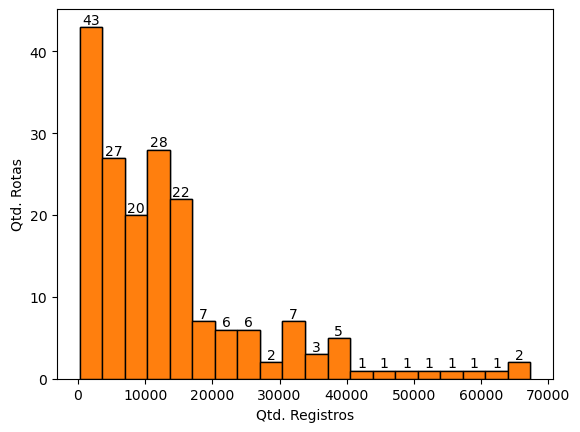

In [23]:
# Verificando a quantidade de rotas em cada Linha para removermos linhas com poucas observações ou muitas observações
qtd_rotas_p_linha = pd.DataFrame(df.groupby('Linha')['Sentido'].count())
print(qtd_rotas_p_linha['Sentido'].describe())
# Plotar o histograma
plt.hist(qtd_rotas_p_linha['Sentido'], bins=20, edgecolor='black')  # 'data' são os dados, 'bins' é o número de intervalos
# Adicionar rótulos com o número de itens em cada bin
hist, bins, _ = plt.hist(qtd_rotas_p_linha['Sentido'], bins=20, edgecolor='black')
for i in range(len(hist)):
    plt.text(bins[i] + (bins[i + 1] - bins[i]) / 2, hist[i], str(int(hist[i])),ha='center', va='bottom')
plt.xlabel('Qtd. Registros')  # Rótulo do eixo x
plt.ylabel('Qtd. Rotas')  # Rótulo do eixo y
# Exibir o histograma
plt.show()

In [24]:
# Removendo as linhas com quantidade de rotas fora do primeiro e terceiro quartil
rotas_entre_primeiro_terceiro_qaurtil = qtd_rotas_p_linha.loc[(qtd_rotas_p_linha['Sentido'] > 3900)&(qtd_rotas_p_linha['Sentido']<16900)].index.values
df = df.loc[df['Linha'].isin(rotas_entre_primeiro_terceiro_qaurtil)]
df

,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim,dia_semana,hora_dia,dia_ano,mes_ano,turno_dia
179,Volta,101,1320,2,5.418,2019-04-30 06:30:00,2019-04-30 06:52:00,2,6,120,4,2
180,Volta,101,1200,12,5.418,2019-04-30 07:10:00,2019-04-30 07:30:00,2,7,120,4,2
181,Volta,101,1200,4,5.418,2019-04-30 07:50:00,2019-04-30 08:10:00,2,7,120,4,2
182,Volta,101,2340,10,5.418,2019-04-30 08:25:00,2019-04-30 09:04:00,2,8,120,4,2
183,Volta,101,1440,3,5.418,2019-04-30 09:30:00,2019-04-30 09:54:00,2,9,120,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2694235,Volta,M940,780,0,8.622,2019-09-01 17:47:00,2019-09-01 18:00:00,7,17,244,9,2
2694236,Volta,M940,660,0,8.622,2019-09-01 18:32:00,2019-09-01 18:43:00,7,18,244,9,4
2694237,Volta,M940,660,2,8.622,2019-09-01 21:20:00,2019-09-01 21:31:00,7,21,244,9,4
2694238,Volta,M940,660,0,8.622,2019-09-01 22:15:00,2019-09-01 22:26:00,7,22,244,9,4


In [25]:
# Analisando se a quantidade de idas e voltas de cada linha está Ok. Concluimos que está ok e não removemos nenhum linha
ida_voltas_linhas = df.groupby('Linha')['Sentido'].value_counts().unstack(fill_value=0)
ida_voltas_linhas['Diferenca'] = ida_voltas_linhas['Ida'] - ida_voltas_linhas['Volta']
ida_voltas_linhas.sort_values(by='Diferenca')

Sentido,Ida,Volta,Diferenca
Linha,,,
138,0,16346,-16346
136,0,16296,-16296
137,0,15949,-15949
135,0,15936,-15936
772,0,10950,-10950
...,...,...,...
274,2790,2202,588
281,8657,7953,704
330V,6235,5511,724


In [26]:
# Fazendo um encoding da coluna Sentido, pois o modelo XGB não aceita informações categoricas.
df['Sentido'] = df['Sentido'].map({'Ida': 0, 'Volta': 1})

C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\2206277558.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentido'] = df['Sentido'].map({'Ida': 0, 'Volta': 1})


In [27]:
# Analisando número de Giros por linhas. Tem valores estranhos e que não fazem sentido, porém de decidimos deixar para rodar nos modelos, retimos apenas a linha 110 que estava toda zerada
df.groupby(['Linha'])['TotalGiros'].mean().reset_index().sort_values(by='TotalGiros')

,Linha,TotalGiros
2,110,0.003722
58,362,4.119939
40,180,4.325447
38,178,5.977037
91,943,6.096262
...,...,...
17,136,44.577320
54,294,46.153422
19,138,48.245626
16,135,50.508471


In [28]:
df_mean = df.copy()
df_mean["data"] = df_mean["Ini"].dt.date
df_mean = df_mean.groupby(["Linha", "data", "hora_dia"], as_index=False).agg({"TotalGiros": "mean"}).reset_index(drop=True)
df_mean.rename({"TotalGiros": "TotalGirosMean"}, axis=1, inplace=True)
df_mean

,Linha,data,hora_dia,TotalGirosMean
0,101,2018-11-01,6,5.0
1,101,2018-11-01,7,7.0
2,101,2018-11-01,8,6.0
3,101,2018-11-01,9,7.0
4,101,2018-11-01,10,1.0
...,...,...,...,...
440175,M940,2019-10-31,19,8.0
440176,M940,2019-10-31,20,4.5
440177,M940,2019-10-31,21,2.5
440178,M940,2019-10-31,22,4.0


In [29]:
df["d-1"] = df["Ini"].dt.date - pd.Timedelta(days=1)
df = pd.merge(left=df, right=df_mean, left_on=["Linha", "d-1", "hora_dia"], right_on=["Linha", "data", "hora_dia"])
df.drop(["d-1", "data"], axis=1, inplace=True)
df

C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\4244930809.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["d-1"] = df["Ini"].dt.date - pd.Timedelta(days=1)


,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim,dia_semana,hora_dia,dia_ano,mes_ano,turno_dia,TotalGirosMean
0,1,101,1320,2,5.418,2019-04-30 06:30:00,2019-04-30 06:52:00,2,6,120,4,2,3.000000
1,1,101,1200,12,5.418,2019-04-30 07:10:00,2019-04-30 07:30:00,2,7,120,4,2,7.000000
2,1,101,1200,4,5.418,2019-04-30 07:50:00,2019-04-30 08:10:00,2,7,120,4,2,7.000000
3,1,101,2340,10,5.418,2019-04-30 08:25:00,2019-04-30 09:04:00,2,8,120,4,2,7.000000
4,1,101,1440,3,5.418,2019-04-30 09:30:00,2019-04-30 09:54:00,2,9,120,4,2,7.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
835345,1,M940,2280,10,8.622,2019-09-29 05:24:00,2019-09-29 06:02:00,7,5,272,9,1,12.000000
835346,1,M940,1020,0,8.622,2019-09-28 10:59:00,2019-09-28 11:16:00,6,10,271,9,2,12.000000
835347,1,M940,1080,2,8.622,2019-09-22 16:59:00,2019-09-22 17:17:00,7,16,265,9,2,3.666667
835348,1,M940,2700,18,8.622,2019-09-16 13:17:00,2019-09-16 14:02:00,1,13,259,9,2,4.000000


In [30]:
# Olhando na mão linha a linha
df.loc[df['Linha']=='110']#.groupby('turno_dia').size()

,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim,dia_semana,hora_dia,dia_ano,mes_ano,turno_dia,TotalGirosMean
710,0,110,1140,0,7.629,2019-04-30 08:34:00,2019-04-30 08:53:00,2,8,120,4,2,0.0
711,0,110,1680,0,7.629,2019-04-30 08:04:00,2019-04-30 08:32:00,2,8,120,4,2,0.0
712,1,110,1080,0,7.713,2019-04-30 08:16:00,2019-04-30 08:34:00,2,8,120,4,2,0.0
713,1,110,1080,0,7.713,2019-04-30 08:32:00,2019-04-30 08:50:00,2,8,120,4,2,0.0
714,0,110,1200,0,7.629,2019-04-30 12:25:00,2019-04-30 12:45:00,2,12,120,4,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
768798,1,110,2040,0,7.713,2019-09-05 19:13:00,2019-09-05 19:47:00,4,19,248,9,4,0.0
768799,1,110,900,0,7.713,2019-09-04 19:08:00,2019-09-04 19:23:00,3,19,247,9,4,0.0
768800,1,110,1740,0,7.713,2019-09-04 19:12:00,2019-09-04 19:41:00,3,19,247,9,4,0.0
768801,1,110,1020,0,7.713,2019-09-03 19:04:00,2019-09-03 19:21:00,2,19,246,9,4,0.0


In [31]:
# Remoção da linha 110
df = df.loc[df['Linha'] != '110']
df

,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim,dia_semana,hora_dia,dia_ano,mes_ano,turno_dia,TotalGirosMean
0,1,101,1320,2,5.418,2019-04-30 06:30:00,2019-04-30 06:52:00,2,6,120,4,2,3.000000
1,1,101,1200,12,5.418,2019-04-30 07:10:00,2019-04-30 07:30:00,2,7,120,4,2,7.000000
2,1,101,1200,4,5.418,2019-04-30 07:50:00,2019-04-30 08:10:00,2,7,120,4,2,7.000000
3,1,101,2340,10,5.418,2019-04-30 08:25:00,2019-04-30 09:04:00,2,8,120,4,2,7.000000
4,1,101,1440,3,5.418,2019-04-30 09:30:00,2019-04-30 09:54:00,2,9,120,4,2,7.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
835345,1,M940,2280,10,8.622,2019-09-29 05:24:00,2019-09-29 06:02:00,7,5,272,9,1,12.000000
835346,1,M940,1020,0,8.622,2019-09-28 10:59:00,2019-09-28 11:16:00,6,10,271,9,2,12.000000
835347,1,M940,1080,2,8.622,2019-09-22 16:59:00,2019-09-22 17:17:00,7,16,265,9,2,3.666667
835348,1,M940,2700,18,8.622,2019-09-16 13:17:00,2019-09-16 14:02:00,1,13,259,9,2,4.000000


   Linha  DuraçãoViagem
51   282     296.364647
83   769     299.876240
25   162     306.562234
57   362     315.378457
80   762     324.562481
..   ...            ...
7   1122     997.593026
16   136    1031.680272
18   138    1054.397896
85   840    1113.281266
41  2120    1121.693846

[94 rows x 2 columns]


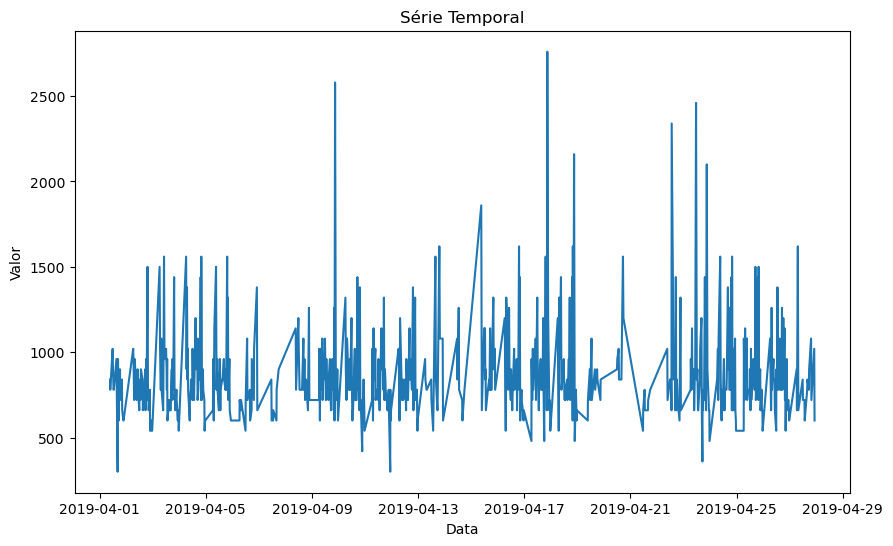

In [32]:
# Analisando o desvio padrão das durações de viagem de cada rota e plotando os valores de uma no gáfico
print(df.groupby('Linha')['DuraçãoViagem'].std().reset_index().sort_values(by='DuraçãoViagem'))
df_plot = df.loc[df['Linha'] == '362'][['Ini','DuraçãoViagem']].sort_values(by='Ini')
df_plot = df_plot[(df_plot["Ini"] > "2019-04-01") & (df_plot["Ini"] < "2019-04-28")]
df_plot.set_index('Ini', inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(df_plot.index, df_plot['DuraçãoViagem'])
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Série Temporal')
plt.show()

In [33]:
#Remoção dos outliers de cada Linha
# IQR Method (Interquartile Range):
def remove_outlier(valores):
    Q1 = np.percentile(valores,25)
    Q3 = np.percentile(valores,75)
    intervalo = Q3-Q1
    limite_superior = Q3+intervalo*1.5
    limite_inferior = Q1-intervalo*1.5
    return limite_superior,limite_inferior

linhas = df['Linha'].unique()
outliers_indexs = []
for linha in linhas:
    aux = df.loc[df['Linha'] == linha]['DuraçãoViagem']
    limite_superior,limite_inferior = remove_outlier(aux)
    aux = aux.loc[(aux.values > limite_superior) | (aux.values < limite_inferior)]
    outliers_indexs.extend(aux.index)
df.drop(outliers_indexs,inplace=True)
df.reset_index(drop=True,inplace=True)
df

C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\2474428967.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(outliers_indexs,inplace=True)


,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim,dia_semana,hora_dia,dia_ano,mes_ano,turno_dia,TotalGirosMean
0,1,101,1320,2,5.418,2019-04-30 06:30:00,2019-04-30 06:52:00,2,6,120,4,2,3.000000
1,1,101,1200,12,5.418,2019-04-30 07:10:00,2019-04-30 07:30:00,2,7,120,4,2,7.000000
2,1,101,1200,4,5.418,2019-04-30 07:50:00,2019-04-30 08:10:00,2,7,120,4,2,7.000000
3,1,101,2340,10,5.418,2019-04-30 08:25:00,2019-04-30 09:04:00,2,8,120,4,2,7.000000
4,1,101,1440,3,5.418,2019-04-30 09:30:00,2019-04-30 09:54:00,2,9,120,4,2,7.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
797202,1,M940,2280,10,8.622,2019-09-29 05:24:00,2019-09-29 06:02:00,7,5,272,9,1,12.000000
797203,1,M940,1020,0,8.622,2019-09-28 10:59:00,2019-09-28 11:16:00,6,10,271,9,2,12.000000
797204,1,M940,1080,2,8.622,2019-09-22 16:59:00,2019-09-22 17:17:00,7,16,265,9,2,3.666667
797205,1,M940,2700,18,8.622,2019-09-16 13:17:00,2019-09-16 14:02:00,1,13,259,9,2,4.000000


   Linha  DuraçãoViagem
0    362     178.799001
1    162     200.062211
2    271     200.500940
3    169     203.888001
4    168     211.184265
..   ...            ...
89   136     768.143369
90   135     788.268836
91   138     808.558630
92   235     848.243518
93  4122     864.089809

[94 rows x 2 columns]


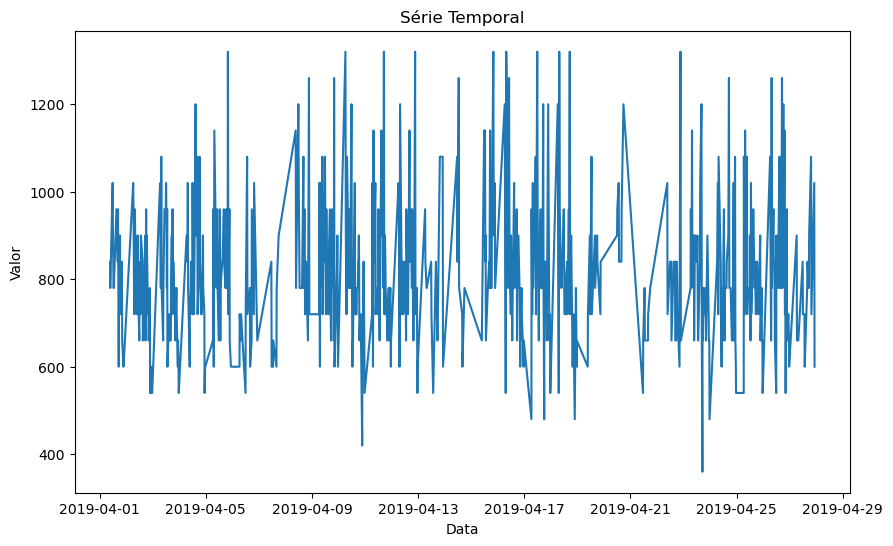

In [34]:
# Voltando a analisar o desvio padrão das durações de viagem de cada rota e plotando os valores de uma no gáfico após a remoçao dos outliers
a = df.groupby('Linha')['DuraçãoViagem'].std().reset_index().sort_values(by='DuraçãoViagem').reset_index(drop=True)
print(a)
df_plot = df.loc[df['Linha'] == '362'][['Ini','DuraçãoViagem']].sort_values(by='Ini')
df_plot = df_plot[(df_plot["Ini"] > "2019-04-01") & (df_plot["Ini"] < "2019-04-28")]
df_plot.set_index('Ini', inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(df_plot.index, df_plot['DuraçãoViagem'])
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Série Temporal')
plt.show()

In [35]:
#Selecionando as rotas que serão usadas nos teste
a.iloc[[0,1,64,65,92,93]]

,Linha,DuraçãoViagem
0,362,178.799001
1,162,200.062211
64,605,518.593351
65,1123,530.362203
92,235,848.243518
93,4122,864.089809


In [36]:
# Deixando o dataframe apenas com as rotas que serão utilizadas
df = df.loc[df['Linha'].isin(['362','271','605','1120','235','4122'])].reset_index(drop=True).sort_values(by=['Linha','Ini'],ascending=[True,True])
df

,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim,dia_semana,hora_dia,dia_ano,mes_ano,turno_dia,TotalGirosMean
29315,0,1120,3420,21,31.218,2018-11-06 06:10:00,2018-11-06 07:07:00,2,6,310,11,2,22.0
29316,0,1120,4560,26,31.218,2018-11-06 06:44:00,2018-11-06 08:00:00,2,6,310,11,2,22.0
29394,1,1120,3720,6,30.640,2018-11-06 07:08:00,2018-11-06 08:10:00,2,7,310,11,2,8.0
29317,0,1120,4320,30,31.218,2018-11-06 08:10:00,2018-11-06 09:22:00,2,8,310,11,2,11.0
29318,1,1120,3060,4,30.640,2018-11-06 08:14:00,2018-11-06 09:05:00,2,8,310,11,2,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35277,0,605,3900,16,19.437,2019-10-31 12:51:00,2019-10-31 13:56:00,4,12,304,10,2,17.0
35278,0,605,3780,10,19.437,2019-10-31 13:39:00,2019-10-31 14:42:00,4,13,304,10,2,5.0
35279,0,605,3780,18,19.437,2019-10-31 15:57:00,2019-10-31 17:00:00,4,15,304,10,2,10.5
35280,0,605,4440,26,19.437,2019-10-31 16:58:00,2019-10-31 18:12:00,4,16,304,10,2,27.0


In [37]:
# Dados gerais das rotas usadas
df.groupby('Linha').agg({'KmPerc':'max', 'Sentido':'count'})

,KmPerc,Sentido
Linha,,
1120,31.218,4582
235,24.110,4673
271,13.903,14001
362,4.240,8565
4122,25.244,4041
605,19.437,2864


In [38]:
print(df.shape)
len(df['Linha'].unique())

(38726, 13)


6

In [39]:
# Exportando o Dataframe
df.to_csv('dados_floripa_tratado.csv',index=False)

# Criação dos Modelos e Testes

## Teste Inicial

### Função que cria os 3 modelos e salva seus resultados

In [40]:
predictions = []
metrics = []


def cria_modelo(df_teste, x_teste, y_teste, x_treino, y_treino, rota, teste_nome):

    #Treino do Modelo XGB e salvamento do tempo
    inicio_tempo_treino_xgb = datetime.now()
    modelo_xgb = xgb.XGBRegressor(
        # gamma = 0.0,
        # learning_rate = 0.01,
        # max_depth = 4,
        # min_child_weight = 8,
        # n_estimators = 500
    )
    modelo_xgb.fit(x_treino, y_treino, eval_set = [(x_treino, y_treino)])

    fim_tempo_treino_xgb = datetime.now()
    tempo_treino_xgb = fim_tempo_treino_xgb - inicio_tempo_treino_xgb
    tempo_treino_xgb = float(f"{str(tempo_treino_xgb.seconds)}.{str(tempo_treino_xgb.microseconds)}")

    #Treino do Modelo RF e salvamento do tempo
    inicio_tempo_treino_rf = datetime.now()
    modelo_rf = RandomForestRegressor(
        # bootstrap = True,
        # max_depth = 11,
        # max_features = 'log2',
        # min_samples_leaf = 7,
        # min_samples_split = 6,
        # n_estimators = 500
    )
    modelo_rf.fit(x_treino, y_treino)

    fim_tempo_treino_rf = datetime.now()
    tempo_treino_rf = fim_tempo_treino_rf - inicio_tempo_treino_rf
    tempo_treino_rf = float(f"{str(tempo_treino_rf.seconds)}.{str(tempo_treino_rf.microseconds)}")

    #Treino do Modelo LR e salvamento do tempo
    inicio_tempo_treino_lr = datetime.now()
    modelo_lr = LinearRegression()
    modelo_lr.fit(x_treino, y_treino)

    fim_tempo_treino_lr = datetime.now()
    tempo_treino_lr = fim_tempo_treino_lr - inicio_tempo_treino_lr
    tempo_treino_lr = float(f"{str(tempo_treino_lr.seconds)}.{str(tempo_treino_lr.microseconds)}")

    #Nomeando a coluna que receberá as previsões
    TesteNomeXGB = f"XGB - {teste_nome}"
    TesteNomeRF = f"RF - {teste_nome}"
    TesteNomeLR = f"LR - {teste_nome}"

    #Predição do XGB e salvamento do tempo
    inicio_tempo_previsao_xgb = datetime.now()
    df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
    fim_tempo_previsao_xgb = datetime.now()
    tempo_previsao_xgb = fim_tempo_previsao_xgb - inicio_tempo_previsao_xgb
    tempo_previsao_xgb = float(f"{str(tempo_previsao_xgb.seconds)}.{str(tempo_previsao_xgb.microseconds)}")

    #Predição do RF e salvamento do tempo
    inicio_tempo_previsao_rf = datetime.now()
    df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
    fim_tempo_previsao_rf = datetime.now()
    tempo_previsao_rf = fim_tempo_previsao_rf - inicio_tempo_previsao_rf
    tempo_previsao_rf = float(f"{str(tempo_previsao_rf.seconds)}.{str(tempo_previsao_rf.microseconds)}")

    #Predição do LR e salvamento do tempo
    inicio_tempo_previsao_lr = datetime.now()
    df_teste[f'{TesteNomeLR}'] = modelo_lr.predict(x_teste)
    fim_tempo_previsao_lr = datetime.now()
    tempo_previsao_lr = fim_tempo_previsao_lr - inicio_tempo_previsao_lr
    tempo_previsao_lr = float(f"{str(tempo_previsao_lr.seconds)}.{str(tempo_previsao_lr.microseconds)}")

    #Métricas do XGB
    RMSE_xgb = np.sqrt(mtr.mean_squared_error(df_teste["DuraçãoViagem"], df_teste[f"{TesteNomeXGB}"]))
    MAPE_xgb = mtr.mean_absolute_percentage_error(df_teste["DuraçãoViagem"], df_teste[f"{TesteNomeXGB}"])

    #Métricas do RF
    RMSE_rf = np.sqrt(mtr.mean_squared_error(df_teste["DuraçãoViagem"], df_teste[f"{TesteNomeRF}"]))
    MAPE_rf = mtr.mean_absolute_percentage_error(df_teste["DuraçãoViagem"], df_teste[f"{TesteNomeRF}"])

    #Métricas do LR
    RMSE_lr = np.sqrt(mtr.mean_squared_error(df_teste["DuraçãoViagem"], df_teste[f"{TesteNomeLR}"]))
    MAPE_lr = mtr.mean_absolute_percentage_error(df_teste["DuraçãoViagem"], df_teste[f"{TesteNomeLR}"])

    #Salvando as métricas num DataFrame Bonitinho
    metrics.append([f'{teste_nome}', rota,'XGBoost','RMSE',RMSE_xgb, tempo_treino_xgb, tempo_previsao_xgb])
    metrics.append([f'{teste_nome}', rota,'XGBoost','MAPE',MAPE_xgb, tempo_treino_xgb, tempo_previsao_xgb])
    metrics.append([f'{teste_nome}', rota,'Random Forest','RMSE',RMSE_rf, tempo_treino_rf, tempo_previsao_rf])
    metrics.append([f'{teste_nome}', rota,'Random Forest','MAPE',MAPE_rf, tempo_treino_rf, tempo_previsao_rf])
    metrics.append([f'{teste_nome}', rota,'Linear Regression','RMSE',RMSE_lr, tempo_treino_lr, tempo_previsao_lr])
    metrics.append([f'{teste_nome}', rota,'Linear Regression','MAPE',MAPE_lr, tempo_treino_lr, tempo_previsao_lr])

    #Salvando as predições num DataFrame Bonitinho
    for i in range(df_teste.shape[0]):
        predictions.append([f'{teste_nome}', df_teste['Ini'].iloc[i], rota,'XGBoost',df_teste[f"{TesteNomeXGB}"].iloc[i]])
        predictions.append([f'{teste_nome}', df_teste['Ini'].iloc[i], rota,'Random Forest',df_teste[f"{TesteNomeRF}"].iloc[i]])
        predictions.append([f'{teste_nome}', df_teste['Ini'].iloc[i], rota,'Linear Regression',df_teste[f"{TesteNomeLR}"].iloc[i]])
        predictions.append([f'{teste_nome}', df_teste['Ini'].iloc[i], rota,'Tempo real',df_teste["DuraçãoViagem"].iloc[i]])


    fi_xgb = pd.DataFrame(data=modelo_xgb.feature_importances_, index=modelo_xgb.feature_names_in_, columns=["importance"])
    fi_xgb["Teste"] = teste_nome
    fi_xgb = fi_xgb.reset_index().pivot(index="Teste", columns="index", values="importance")
    # fi_xgb.sort_values("importance").plot(kind="barh", title=f"Importância Dados XGB {rota}")
    # plt.savefig(f"Images/FI_XGB_{rota}_{teste_nome}.jpg")
    
    fi_rf = pd.DataFrame(data=modelo_rf.feature_importances_, index=x_treino.columns, columns=["importance"])
    fi_rf["Teste"] = teste_nome
    fi_rf = fi_rf.reset_index().pivot(index="Teste", columns="index", values="importance")
    # fi_rf.sort_values("importance").plot(kind="barh", title=f"Importância Dados RF {rota}")
    # plt.savefig(f"Images/FI_RF_{rota}_{teste_nome}.jpg")

    return fi_xgb, fi_rf

### Execuções por rotas

In [41]:
Colunas = [
    ['Sentido','KmPerc','dia_semana','hora_dia','dia_ano','mes_ano','turno_dia','TotalGirosMean']
]
TestesNome = [
    "0 Teste de Colunas - ['Sentido','KmPerc','dia_semana','hora_dia','dia_ano','mes_ano','turno_dia','TotalGirosMean']"

]
importance = pd.DataFrame(columns=["KmPerc", "Sentido", "dia_ano", "dia_semana", "hora_dia", "mes_ano", "turno_dia", "TotalGirosMean"])

# Um loop para rodar os modelos uma rota por vez e um cenário por vez
rotas = df['Linha'].unique()
for rota in rotas:
    df_modelo = df.loc[df['Linha']==rota].sort_values(by=["Ini"], ascending=False)

    shape = int(df_modelo.shape[0] * 0.3)
    df_teste = df_modelo[:shape]
    df_treino = df_modelo[shape:]
    for i in range(len(TestesNome)):
        teste_nome = TestesNome[i]
        # Não passamos a Linha pois não faz sentido já que é tudo igual, e tiramos as datas de Ini e Fim pois com elas seria apenas calcular o a duração. E o modelo XGB não aceita datetime
        x_teste = df_teste[Colunas[i]]
        y_teste = df_teste["DuraçãoViagem"]
        x_treino = df_treino[Colunas[i]]
        y_treino = df_treino["DuraçãoViagem"]

        fi_xgb, fi_rf = cria_modelo(df_teste, x_teste, y_teste, x_treino, y_treino, rota, teste_nome)
        fi_xgb["rota"], fi_rf["rota"] = rota, rota
        fi_xgb["modelo"], fi_rf["modelo"] = "XGB", "RF"

        importance = pd.concat([importance, fi_xgb, fi_rf])


[0]	validation_0-rmse:2761.67779
[1]	validation_0-rmse:1958.67208
[2]	validation_0-rmse:1403.68083
[3]	validation_0-rmse:1024.18370
[4]	validation_0-rmse:768.71614
[5]	validation_0-rmse:601.40748
[6]	validation_0-rmse:496.68425
[7]	validation_0-rmse:432.87627
[8]	validation_0-rmse:394.61285
[9]	validation_0-rmse:370.44435
[10]	validation_0-rmse:357.12341
[11]	validation_0-rmse:347.86716
[12]	validation_0-rmse:342.78816
[13]	validation_0-rmse:339.77326
[14]	validation_0-rmse:336.65660


[15]	validation_0-rmse:334.14750
[16]	validation_0-rmse:331.30526
[17]	validation_0-rmse:329.13079
[18]	validation_0-rmse:323.01812
[19]	validation_0-rmse:320.56431
[20]	validation_0-rmse:319.20777
[21]	validation_0-rmse:317.28602
[22]	validation_0-rmse:315.55828
[23]	validation_0-rmse:312.62790
[24]	validation_0-rmse:311.91820
[25]	validation_0-rmse:310.79285
[26]	validation_0-rmse:306.81700
[27]	validation_0-rmse:303.73995
[28]	validation_0-rmse:302.14782
[29]	validation_0-rmse:300.27992
[30]	validation_0-rmse:297.53246
[31]	validation_0-rmse:295.99842
[32]	validation_0-rmse:295.16338
[33]	validation_0-rmse:292.42029
[34]	validation_0-rmse:290.90007
[35]	validation_0-rmse:288.10611
[36]	validation_0-rmse:284.78499
[37]	validation_0-rmse:284.37231
[38]	validation_0-rmse:280.96463
[39]	validation_0-rmse:280.48910
[40]	validation_0-rmse:279.43020
[41]	validation_0-rmse:276.81194
[42]	validation_0-rmse:276.26428
[43]	validation_0-rmse:270.37128
[44]	validation_0-rmse:268.76630
[45]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:1940.63217
[1]	validation_0-rmse:1387.73944
[2]	validation_0-rmse:1006.96975
[3]	validation_0-rmse:750.47421
[4]	validation_0-rmse:577.09250
[5]	validation_0-rmse:468.71314
[6]	validation_0-rmse:402.60223
[7]	validation_0-rmse:364.23219
[8]	validation_0-rmse:337.27774
[9]	validation_0-rmse:318.88808
[10]	validation_0-rmse:307.86984
[11]	validation_0-rmse:300.54854
[12]	validation_0-rmse:295.19055
[13]	validation_0-rmse:289.79707
[14]	validation_0-rmse:285.18907
[15]	validation_0-rmse:280.60777
[16]	validation_0-rmse:278.47147
[17]	validation_0-rmse:274.46901
[18]	validation_0-rmse:273.22146
[19]	validation_0-rmse:272.20484
[20]	validation_0-rmse:269.17100
[21]	validation_0-rmse:267.96191
[22]	validation_0-rmse:264.34986
[23]	validation_0-rmse:263.56489
[24]	validation_0-rmse:261.36051
[25]	validation_0-rmse:260.15530
[26]	validation_0-rmse:258.20973
[27]	validation_0-rmse:255.75595
[28]	validation_0-rmse:254.30276
[29]	validation_0-rmse:253.83325
[30]	validation_0

C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[1]	validation_0-rmse:721.30449
[2]	validation_0-rmse:520.01768
[3]	validation_0-rmse:383.69737
[4]	validation_0-rmse:292.86982
[5]	validation_0-rmse:236.04899
[6]	validation_0-rmse:201.69334
[7]	validation_0-rmse:182.51564
[8]	validation_0-rmse:172.02823
[9]	validation_0-rmse:166.16801
[10]	validation_0-rmse:162.40734
[11]	validation_0-rmse:159.53501
[12]	validation_0-rmse:156.98306
[13]	validation_0-rmse:155.81482
[14]	validation_0-rmse:155.24720
[15]	validation_0-rmse:154.82973
[16]	validation_0-rmse:153.41932
[17]	validation_0-rmse:152.18165
[18]	validation_0-rmse:151.68424
[19]	validation_0-rmse:150.75104
[20]	validation_0-rmse:149.33459
[21]	validation_0-rmse:149.06063
[22]	validation_0-rmse:148.05673
[23]	validation_0-rmse:147.59353
[24]	validation_0-rmse:147.12460
[25]	validation_0-rmse:146.06885
[26]	validation_0-rmse:145.88036
[27]	validation_0-rmse:145.33102
[28]	validation_0-rmse:144.44346
[29]	validation_0-rmse:144.33721
[30]	validation_0-rmse:143.90877
[31]	validation_0-r

C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:603.73921
[1]	validation_0-rmse:437.18497
[2]	validation_0-rmse:324.56813
[3]	validation_0-rmse:250.55170
[4]	validation_0-rmse:204.05507
[5]	validation_0-rmse:175.79365
[6]	validation_0-rmse:159.27288
[7]	validation_0-rmse:150.01033
[8]	validation_0-rmse:144.55710
[9]	validation_0-rmse:141.47444
[10]	validation_0-rmse:138.69459
[11]	validation_0-rmse:136.18277
[12]	validation_0-rmse:135.43487
[13]	validation_0-rmse:135.00958
[14]	validation_0-rmse:134.21333
[15]	validation_0-rmse:133.11017
[16]	validation_0-rmse:131.95821
[17]	validation_0-rmse:131.64292
[18]	validation_0-rmse:131.37758
[19]	validation_0-rmse:130.90655
[20]	validation_0-rmse:130.16379
[21]	validation_0-rmse:129.20634
[22]	validation_0-rmse:128.52396
[23]	validation_0-rmse:128.25757
[24]	validation_0-rmse:127.44741
[25]	validation_0-rmse:126.95012
[26]	validation_0-rmse:126.43814
[27]	validation_0-rmse:125.70047
[28]	validation_0-rmse:125.47579
[29]	validation_0-rmse:124.92169
[30]	validation_0-rm

C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:2259.62983
[1]	validation_0-rmse:1621.20862
[2]	validation_0-rmse:1183.72499
[3]	validation_0-rmse:888.87951
[4]	validation_0-rmse:695.56787
[5]	validation_0-rmse:570.77886
[6]	validation_0-rmse:496.75807
[7]	validation_0-rmse:450.73670
[8]	validation_0-rmse:425.68055
[9]	validation_0-rmse:407.03411
[10]	validation_0-rmse:398.12362
[11]	validation_0-rmse:389.65748
[12]	validation_0-rmse:385.42991
[13]	validation_0-rmse:381.35636
[14]	validation_0-rmse:376.21088
[15]	validation_0-rmse:372.62739
[16]	validation_0-rmse:369.29024
[17]	validation_0-rmse:363.55499
[18]	validation_0-rmse:360.84073
[19]	validation_0-rmse:360.13643
[20]	validation_0-rmse:357.42087
[21]	validation_0-rmse:353.83128
[22]	validation_0-rmse:352.84695
[23]	validation_0-rmse:350.25943
[24]	validation_0-rmse:346.22833
[25]	validation_0-rmse:345.75525
[26]	validation_0-rmse:342.05751
[27]	validation_0-rmse:339.23835
[28]	validation_0-rmse:335.75313
[29]	validation_0-rmse:333.27042
[30]	validation_0

C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[1]	validation_0-rmse:1665.20358
[2]	validation_0-rmse:1194.39764
[3]	validation_0-rmse:872.83237
[4]	validation_0-rmse:657.28979
[5]	validation_0-rmse:516.80842
[6]	validation_0-rmse:424.87663
[7]	validation_0-rmse:368.89580
[8]	validation_0-rmse:335.72714
[9]	validation_0-rmse:316.42870
[10]	validation_0-rmse:306.99668
[11]	validation_0-rmse:297.89105
[12]	validation_0-rmse:291.29342
[13]	validation_0-rmse:289.20639
[14]	validation_0-rmse:288.11829
[15]	validation_0-rmse:287.17685
[16]	validation_0-rmse:282.05776
[17]	validation_0-rmse:276.67583
[18]	validation_0-rmse:274.20855
[19]	validation_0-rmse:270.60730
[20]	validation_0-rmse:268.34374
[21]	validation_0-rmse:265.90007
[22]	validation_0-rmse:265.01493
[23]	validation_0-rmse:264.71525
[24]	validation_0-rmse:261.66999
[25]	validation_0-rmse:261.12028
[26]	validation_0-rmse:257.62880
[27]	validation_0-rmse:256.85554
[28]	validation_0-rmse:254.49427
[29]	validation_0-rmse:254.25428
[30]	validation_0-rmse:253.58614
[31]	validation_0

C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [42]:
importance

,KmPerc,Sentido,dia_ano,dia_semana,hora_dia,mes_ano,turno_dia,TotalGirosMean,rota,modelo
"0 Teste de Colunas - ['Sentido','KmPerc','dia_semana','hora_dia','dia_ano','mes_ano','turno_dia','TotalGirosMean']",0.000000,0.231423,0.114384,0.318465,0.252746,0.000000,0.000000,0.082983,1120,XGB
"0 Teste de Colunas - ['Sentido','KmPerc','dia_semana','hora_dia','dia_ano','mes_ano','turno_dia','TotalGirosMean']",0.051130,0.048625,0.258405,0.163852,0.283604,0.028839,0.008893,0.156653,1120,RF
"0 Teste de Colunas - ['Sentido','KmPerc','dia_semana','hora_dia','dia_ano','mes_ano','turno_dia','TotalGirosMean']",0.936995,0.004383,0.009428,0.003337,0.041605,0.000000,0.000000,0.004253,235,XGB
"0 Teste de Colunas - ['Sentido','KmPerc','dia_semana','hora_dia','dia_ano','mes_ano','turno_dia','TotalGirosMean']",0.633961,0.006063,0.107959,0.015163,0.166475,0.008805,0.002929,0.058645,235,RF
"0 Teste de Colunas - ['Sentido','KmPerc','dia_semana','hora_dia','dia_ano','mes_ano','turno_dia','TotalGirosMean']",0.000000,0.234569,0.168082,0.156911,0.319956,0.000000,0.000000,0.120482,271,XGB
"0 Teste de Colunas - ['Sentido','KmPerc','dia_semana','hora_dia','dia_ano','mes_ano','turno_dia','TotalGirosMean']",0.032534,0.030999,0.313237,0.111714,0.264732,0.031853,0.007998,0.206933,271,RF
"0 Teste de Colunas - ['Sentido','KmPerc','dia_semana','hora_dia','dia_ano','mes_ano','turno_dia','TotalGirosMean']",0.000000,0.289705,0.206855,0.149460,0.231473,0.000000,0.000000,0.122507,362,XGB
"0 Teste de Colunas - ['Sentido','KmPerc','dia_semana','hora_dia','dia_ano','mes_ano','turno_dia','TotalGirosMean']",0.043939,0.031841,0.385548,0.103107,0.218245,0.042606,0.005678,0.169037,362,RF
"0 Teste de Colunas - ['Sentido','KmPerc','dia_semana','hora_dia','dia_ano','mes_ano','turno_dia','TotalGirosMean']",0.000000,0.599654,0.055685,0.026251,0.281176,0.000000,0.000000,0.037233,4122,XGB
"0 Teste de Colunas - ['Sentido','KmPerc','dia_semana','hora_dia','dia_ano','mes_ano','turno_dia','TotalGirosMean']",0.172175,0.145340,0.162795,0.032270,0.245670,0.020915,0.136607,0.084228,4122,RF


In [44]:
a = pd.DataFrame(metrics, columns=['Teste','Rota','Modelo','Métrica','Valor', 'Tempo de treino', 'Tempo de previsão'])
a.loc[a['Métrica'] == 'MAPE'].sort_values(by='Valor')

,Teste,Rota,Modelo,Métrica,Valor,Tempo de treino,Tempo de previsão
3,"0 Teste de Colunas - ['Sentido','KmPerc','dia_...",1120,Random Forest,MAPE,0.080899,0.752364,0.21499
1,"0 Teste de Colunas - ['Sentido','KmPerc','dia_...",1120,XGBoost,MAPE,0.086519,0.257415,0.99800
17,"0 Teste de Colunas - ['Sentido','KmPerc','dia_...",271,Linear Regression,MAPE,0.095755,0.344700,0.19940
13,"0 Teste de Colunas - ['Sentido','KmPerc','dia_...",271,XGBoost,MAPE,0.097957,0.344700,0.32500
15,"0 Teste de Colunas - ['Sentido','KmPerc','dia_...",271,Random Forest,MAPE,0.100035,2.532180,0.49243
5,"0 Teste de Colunas - ['Sentido','KmPerc','dia_...",1120,Linear Regression,MAPE,0.102608,0.365430,0.15020
35,"0 Teste de Colunas - ['Sentido','KmPerc','dia_...",605,Linear Regression,MAPE,0.104231,0.116030,0.99700
33,"0 Teste de Colunas - ['Sentido','KmPerc','dia_...",605,Random Forest,MAPE,0.106476,0.463037,0.16668
31,"0 Teste de Colunas - ['Sentido','KmPerc','dia_...",605,XGBoost,MAPE,0.106932,0.212684,0.30910
7,"0 Teste de Colunas - ['Sentido','KmPerc','dia_...",235,XGBoost,MAPE,0.123449,0.368055,0.25040


In [50]:
corr = df.corr()
corr

C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\2438084875.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


,Sentido,DuraçãoViagem,TotalGiros,KmPerc,dia_semana,hora_dia,dia_ano,mes_ano,turno_dia,TotalGirosMean
Sentido,1.000000,-0.038344,-0.130788,-0.078349,-0.004656,0.071973,-0.000195,-0.000030,0.066639,0.012892
DuraçãoViagem,-0.038344,1.000000,0.378288,0.859106,-0.004924,-0.104892,-0.043986,-0.044402,-0.140044,0.391133
TotalGiros,-0.130788,0.378288,1.000000,0.328887,-0.055781,0.061999,-0.012069,-0.011626,-0.046107,0.554278
KmPerc,-0.078349,0.859106,0.328887,1.000000,0.020420,-0.072912,-0.037748,-0.038264,-0.078560,0.450928
dia_semana,-0.004656,-0.004924,-0.055781,0.020420,1.000000,-0.015228,-0.006944,-0.006878,-0.007397,0.010385
hora_dia,0.071973,-0.104892,0.061999,-0.072912,-0.015228,1.000000,0.002601,0.002476,0.727504,0.079882
dia_ano,-0.000195,-0.043986,-0.012069,-0.037748,-0.006944,0.002601,1.000000,0.996500,0.003367,-0.020454
mes_ano,-0.000030,-0.044402,-0.011626,-0.038264,-0.006878,0.002476,0.996500,1.000000,0.003486,-0.019513
turno_dia,0.066639,-0.140044,-0.046107,-0.078560,-0.007397,0.727504,0.003367,0.003486,1.000000,-0.057598
TotalGirosMean,0.012892,0.391133,0.554278,0.450928,0.010385,0.079882,-0.020454,-0.019513,-0.057598,1.000000


In [49]:
# a.to_excel("Teste0.xlsx", index=False)
importance.to_excel("Results/Teste_0_importance.xlsx")
corr.to_excel("Results/Correlacao_Atributos.xlsx")

  Linha  DuraçãoViagem
0   362     178.799001
1   271     200.500940
2   605     518.593351
3  1120     538.178775
4   235     848.243518
5  4122     864.089809


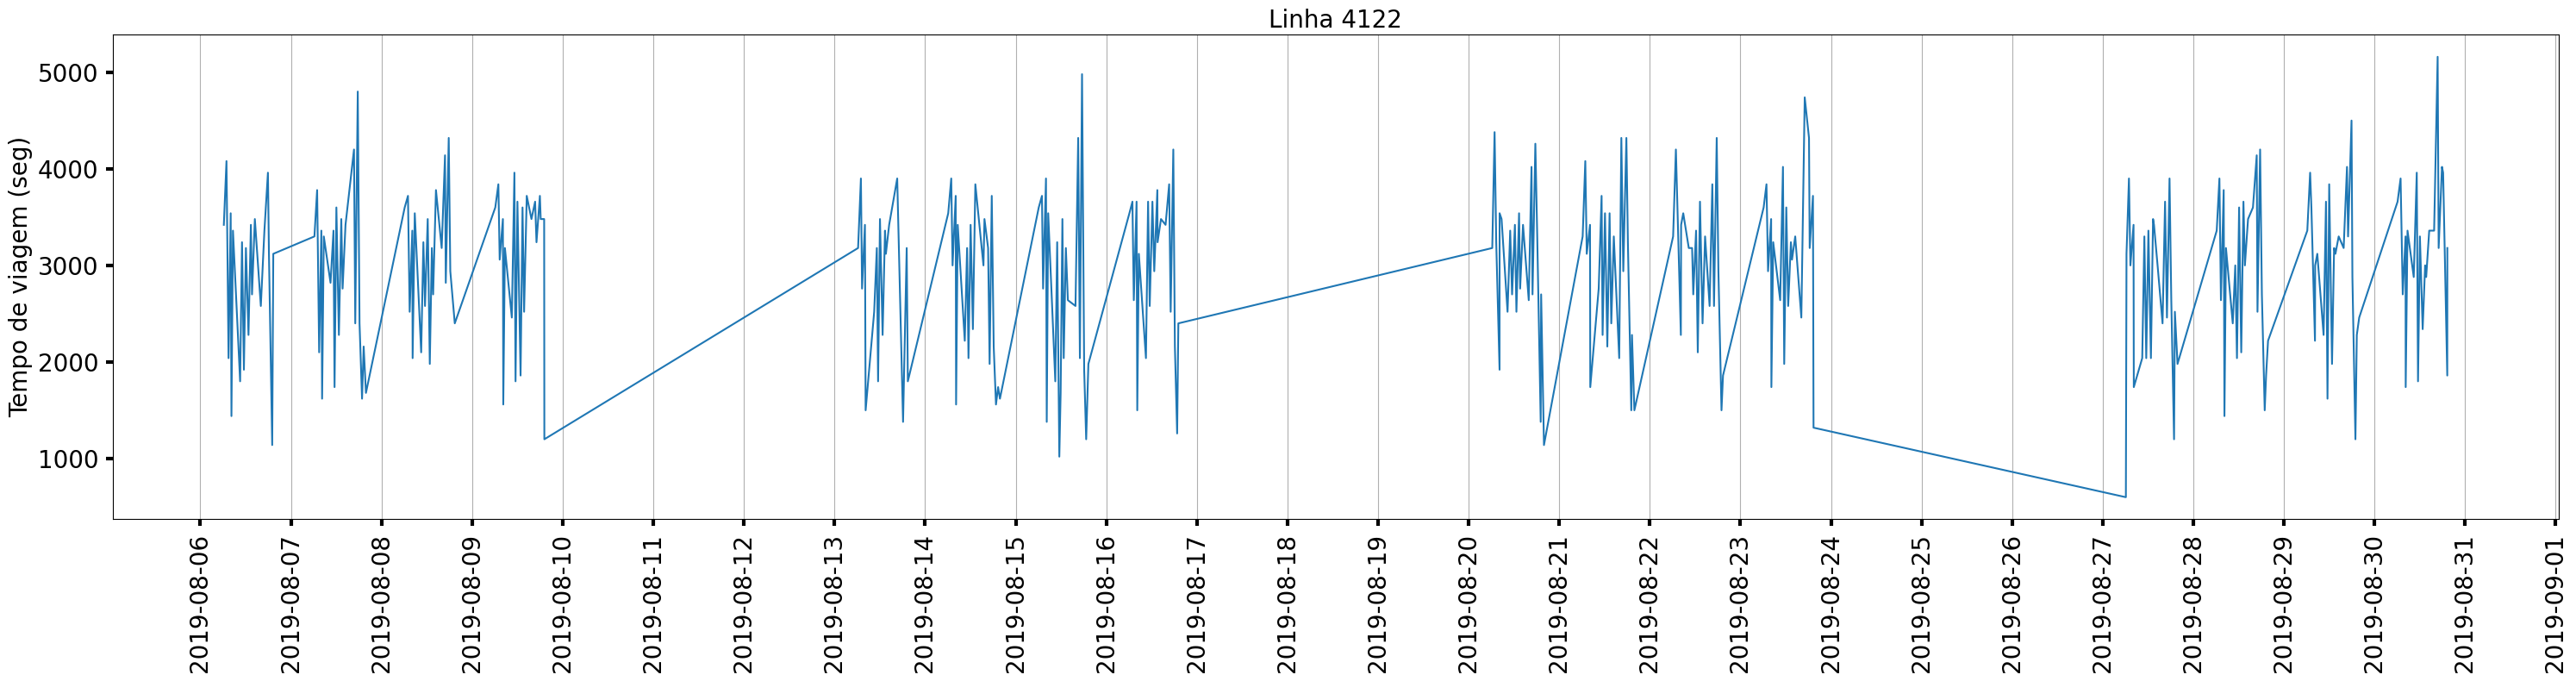

In [116]:
rota = "4122"

a = df.groupby('Linha')['DuraçãoViagem'].std().reset_index().sort_values(by='DuraçãoViagem').reset_index(drop=True)
print(a)
df_plot = df.loc[df['Linha'] == rota][['Ini','DuraçãoViagem']].sort_values(by='Ini')
df_plot = df_plot[(df_plot["Ini"] > "2019-08-04") & (df_plot["Ini"] < "2019-08-31")]
df_plot.set_index('Ini', inplace=True)

import matplotlib.dates as mdates

plt.figure(figsize=(30, 8))
plt.plot(df_plot.index, df_plot['DuraçãoViagem'])
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.ylabel('Tempo de viagem (seg)', fontsize=20)
plt.xticks(fontsize=20, rotation=90)
plt.yticks(fontsize=20)
plt.tick_params(axis='both', which='both', width=3, length=6, pad=6)
plt.grid(axis="x")
plt.title(f'Linha {rota}', fontsize=20)
plt.tight_layout()
# plt.savefig(f"Images/rota_{rota}.svg")
plt.show()


In [52]:
b = pd.DataFrame(predictions, columns=['Teste','Data','Rota','Modelo','Valor'])
b

,Teste,Data,Rota,Modelo,Valor
0,"0 Teste de Colunas - ['Sentido','KmPerc','dia_...",2019-10-31 19:44:00,1120,XGBoost,4184.473145
1,"0 Teste de Colunas - ['Sentido','KmPerc','dia_...",2019-10-31 19:44:00,1120,Random Forest,4008.600000
2,"0 Teste de Colunas - ['Sentido','KmPerc','dia_...",2019-10-31 19:44:00,1120,Linear Regression,4011.229328
3,"0 Teste de Colunas - ['Sentido','KmPerc','dia_...",2019-10-31 19:44:00,1120,Tempo real,3600.000000
4,"0 Teste de Colunas - ['Sentido','KmPerc','dia_...",2019-10-31 18:26:00,1120,XGBoost,4471.656250
...,...,...,...,...,...
46455,"0 Teste de Colunas - ['Sentido','KmPerc','dia_...",2019-07-18 17:02:00,605,Tempo real,2880.000000
46456,"0 Teste de Colunas - ['Sentido','KmPerc','dia_...",2019-07-18 16:08:00,605,XGBoost,3677.500244
46457,"0 Teste de Colunas - ['Sentido','KmPerc','dia_...",2019-07-18 16:08:00,605,Random Forest,3522.220000
46458,"0 Teste de Colunas - ['Sentido','KmPerc','dia_...",2019-07-18 16:08:00,605,Linear Regression,3311.376363


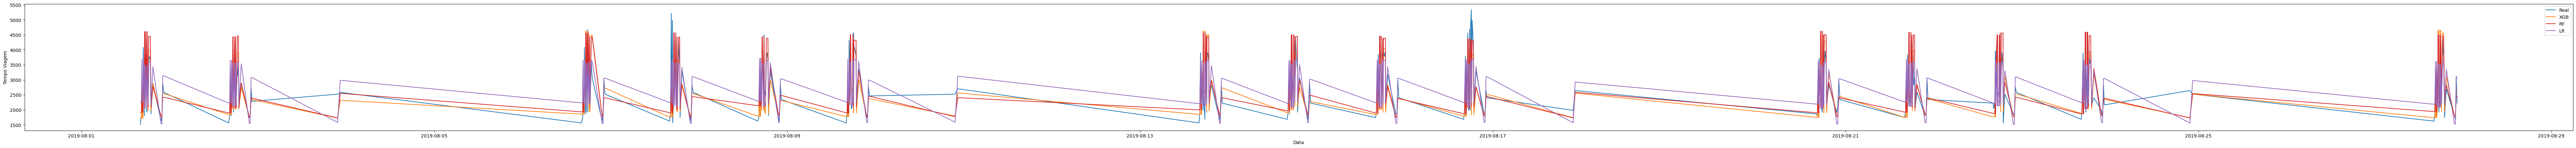

In [53]:
b = pd.DataFrame(predictions, columns=['Teste','Data','Rota','Modelo','Valor'])
b["Data"] = pd.to_datetime(b["Data"]) 
b = b.sort_values(by=["Data"], ascending=False)

plt.figure(figsize=(100, 5))

plt.xlabel("Data")
plt.ylabel("Tempo Viagem")

b = b.loc[(b["Data"] > "2019-08-01") & (b["Data"] < "2019-08-28") & (b['Rota'] == '235')]

real_plor = b.loc[b['Modelo'] == 'Tempo real']
plt.plot(real_plor["Data"], real_plor["Valor"], color="#1f77b4", label="Real")

xgb_plot = b.loc[b['Modelo'] == 'XGBoost']
plt.plot(xgb_plot["Data"], xgb_plot["Valor"], color="#ff7f0e", label="XGB")

rf_plot = b.loc[b['Modelo'] == 'Random Forest']
plt.plot(rf_plot["Data"], rf_plot["Valor"], color="#d62728", label="RF")

lr_plot = b.loc[b['Modelo'] == 'Linear Regression']
plt.plot(lr_plot["Data"], lr_plot["Valor"], color="#9467bd", label="LR")

plt.legend()
plt.show()
#plt.savefig(f"Images/previsao_235.jpg")

In [41]:
df.loc[df["Linha"] == "4122"].groupby(["KmPerc", "Sentido"]).size()

KmPerc  Sentido
11.960  1          1897
25.244  0          2144
dtype: int64

In [42]:
df.corr()

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,Sentido,DuraçãoViagem,TotalGiros,KmPerc,dia_semana,hora_dia,dia_ano,mes_ano,turno_dia,TotalGirosMean
Sentido,1.000000,-0.038344,-0.130788,-0.078349,-0.004656,0.071973,-0.000195,-0.000030,0.066639,0.012892
DuraçãoViagem,-0.038344,1.000000,0.378288,0.859106,-0.004924,-0.104892,-0.043986,-0.044402,-0.140044,0.391133
TotalGiros,-0.130788,0.378288,1.000000,0.328887,-0.055781,0.061999,-0.012069,-0.011626,-0.046107,0.554278
KmPerc,-0.078349,0.859106,0.328887,1.000000,0.020420,-0.072912,-0.037748,-0.038264,-0.078560,0.450928
dia_semana,-0.004656,-0.004924,-0.055781,0.020420,1.000000,-0.015228,-0.006944,-0.006878,-0.007397,0.010385
hora_dia,0.071973,-0.104892,0.061999,-0.072912,-0.015228,1.000000,0.002601,0.002476,0.727504,0.079882
dia_ano,-0.000195,-0.043986,-0.012069,-0.037748,-0.006944,0.002601,1.000000,0.996500,0.003367,-0.020454
mes_ano,-0.000030,-0.044402,-0.011626,-0.038264,-0.006878,0.002476,0.996500,1.000000,0.003486,-0.019513
turno_dia,0.066639,-0.140044,-0.046107,-0.078560,-0.007397,0.727504,0.003367,0.003486,1.000000,-0.057598
TotalGirosMean,0.012892,0.391133,0.554278,0.450928,0.010385,0.079882,-0.020454,-0.019513,-0.057598,1.000000


# Permuta

In [120]:
Colunas = [
    [
        ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano'],
        ['Sentido','dia_semana','hora_dia','dia_ano'],
        ['TotalGirosMean','dia_semana','hora_dia','dia_ano'],
        ['dia_semana','hora_dia','dia_ano']
    ],
    [
        ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano'],
        ['Sentido','dia_semana','hora_dia','dia_ano'],
        ['TotalGirosMean','dia_semana','hora_dia','dia_ano'],
        ['dia_semana','hora_dia','dia_ano'],
        ['Sentido','TotalGirosMean','KmPerc','dia_semana','hora_dia','dia_ano'],
        ['Sentido','dia_semana','KmPerc','hora_dia','dia_ano'],
        ['TotalGirosMean','KmPerc','dia_semana','hora_dia','dia_ano'],
        ['KmPerc','dia_semana','hora_dia','dia_ano'],
    ]
]
TestesNome = [
    [
        "1 Teste de Colunas - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano']",
        "1 Teste de Colunas - ['Sentido','dia_semana','hora_dia','dia_ano']",
        "1 Teste de Colunas - ['TotalGirosMean','dia_semana','hora_dia','dia_ano']",
        "1 Teste de Colunas - ['dia_semana','hora_dia','dia_ano']"
    ],
    [
        "1 Teste de Colunas - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano']",
        "1 Teste de Colunas - ['Sentido','dia_semana','hora_dia','dia_ano']",
        "1 Teste de Colunas - ['TotalGirosMean','dia_semana','hora_dia','dia_ano']",
        "1 Teste de Colunas - ['dia_semana','hora_dia','dia_ano']",
        "1 Teste de Colunas - ['Sentido','TotalGirosMean','KmPerc','dia_semana','hora_dia','dia_ano']",
        "1 Teste de Colunas - ['Sentido','dia_semana','KmPerc','hora_dia','dia_ano']",
        "1 Teste de Colunas - ['TotalGirosMean','KmPerc','dia_semana','hora_dia','dia_ano']",
        "1 Teste de Colunas - ['KmPerc','dia_semana','hora_dia','dia_ano']"
    ]
]

# Colunas235 = [
#     ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano'],
#     ['Sentido','dia_semana','hora_dia','dia_ano'],
#     ['TotalGirosMean','dia_semana','hora_dia','dia_ano'],
#     ['dia_semana','hora_dia','dia_ano']
#     ['Sentido','TotalGirosMean','KmPerc','dia_semana','hora_dia','dia_ano'],
#     ['Sentido','dia_semana','KmPerc','hora_dia','dia_ano'],
#     ['TotalGirosMean','KmPerc','dia_semana','hora_dia','dia_ano'],
#     ['KmPerc','dia_semana','hora_dia','dia_ano'],
# ]
# TestesNome235 = [
#     "1 Teste de Colunas - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano']",
#     "1 Teste de Colunas - ['Sentido','dia_semana','hora_dia','dia_ano']",
#     "1 Teste de Colunas - ['TotalGirosMean','dia_semana','hora_dia','dia_ano']",
#     "1 Teste de Colunas - ['dia_semana','hora_dia','dia_ano']"
#     "1 Teste de Colunas - ['Sentido','TotalGirosMean','KmPerc','dia_semana','hora_dia','dia_ano']",
#     "1 Teste de Colunas - ['Sentido','dia_semana','KmPerc','hora_dia','dia_ano']",
#     "1 Teste de Colunas - ['TotalGirosMean','KmPerc','dia_semana','hora_dia','dia_ano']",
#     "1 Teste de Colunas - ['KmPerc','dia_semana','hora_dia','dia_ano']"
# ]

# Um loop para rodar os modelos uma rota por vez e um cenário por vez
rotas = df['Linha'].unique()
for rota in rotas:
    df_modelo = df.loc[df['Linha']==rota].sort_values(by=["Ini"], ascending=False)

    shape = int(df_modelo.shape[0] * 0.3)
    df_teste = df_modelo[:shape]
    df_treino = df_modelo[shape:]

    teste_atual = 0 if rota != "235" else 1

    for i in range(len(TestesNome[teste_atual])):
        teste_nome = TestesNome[teste_atual][i]
        # Não passamos a Linha pois não faz sentido já que é tudo igual, e tiramos as datas de Ini e Fim pois com elas seria apenas calcular o a duração. E o modelo XGB não aceita datetime
        x_teste = df_teste[Colunas[teste_atual][i]]
        y_teste = df_teste["DuraçãoViagem"]
        x_treino = df_treino[Colunas[teste_atual][i]]
        y_treino = df_treino["DuraçãoViagem"]

        fi_xgb, fi_rf = cria_modelo(df_teste, x_teste, y_teste, x_treino, y_treino, rota, teste_nome)
        fi_xgb["rota"], fi_rf["rota"] = rota, rota
        fi_xgb["modelo"], fi_rf["modelo"] = "XGB", "RF"

        importance = pd.concat([importance, fi_xgb, fi_rf])

[0]	validation_0-rmse:2761.67779
[1]	validation_0-rmse:1958.67208
[2]	validation_0-rmse:1403.68083
[3]	validation_0-rmse:1024.18370
[4]	validation_0-rmse:768.71614
[5]	validation_0-rmse:601.40748
[6]	validation_0-rmse:496.68425
[7]	validation_0-rmse:432.87627
[8]	validation_0-rmse:394.61285
[9]	validation_0-rmse:370.44435


[10]	validation_0-rmse:357.12341
[11]	validation_0-rmse:347.86716
[12]	validation_0-rmse:342.78816
[13]	validation_0-rmse:339.77326
[14]	validation_0-rmse:336.65660
[15]	validation_0-rmse:334.14750
[16]	validation_0-rmse:331.30526
[17]	validation_0-rmse:329.13079
[18]	validation_0-rmse:323.01812
[19]	validation_0-rmse:320.56431
[20]	validation_0-rmse:319.20777
[21]	validation_0-rmse:317.28602
[22]	validation_0-rmse:315.55828
[23]	validation_0-rmse:312.62790
[24]	validation_0-rmse:311.91820
[25]	validation_0-rmse:310.79285
[26]	validation_0-rmse:306.81700
[27]	validation_0-rmse:303.73995
[28]	validation_0-rmse:302.14782
[29]	validation_0-rmse:300.27992
[30]	validation_0-rmse:297.53246
[31]	validation_0-rmse:295.99842
[32]	validation_0-rmse:295.16338
[33]	validation_0-rmse:292.42029
[34]	validation_0-rmse:290.90007
[35]	validation_0-rmse:288.10611
[36]	validation_0-rmse:284.78499
[37]	validation_0-rmse:284.37231
[38]	validation_0-rmse:280.96463
[39]	validation_0-rmse:280.48910
[40]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[1]	validation_0-rmse:1958.67208
[2]	validation_0-rmse:1403.70822
[3]	validation_0-rmse:1024.25842
[4]	validation_0-rmse:769.27525
[5]	validation_0-rmse:601.62521
[6]	validation_0-rmse:495.74784
[7]	validation_0-rmse:431.10795
[8]	validation_0-rmse:393.28974
[9]	validation_0-rmse:368.93159
[10]	validation_0-rmse:355.94972
[11]	validation_0-rmse:348.26118
[12]	validation_0-rmse:340.75395
[13]	validation_0-rmse:336.83992
[14]	validation_0-rmse:331.77629
[15]	validation_0-rmse:329.56415
[16]	validation_0-rmse:324.70476
[17]	validation_0-rmse:320.66385
[18]	validation_0-rmse:318.85474
[19]	validation_0-rmse:315.97978
[20]	validation_0-rmse:313.64703
[21]	validation_0-rmse:311.57236
[22]	validation_0-rmse:310.12285
[23]	validation_0-rmse:307.25160
[24]	validation_0-rmse:305.74644
[25]	validation_0-rmse:304.62724
[26]	validation_0-rmse:302.78519
[27]	validation_0-rmse:300.15243
[28]	validation_0-rmse:297.91988
[29]	validation_0-rmse:295.91563
[30]	validation_0-rmse:292.27648
[31]	validation_

C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:2765.15584
[1]	validation_0-rmse:1966.48574
[2]	validation_0-rmse:1417.30257
[3]	validation_0-rmse:1045.43948
[4]	validation_0-rmse:798.89207
[5]	validation_0-rmse:642.02716
[6]	validation_0-rmse:547.41115
[7]	validation_0-rmse:489.83772
[8]	validation_0-rmse:457.32275
[9]	validation_0-rmse:439.15274
[10]	validation_0-rmse:426.94171
[11]	validation_0-rmse:420.58301
[12]	validation_0-rmse:416.09126
[13]	validation_0-rmse:411.70555
[14]	validation_0-rmse:407.93010
[15]	validation_0-rmse:406.50272
[16]	validation_0-rmse:404.50448
[17]	validation_0-rmse:402.49981
[18]	validation_0-rmse:401.04070
[19]	validation_0-rmse:399.18226
[20]	validation_0-rmse:398.65726
[21]	validation_0-rmse:396.39256
[22]	validation_0-rmse:395.15294
[23]	validation_0-rmse:393.81133
[24]	validation_0-rmse:392.86418
[25]	validation_0-rmse:390.48672
[26]	validation_0-rmse:389.35260
[27]	validation_0-rmse:388.44079
[28]	validation_0-rmse:388.20665
[29]	validation_0-rmse:386.56746
[30]	validation_

C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[1]	validation_0-rmse:1967.62953
[2]	validation_0-rmse:1420.07491
[3]	validation_0-rmse:1046.59038
[4]	validation_0-rmse:801.32759
[5]	validation_0-rmse:645.18656
[6]	validation_0-rmse:547.94268
[7]	validation_0-rmse:491.35011
[8]	validation_0-rmse:460.11258
[9]	validation_0-rmse:441.06926
[10]	validation_0-rmse:430.48681
[11]	validation_0-rmse:423.55475
[12]	validation_0-rmse:419.10157
[13]	validation_0-rmse:417.40549
[14]	validation_0-rmse:414.30434
[15]	validation_0-rmse:411.68147
[16]	validation_0-rmse:408.52617
[17]	validation_0-rmse:405.80027
[18]	validation_0-rmse:404.89515
[19]	validation_0-rmse:402.31800
[20]	validation_0-rmse:401.32609
[21]	validation_0-rmse:399.92857
[22]	validation_0-rmse:399.16675
[23]	validation_0-rmse:397.50690
[24]	validation_0-rmse:396.82299
[25]	validation_0-rmse:395.40515
[26]	validation_0-rmse:394.56919
[27]	validation_0-rmse:393.18978
[28]	validation_0-rmse:390.52023
[29]	validation_0-rmse:389.13833
[30]	validation_0-rmse:388.76303
[31]	validation_

C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[1]	validation_0-rmse:1387.92089
[2]	validation_0-rmse:1007.22562
[3]	validation_0-rmse:748.85870
[4]	validation_0-rmse:574.14905
[5]	validation_0-rmse:462.33104
[6]	validation_0-rmse:393.35703
[7]	validation_0-rmse:353.16455
[8]	validation_0-rmse:327.90987
[9]	validation_0-rmse:311.49236
[10]	validation_0-rmse:300.47711
[11]	validation_0-rmse:295.09310
[12]	validation_0-rmse:289.83082
[13]	validation_0-rmse:285.71574
[14]	validation_0-rmse:281.68704
[15]	validation_0-rmse:279.32180
[16]	validation_0-rmse:276.46162
[17]	validation_0-rmse:274.60451
[18]	validation_0-rmse:272.54790
[19]	validation_0-rmse:270.96056
[20]	validation_0-rmse:269.04897
[21]	validation_0-rmse:266.25871
[22]	validation_0-rmse:265.05888
[23]	validation_0-rmse:263.83921
[24]	validation_0-rmse:263.03021
[25]	validation_0-rmse:261.66532
[26]	validation_0-rmse:259.85632
[27]	validation_0-rmse:258.64231
[28]	validation_0-rmse:257.56088
[29]	validation_0-rmse:256.98769
[30]	validation_0-rmse:256.22327
[31]	validation_0

C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[1]	validation_0-rmse:1386.59793
[2]	validation_0-rmse:1006.76111
[3]	validation_0-rmse:750.32720
[4]	validation_0-rmse:579.66985
[5]	validation_0-rmse:473.09113
[6]	validation_0-rmse:403.68452
[7]	validation_0-rmse:363.20617
[8]	validation_0-rmse:338.34727
[9]	validation_0-rmse:321.77823
[10]	validation_0-rmse:312.33654
[11]	validation_0-rmse:305.89420
[12]	validation_0-rmse:300.28425
[13]	validation_0-rmse:296.59024
[14]	validation_0-rmse:293.66058
[15]	validation_0-rmse:291.37031
[16]	validation_0-rmse:288.28671
[17]	validation_0-rmse:287.24047
[18]	validation_0-rmse:285.59877
[19]	validation_0-rmse:282.80931
[20]	validation_0-rmse:282.07023
[21]	validation_0-rmse:278.33268
[22]	validation_0-rmse:275.45560
[23]	validation_0-rmse:272.23720
[24]	validation_0-rmse:270.90730
[25]	validation_0-rmse:270.31656
[26]	validation_0-rmse:269.81228
[27]	validation_0-rmse:268.26540
[28]	validation_0-rmse:266.10246
[29]	validation_0-rmse:264.82648
[30]	validation_0-rmse:264.31333
[31]	validation_0

C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[1]	validation_0-rmse:1488.24339
[2]	validation_0-rmse:1163.88906
[3]	validation_0-rmse:963.41479
[4]	validation_0-rmse:845.82361
[5]	validation_0-rmse:780.34992
[6]	validation_0-rmse:744.47761
[7]	validation_0-rmse:724.11228
[8]	validation_0-rmse:713.05771
[9]	validation_0-rmse:705.91330
[10]	validation_0-rmse:702.34303
[11]	validation_0-rmse:700.19109
[12]	validation_0-rmse:698.18395
[13]	validation_0-rmse:697.13111
[14]	validation_0-rmse:695.65354
[15]	validation_0-rmse:694.42094
[16]	validation_0-rmse:693.68565
[17]	validation_0-rmse:692.79872
[18]	validation_0-rmse:692.52827
[19]	validation_0-rmse:691.99902
[20]	validation_0-rmse:691.57399
[21]	validation_0-rmse:691.20474
[22]	validation_0-rmse:690.86079
[23]	validation_0-rmse:690.57233
[24]	validation_0-rmse:690.18522
[25]	validation_0-rmse:689.75919
[26]	validation_0-rmse:688.87229
[27]	validation_0-rmse:688.50388
[28]	validation_0-rmse:688.31300
[29]	validation_0-rmse:688.17790
[30]	validation_0-rmse:687.86436
[31]	validation_0

C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:1989.40297
[1]	validation_0-rmse:1487.84254
[2]	validation_0-rmse:1163.79515
[3]	validation_0-rmse:963.22230
[4]	validation_0-rmse:846.23172
[5]	validation_0-rmse:779.65430
[6]	validation_0-rmse:743.81047
[7]	validation_0-rmse:725.06489
[8]	validation_0-rmse:714.27222
[9]	validation_0-rmse:708.19343
[10]	validation_0-rmse:704.38229
[11]	validation_0-rmse:702.28078
[12]	validation_0-rmse:699.32789
[13]	validation_0-rmse:697.95665
[14]	validation_0-rmse:697.29901
[15]	validation_0-rmse:696.24558
[16]	validation_0-rmse:695.66714
[17]	validation_0-rmse:695.13479
[18]	validation_0-rmse:694.55942
[19]	validation_0-rmse:694.21864
[20]	validation_0-rmse:693.51041
[21]	validation_0-rmse:692.96513
[22]	validation_0-rmse:692.50374
[23]	validation_0-rmse:691.99631
[24]	validation_0-rmse:691.92355
[25]	validation_0-rmse:691.57954
[26]	validation_0-rmse:691.12779
[27]	validation_0-rmse:690.52662
[28]	validation_0-rmse:690.30718
[29]	validation_0-rmse:690.00033
[30]	validation_0

C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[1]	validation_0-rmse:1387.73944
[2]	validation_0-rmse:1006.96975
[3]	validation_0-rmse:750.47421
[4]	validation_0-rmse:577.09250
[5]	validation_0-rmse:468.71314
[6]	validation_0-rmse:402.60223
[7]	validation_0-rmse:364.23219
[8]	validation_0-rmse:337.27774
[9]	validation_0-rmse:318.88808
[10]	validation_0-rmse:307.86984
[11]	validation_0-rmse:300.54646
[12]	validation_0-rmse:295.18842
[13]	validation_0-rmse:289.80066
[14]	validation_0-rmse:285.18822
[15]	validation_0-rmse:280.43766
[16]	validation_0-rmse:278.37057
[17]	validation_0-rmse:274.45454
[18]	validation_0-rmse:273.20588
[19]	validation_0-rmse:270.51891
[20]	validation_0-rmse:269.22954
[21]	validation_0-rmse:266.22832
[22]	validation_0-rmse:264.67541
[23]	validation_0-rmse:263.21329
[24]	validation_0-rmse:262.03386
[25]	validation_0-rmse:260.13057
[26]	validation_0-rmse:258.07684
[27]	validation_0-rmse:257.30452
[28]	validation_0-rmse:256.11055
[29]	validation_0-rmse:255.75512
[30]	validation_0-rmse:253.63215
[31]	validation_0

C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:1940.56537
[1]	validation_0-rmse:1386.52954
[2]	validation_0-rmse:1006.41755
[3]	validation_0-rmse:749.86590
[4]	validation_0-rmse:578.41495
[5]	validation_0-rmse:470.68751
[6]	validation_0-rmse:403.72524
[7]	validation_0-rmse:363.68079
[8]	validation_0-rmse:336.75132
[9]	validation_0-rmse:319.24172
[10]	validation_0-rmse:309.77411
[11]	validation_0-rmse:304.07829
[12]	validation_0-rmse:299.34739
[13]	validation_0-rmse:294.29440
[14]	validation_0-rmse:288.92259
[15]	validation_0-rmse:284.24171
[16]	validation_0-rmse:281.53627
[17]	validation_0-rmse:278.81148
[18]	validation_0-rmse:277.60190
[19]	validation_0-rmse:275.97137
[20]	validation_0-rmse:273.15433
[21]	validation_0-rmse:272.61487
[22]	validation_0-rmse:270.86359
[23]	validation_0-rmse:269.97471
[24]	validation_0-rmse:269.13025
[25]	validation_0-rmse:267.26495
[26]	validation_0-rmse:266.33071
[27]	validation_0-rmse:263.57038
[28]	validation_0-rmse:263.16726
[29]	validation_0-rmse:263.06219
[30]	validation_0

C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[1]	validation_0-rmse:1387.73944
[2]	validation_0-rmse:1006.96975
[3]	validation_0-rmse:750.47421
[4]	validation_0-rmse:577.09250
[5]	validation_0-rmse:468.71314
[6]	validation_0-rmse:402.60223
[7]	validation_0-rmse:364.23219
[8]	validation_0-rmse:337.27774
[9]	validation_0-rmse:318.88808
[10]	validation_0-rmse:307.86984
[11]	validation_0-rmse:298.05476
[12]	validation_0-rmse:294.08783
[13]	validation_0-rmse:289.74135
[14]	validation_0-rmse:285.31825
[15]	validation_0-rmse:281.24445
[16]	validation_0-rmse:279.88015
[17]	validation_0-rmse:275.86879
[18]	validation_0-rmse:271.72845
[19]	validation_0-rmse:270.67988
[20]	validation_0-rmse:267.04190
[21]	validation_0-rmse:266.10947
[22]	validation_0-rmse:264.63115
[23]	validation_0-rmse:262.94467
[24]	validation_0-rmse:261.74402
[25]	validation_0-rmse:259.91451
[26]	validation_0-rmse:257.94960
[27]	validation_0-rmse:256.91641
[28]	validation_0-rmse:255.52939
[29]	validation_0-rmse:254.75153
[30]	validation_0-rmse:254.11165
[31]	validation_0

C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[1]	validation_0-rmse:1386.52954
[2]	validation_0-rmse:1006.41755
[3]	validation_0-rmse:749.86590
[4]	validation_0-rmse:578.41495
[5]	validation_0-rmse:470.68751
[6]	validation_0-rmse:403.72524
[7]	validation_0-rmse:363.68079
[8]	validation_0-rmse:336.75132
[9]	validation_0-rmse:321.80838
[10]	validation_0-rmse:312.19539
[11]	validation_0-rmse:302.95139
[12]	validation_0-rmse:300.05639
[13]	validation_0-rmse:296.04777
[14]	validation_0-rmse:291.73860
[15]	validation_0-rmse:288.66679
[16]	validation_0-rmse:284.10246
[17]	validation_0-rmse:281.97982
[18]	validation_0-rmse:278.35795
[19]	validation_0-rmse:277.26693
[20]	validation_0-rmse:276.00777
[21]	validation_0-rmse:273.11481
[22]	validation_0-rmse:271.99689
[23]	validation_0-rmse:270.61945
[24]	validation_0-rmse:269.96911
[25]	validation_0-rmse:269.01268
[26]	validation_0-rmse:266.83584
[27]	validation_0-rmse:265.92854
[28]	validation_0-rmse:265.31984
[29]	validation_0-rmse:263.63666
[30]	validation_0-rmse:261.62704
[31]	validation_0

C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:1014.32796
[1]	validation_0-rmse:721.30449
[2]	validation_0-rmse:520.01768
[3]	validation_0-rmse:383.69737
[4]	validation_0-rmse:292.86982
[5]	validation_0-rmse:236.04899
[6]	validation_0-rmse:201.69334
[7]	validation_0-rmse:182.51564
[8]	validation_0-rmse:172.02823
[9]	validation_0-rmse:166.16801
[10]	validation_0-rmse:162.40734
[11]	validation_0-rmse:159.53501
[12]	validation_0-rmse:156.98306
[13]	validation_0-rmse:155.81482
[14]	validation_0-rmse:155.24720
[15]	validation_0-rmse:154.82973
[16]	validation_0-rmse:153.41932
[17]	validation_0-rmse:152.18165
[18]	validation_0-rmse:151.68424
[19]	validation_0-rmse:150.75104
[20]	validation_0-rmse:149.33459
[21]	validation_0-rmse:149.06063
[22]	validation_0-rmse:148.05673
[23]	validation_0-rmse:147.59353
[24]	validation_0-rmse:147.12460
[25]	validation_0-rmse:146.06885
[26]	validation_0-rmse:145.88036
[27]	validation_0-rmse:145.33102
[28]	validation_0-rmse:144.44346
[29]	validation_0-rmse:144.33721
[30]	validation_0-r

C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:1014.32796
[1]	validation_0-rmse:721.16421
[2]	validation_0-rmse:519.28682
[3]	validation_0-rmse:382.41437
[4]	validation_0-rmse:291.55778
[5]	validation_0-rmse:233.80337
[6]	validation_0-rmse:199.33397
[7]	validation_0-rmse:178.61533
[8]	validation_0-rmse:167.88672
[9]	validation_0-rmse:161.28809
[10]	validation_0-rmse:157.82883
[11]	validation_0-rmse:155.88967
[12]	validation_0-rmse:154.78114
[13]	validation_0-rmse:154.11768
[14]	validation_0-rmse:152.76028
[15]	validation_0-rmse:152.35427
[16]	validation_0-rmse:151.92464
[17]	validation_0-rmse:150.43409
[18]	validation_0-rmse:149.67140
[19]	validation_0-rmse:149.46836
[20]	validation_0-rmse:148.51480
[21]	validation_0-rmse:148.11635
[22]	validation_0-rmse:147.50787
[23]	validation_0-rmse:146.12927
[24]	validation_0-rmse:145.67500
[25]	validation_0-rmse:144.90317
[26]	validation_0-rmse:144.32824
[27]	validation_0-rmse:143.46554
[28]	validation_0-rmse:142.79620
[29]	validation_0-rmse:142.35678
[30]	validation_0-r

C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:1015.52213
[1]	validation_0-rmse:723.69595
[2]	validation_0-rmse:523.99652
[3]	validation_0-rmse:389.91880
[4]	validation_0-rmse:302.56013
[5]	validation_0-rmse:248.02547
[6]	validation_0-rmse:215.03565
[7]	validation_0-rmse:196.60533
[8]	validation_0-rmse:186.98859
[9]	validation_0-rmse:181.20154
[10]	validation_0-rmse:178.39108
[11]	validation_0-rmse:175.77540
[12]	validation_0-rmse:174.42738
[13]	validation_0-rmse:173.55140
[14]	validation_0-rmse:172.89770
[15]	validation_0-rmse:172.31379
[16]	validation_0-rmse:172.00711
[17]	validation_0-rmse:171.37668
[18]	validation_0-rmse:170.85147
[19]	validation_0-rmse:170.72030
[20]	validation_0-rmse:170.19850
[21]	validation_0-rmse:169.59694
[22]	validation_0-rmse:168.94915
[23]	validation_0-rmse:168.84800
[24]	validation_0-rmse:168.45009
[25]	validation_0-rmse:168.32315
[26]	validation_0-rmse:167.80210
[27]	validation_0-rmse:167.62681
[28]	validation_0-rmse:167.34214
[29]	validation_0-rmse:167.04988
[30]	validation_0-r

C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:1015.50283
[1]	validation_0-rmse:723.55308
[2]	validation_0-rmse:523.48205
[3]	validation_0-rmse:389.04094
[4]	validation_0-rmse:301.37043
[5]	validation_0-rmse:246.75793
[6]	validation_0-rmse:214.68727
[7]	validation_0-rmse:197.05245
[8]	validation_0-rmse:187.05245
[9]	validation_0-rmse:181.61492
[10]	validation_0-rmse:178.56048
[11]	validation_0-rmse:176.10488
[12]	validation_0-rmse:175.26623
[13]	validation_0-rmse:174.32670
[14]	validation_0-rmse:173.65759
[15]	validation_0-rmse:172.90858
[16]	validation_0-rmse:172.03663
[17]	validation_0-rmse:171.56820
[18]	validation_0-rmse:171.35962
[19]	validation_0-rmse:170.63070
[20]	validation_0-rmse:170.27794
[21]	validation_0-rmse:169.69107
[22]	validation_0-rmse:169.46605
[23]	validation_0-rmse:168.88606
[24]	validation_0-rmse:168.79116
[25]	validation_0-rmse:168.62989
[26]	validation_0-rmse:168.31456
[27]	validation_0-rmse:168.04886
[28]	validation_0-rmse:167.60865
[29]	validation_0-rmse:166.99935
[30]	validation_0-r

C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:603.73921
[1]	validation_0-rmse:437.18497
[2]	validation_0-rmse:324.56813
[3]	validation_0-rmse:250.55170
[4]	validation_0-rmse:204.05507
[5]	validation_0-rmse:175.79365
[6]	validation_0-rmse:159.27288
[7]	validation_0-rmse:150.01033
[8]	validation_0-rmse:144.55710
[9]	validation_0-rmse:141.47444
[10]	validation_0-rmse:138.69459
[11]	validation_0-rmse:136.18277
[12]	validation_0-rmse:135.43487
[13]	validation_0-rmse:135.00958
[14]	validation_0-rmse:134.21333
[15]	validation_0-rmse:133.11017
[16]	validation_0-rmse:131.95821
[17]	validation_0-rmse:131.64292
[18]	validation_0-rmse:131.37758
[19]	validation_0-rmse:130.90655
[20]	validation_0-rmse:130.16379
[21]	validation_0-rmse:129.20634
[22]	validation_0-rmse:128.52396
[23]	validation_0-rmse:128.25757
[24]	validation_0-rmse:127.44741
[25]	validation_0-rmse:126.95012
[26]	validation_0-rmse:126.43814
[27]	validation_0-rmse:125.70047
[28]	validation_0-rmse:125.47579
[29]	validation_0-rmse:124.92169
[30]	validation_0-rm

C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:603.74450
[1]	validation_0-rmse:437.19848
[2]	validation_0-rmse:324.83050
[3]	validation_0-rmse:250.75008
[4]	validation_0-rmse:204.39606
[5]	validation_0-rmse:176.22571
[6]	validation_0-rmse:159.71031
[7]	validation_0-rmse:150.81722
[8]	validation_0-rmse:145.73327
[9]	validation_0-rmse:142.57521
[10]	validation_0-rmse:140.77934
[11]	validation_0-rmse:139.52371
[12]	validation_0-rmse:137.91941
[13]	validation_0-rmse:136.10696
[14]	validation_0-rmse:135.32478
[15]	validation_0-rmse:134.62542
[16]	validation_0-rmse:133.49382
[17]	validation_0-rmse:132.43161
[18]	validation_0-rmse:132.10315
[19]	validation_0-rmse:131.33572
[20]	validation_0-rmse:130.94089
[21]	validation_0-rmse:130.19724
[22]	validation_0-rmse:129.78588
[23]	validation_0-rmse:129.50608
[24]	validation_0-rmse:128.66098
[25]	validation_0-rmse:128.18759
[26]	validation_0-rmse:127.51231
[27]	validation_0-rmse:126.92444
[28]	validation_0-rmse:126.13194
[29]	validation_0-rmse:125.48209
[30]	validation_0-rm

C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:604.76555
[1]	validation_0-rmse:439.61598
[2]	validation_0-rmse:328.55715
[3]	validation_0-rmse:256.27353
[4]	validation_0-rmse:211.69078
[5]	validation_0-rmse:185.01225
[6]	validation_0-rmse:169.64581
[7]	validation_0-rmse:161.49474
[8]	validation_0-rmse:156.77122
[9]	validation_0-rmse:154.38972
[10]	validation_0-rmse:152.54070
[11]	validation_0-rmse:151.45768
[12]	validation_0-rmse:150.91490
[13]	validation_0-rmse:150.15952
[14]	validation_0-rmse:148.82709
[15]	validation_0-rmse:148.22693
[16]	validation_0-rmse:147.33356
[17]	validation_0-rmse:146.72575
[18]	validation_0-rmse:146.15972
[19]	validation_0-rmse:145.67145
[20]	validation_0-rmse:145.12513
[21]	validation_0-rmse:144.45179
[22]	validation_0-rmse:143.93247
[23]	validation_0-rmse:143.81846
[24]	validation_0-rmse:143.25947
[25]	validation_0-rmse:142.96396
[26]	validation_0-rmse:142.67651
[27]	validation_0-rmse:142.54278
[28]	validation_0-rmse:142.29760
[29]	validation_0-rmse:141.91455
[30]	validation_0-rm

C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:604.76555
[1]	validation_0-rmse:439.61598
[2]	validation_0-rmse:328.57887
[3]	validation_0-rmse:256.39670
[4]	validation_0-rmse:211.65758
[5]	validation_0-rmse:185.07485
[6]	validation_0-rmse:170.33395
[7]	validation_0-rmse:162.24786
[8]	validation_0-rmse:157.98436
[9]	validation_0-rmse:155.25555
[10]	validation_0-rmse:153.10657
[11]	validation_0-rmse:152.27058
[12]	validation_0-rmse:151.54962
[13]	validation_0-rmse:151.13481
[14]	validation_0-rmse:150.37270
[15]	validation_0-rmse:149.75556
[16]	validation_0-rmse:148.83733
[17]	validation_0-rmse:148.33425
[18]	validation_0-rmse:147.67228
[19]	validation_0-rmse:147.47659
[20]	validation_0-rmse:147.08548
[21]	validation_0-rmse:146.65939
[22]	validation_0-rmse:146.62627
[23]	validation_0-rmse:146.36401
[24]	validation_0-rmse:145.91713
[25]	validation_0-rmse:145.61588
[26]	validation_0-rmse:145.18612
[27]	validation_0-rmse:144.79877
[28]	validation_0-rmse:144.32055
[29]	validation_0-rmse:144.08088
[30]	validation_0-rm

C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:2259.62983
[1]	validation_0-rmse:1621.20862
[2]	validation_0-rmse:1183.72499
[3]	validation_0-rmse:888.87951
[4]	validation_0-rmse:695.56787
[5]	validation_0-rmse:570.77886
[6]	validation_0-rmse:496.75807
[7]	validation_0-rmse:450.73670
[8]	validation_0-rmse:425.68055
[9]	validation_0-rmse:407.03411
[10]	validation_0-rmse:398.12362
[11]	validation_0-rmse:389.65748
[12]	validation_0-rmse:385.42991
[13]	validation_0-rmse:381.35636
[14]	validation_0-rmse:376.21088
[15]	validation_0-rmse:372.62739
[16]	validation_0-rmse:369.29024
[17]	validation_0-rmse:363.55499
[18]	validation_0-rmse:360.84073
[19]	validation_0-rmse:360.13643
[20]	validation_0-rmse:357.42087
[21]	validation_0-rmse:353.83128
[22]	validation_0-rmse:352.84695
[23]	validation_0-rmse:350.25943
[24]	validation_0-rmse:346.22833
[25]	validation_0-rmse:345.75525
[26]	validation_0-rmse:342.05751
[27]	validation_0-rmse:339.23835
[28]	validation_0-rmse:335.75313
[29]	validation_0-rmse:333.27042
[30]	validation_0

C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[1]	validation_0-rmse:1622.28403
[2]	validation_0-rmse:1185.60139
[3]	validation_0-rmse:890.80426
[4]	validation_0-rmse:697.88651
[5]	validation_0-rmse:573.47921
[6]	validation_0-rmse:497.63562
[7]	validation_0-rmse:453.83040
[8]	validation_0-rmse:427.57966
[9]	validation_0-rmse:411.52165
[10]	validation_0-rmse:401.64728
[11]	validation_0-rmse:393.45269
[12]	validation_0-rmse:386.67395
[13]	validation_0-rmse:381.33080
[14]	validation_0-rmse:376.69398
[15]	validation_0-rmse:372.17760
[16]	validation_0-rmse:367.08151
[17]	validation_0-rmse:364.48331
[18]	validation_0-rmse:362.49771
[19]	validation_0-rmse:357.33110
[20]	validation_0-rmse:354.64414
[21]	validation_0-rmse:352.28166
[22]	validation_0-rmse:350.58560
[23]	validation_0-rmse:348.82448
[24]	validation_0-rmse:345.38112
[25]	validation_0-rmse:343.35663
[26]	validation_0-rmse:340.28342
[27]	validation_0-rmse:338.63999
[28]	validation_0-rmse:337.52521
[29]	validation_0-rmse:336.66328
[30]	validation_0-rmse:334.33073
[31]	validation_0

C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[1]	validation_0-rmse:1694.36256
[2]	validation_0-rmse:1299.10808
[3]	validation_0-rmse:1048.16737
[4]	validation_0-rmse:896.33848
[5]	validation_0-rmse:809.29166
[6]	validation_0-rmse:760.73517
[7]	validation_0-rmse:734.07273
[8]	validation_0-rmse:719.04447
[9]	validation_0-rmse:710.66716
[10]	validation_0-rmse:704.13139
[11]	validation_0-rmse:700.19562
[12]	validation_0-rmse:695.64931
[13]	validation_0-rmse:694.45956
[14]	validation_0-rmse:693.26429
[15]	validation_0-rmse:690.48815
[16]	validation_0-rmse:689.29339
[17]	validation_0-rmse:688.11573
[18]	validation_0-rmse:685.79261
[19]	validation_0-rmse:684.97820
[20]	validation_0-rmse:683.44088
[21]	validation_0-rmse:680.90066
[22]	validation_0-rmse:679.42522
[23]	validation_0-rmse:677.46239
[24]	validation_0-rmse:675.63321
[25]	validation_0-rmse:674.10429
[26]	validation_0-rmse:672.90781
[27]	validation_0-rmse:671.45569
[28]	validation_0-rmse:670.35453
[29]	validation_0-rmse:668.73456
[30]	validation_0-rmse:666.91192
[31]	validation_

C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[1]	validation_0-rmse:1694.35646
[2]	validation_0-rmse:1299.44123
[3]	validation_0-rmse:1048.65986
[4]	validation_0-rmse:898.28203
[5]	validation_0-rmse:810.06370
[6]	validation_0-rmse:760.48287
[7]	validation_0-rmse:734.07416
[8]	validation_0-rmse:719.22872
[9]	validation_0-rmse:710.78023
[10]	validation_0-rmse:704.42111
[11]	validation_0-rmse:700.34745
[12]	validation_0-rmse:697.59970
[13]	validation_0-rmse:695.51400
[14]	validation_0-rmse:693.13215
[15]	validation_0-rmse:692.12191
[16]	validation_0-rmse:690.75790
[17]	validation_0-rmse:688.32476
[18]	validation_0-rmse:686.54652
[19]	validation_0-rmse:685.97597
[20]	validation_0-rmse:684.70437
[21]	validation_0-rmse:683.65160
[22]	validation_0-rmse:682.42529
[23]	validation_0-rmse:681.03213
[24]	validation_0-rmse:680.12471
[25]	validation_0-rmse:679.00185
[26]	validation_0-rmse:677.39437
[27]	validation_0-rmse:676.36320
[28]	validation_0-rmse:675.52379
[29]	validation_0-rmse:674.27051
[30]	validation_0-rmse:673.24457
[31]	validation_

C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[6]	validation_0-rmse:424.87663
[7]	validation_0-rmse:368.89580
[8]	validation_0-rmse:335.72714
[9]	validation_0-rmse:316.42870
[10]	validation_0-rmse:306.99668
[11]	validation_0-rmse:297.89105
[12]	validation_0-rmse:291.29342
[13]	validation_0-rmse:289.20639
[14]	validation_0-rmse:288.11829
[15]	validation_0-rmse:287.17685
[16]	validation_0-rmse:282.05776
[17]	validation_0-rmse:276.67583
[18]	validation_0-rmse:274.20855
[19]	validation_0-rmse:270.60730
[20]	validation_0-rmse:268.34374
[21]	validation_0-rmse:265.90007
[22]	validation_0-rmse:265.01493
[23]	validation_0-rmse:264.71525
[24]	validation_0-rmse:261.66999
[25]	validation_0-rmse:261.12028
[26]	validation_0-rmse:257.62880
[27]	validation_0-rmse:256.85554
[28]	validation_0-rmse:254.49427
[29]	validation_0-rmse:254.25428
[30]	validation_0-rmse:253.58614
[31]	validation_0-rmse:251.81177
[32]	validation_0-rmse:250.13980
[33]	validation_0-rmse:249.04613
[34]	validation_0-rmse:246.65784
[35]	validation_0-rmse:244.51258
[36]	validatio

C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[16]	validation_0-rmse:276.18127
[17]	validation_0-rmse:274.93939
[18]	validation_0-rmse:272.03416
[19]	validation_0-rmse:271.14601
[20]	validation_0-rmse:269.01157
[21]	validation_0-rmse:267.05107
[22]	validation_0-rmse:263.93697
[23]	validation_0-rmse:261.96930
[24]	validation_0-rmse:260.08751
[25]	validation_0-rmse:258.92099
[26]	validation_0-rmse:256.77628
[27]	validation_0-rmse:255.47161
[28]	validation_0-rmse:254.66803
[29]	validation_0-rmse:253.27148
[30]	validation_0-rmse:251.95424
[31]	validation_0-rmse:249.17580
[32]	validation_0-rmse:248.10609
[33]	validation_0-rmse:247.24029
[34]	validation_0-rmse:245.48479
[35]	validation_0-rmse:244.58873
[36]	validation_0-rmse:244.35923
[37]	validation_0-rmse:243.79389
[38]	validation_0-rmse:243.63887
[39]	validation_0-rmse:243.53570
[40]	validation_0-rmse:242.32011
[41]	validation_0-rmse:240.83812
[42]	validation_0-rmse:239.46109
[43]	validation_0-rmse:237.84461
[44]	validation_0-rmse:236.83209
[45]	validation_0-rmse:236.76148
[46]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[26]	validation_0-rmse:257.62880
[27]	validation_0-rmse:256.85554
[28]	validation_0-rmse:254.49427
[29]	validation_0-rmse:254.25428
[30]	validation_0-rmse:253.58614
[31]	validation_0-rmse:251.81177
[32]	validation_0-rmse:250.13980
[33]	validation_0-rmse:249.04613
[34]	validation_0-rmse:246.65784
[35]	validation_0-rmse:244.51258
[36]	validation_0-rmse:241.28958
[37]	validation_0-rmse:239.82810
[38]	validation_0-rmse:237.97511
[39]	validation_0-rmse:236.75798
[40]	validation_0-rmse:236.12926
[41]	validation_0-rmse:235.41544
[42]	validation_0-rmse:232.13861
[43]	validation_0-rmse:231.37348
[44]	validation_0-rmse:230.50820
[45]	validation_0-rmse:229.35029
[46]	validation_0-rmse:228.36228
[47]	validation_0-rmse:226.87312
[48]	validation_0-rmse:226.57493
[49]	validation_0-rmse:226.18480
[50]	validation_0-rmse:224.12878
[51]	validation_0-rmse:223.28051
[52]	validation_0-rmse:221.94175
[53]	validation_0-rmse:221.33412
[54]	validation_0-rmse:220.01070
[55]	validation_0-rmse:219.04472
[56]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[21]	validation_0-rmse:267.05107
[22]	validation_0-rmse:263.93697
[23]	validation_0-rmse:261.96930
[24]	validation_0-rmse:260.08751
[25]	validation_0-rmse:258.92099
[26]	validation_0-rmse:256.77628
[27]	validation_0-rmse:255.47161
[28]	validation_0-rmse:254.66803
[29]	validation_0-rmse:253.27148
[30]	validation_0-rmse:251.95424
[31]	validation_0-rmse:249.17580
[32]	validation_0-rmse:248.10609
[33]	validation_0-rmse:247.24029
[34]	validation_0-rmse:245.48479
[35]	validation_0-rmse:244.58873
[36]	validation_0-rmse:244.35923
[37]	validation_0-rmse:243.79389
[38]	validation_0-rmse:243.63887
[39]	validation_0-rmse:243.53570
[40]	validation_0-rmse:242.32011
[41]	validation_0-rmse:240.83812
[42]	validation_0-rmse:239.46109
[43]	validation_0-rmse:237.84461
[44]	validation_0-rmse:236.83209
[45]	validation_0-rmse:236.76148
[46]	validation_0-rmse:235.52127
[47]	validation_0-rmse:234.64647
[48]	validation_0-rmse:233.80967
[49]	validation_0-rmse:231.92447
[50]	validation_0-rmse:231.34918
[51]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_33636\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [121]:
a = pd.DataFrame(metrics, columns=['Teste','Rota','Modelo','Métrica','Valor', 'Tempo de treino', 'Tempo de previsão'])
b = a.groupby(["Teste", "Rota", "Modelo",])
a.loc[a['Métrica'] == 'RMSE'].sort_values(by='Valor')

,Teste,Rota,Modelo,Métrica,Valor,Tempo de treino,Tempo de previsão
142,"1 Teste de Colunas - ['Sentido','dia_semana','...",362,Linear Regression,RMSE,165.419098,0.157700,0.99700
136,"1 Teste de Colunas - ['Sentido','TotalGirosMea...",362,Linear Regression,RMSE,165.722145,0.205000,0.10050
22,"0 Teste de Colunas - ['Sentido','KmPerc','dia_...",362,Linear Regression,RMSE,166.532178,0.216000,0.19950
132,"1 Teste de Colunas - ['Sentido','TotalGirosMea...",362,XGBoost,RMSE,173.961327,0.293305,0.29940
18,"0 Teste de Colunas - ['Sentido','KmPerc','dia_...",362,XGBoost,RMSE,175.910101,0.280762,0.30200
...,...,...,...,...,...,...,...
82,"1 Teste de Colunas - ['dia_semana','hora_dia',...",235,Linear Regression,RMSE,861.481548,0.100600,0.99900
78,"1 Teste de Colunas - ['dia_semana','hora_dia',...",235,XGBoost,RMSE,866.977726,0.251839,0.23900
80,"1 Teste de Colunas - ['dia_semana','hora_dia',...",235,Random Forest,RMSE,872.972462,0.354064,0.13004
74,"1 Teste de Colunas - ['TotalGirosMean','dia_se...",235,Random Forest,RMSE,907.517101,0.460631,0.14066


In [45]:
# a.to_excel("Teste1.xlsx", index=False)
# importance.to_excel("Teste_1_importance.xlsx")

# Testes tempos anteriores

In [46]:
df["DuraçãoViagem_1"] = df["DuraçãoViagem"]
df["DuraçãoViagem_2"] = df["DuraçãoViagem"]
df["DuraçãoViagem_3"] = df["DuraçãoViagem"]
df["DuraçãoViagem_4"] = df["DuraçãoViagem"]
df["DuraçãoViagem_5"] = df["DuraçãoViagem"]

df['DuraçãoViagem_1'] = df.groupby('Linha')['DuraçãoViagem'].shift(1)
df['DuraçãoViagem_2'] = df.groupby('Linha')['DuraçãoViagem'].shift(2)
df['DuraçãoViagem_3'] = df.groupby('Linha')['DuraçãoViagem'].shift(3)
df['DuraçãoViagem_4'] = df.groupby('Linha')['DuraçãoViagem'].shift(4)
df['DuraçãoViagem_5'] = df.groupby('Linha')['DuraçãoViagem'].shift(5)

df.dropna(subset=['DuraçãoViagem_5'] ,inplace=True)

df

,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim,dia_semana,hora_dia,dia_ano,mes_ano,turno_dia,TotalGirosMean,DuraçãoViagem_1,DuraçãoViagem_2,DuraçãoViagem_3,DuraçãoViagem_4,DuraçãoViagem_5
29319,0,1120,3960,18,31.218,2018-11-06 09:05:00,2018-11-06 10:11:00,2,9,310,11,2,24.0,3060.0,4320.0,3720.0,4560.0,3420.0
29395,1,1120,3660,16,30.640,2018-11-06 10:20:00,2018-11-06 11:21:00,2,10,310,11,2,5.0,3960.0,3060.0,4320.0,3720.0,4560.0
29320,0,1120,4260,22,31.218,2018-11-06 11:21:00,2018-11-06 12:32:00,2,11,310,11,2,11.0,3660.0,3960.0,3060.0,4320.0,3720.0
29321,1,1120,4080,17,30.640,2018-11-06 11:26:00,2018-11-06 12:34:00,2,11,310,11,2,11.0,4260.0,3660.0,3960.0,3060.0,4320.0
29322,0,1120,4620,10,31.218,2018-11-06 12:34:00,2018-11-06 13:51:00,2,12,310,11,2,15.0,4080.0,4260.0,3660.0,3960.0,3060.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35277,0,605,3900,16,19.437,2019-10-31 12:51:00,2019-10-31 13:56:00,4,12,304,10,2,17.0,3420.0,3360.0,3180.0,3300.0,4620.0
35278,0,605,3780,10,19.437,2019-10-31 13:39:00,2019-10-31 14:42:00,4,13,304,10,2,5.0,3900.0,3420.0,3360.0,3180.0,3300.0
35279,0,605,3780,18,19.437,2019-10-31 15:57:00,2019-10-31 17:00:00,4,15,304,10,2,10.5,3780.0,3900.0,3420.0,3360.0,3180.0
35280,0,605,4440,26,19.437,2019-10-31 16:58:00,2019-10-31 18:12:00,4,16,304,10,2,27.0,3780.0,3780.0,3900.0,3420.0,3360.0


In [47]:
df_mean = df.copy()
df_mean["data"] = df_mean["Ini"].dt.date
df_mean = df_mean.groupby(["Linha", "data", "hora_dia"], as_index=False).agg({"DuraçãoViagem": "mean"}).reset_index(drop=True)
df_mean.rename({"DuraçãoViagem": "DuraçãoViagemMean"}, axis=1, inplace=True)
df_mean

,Linha,data,hora_dia,DuraçãoViagemMean
0,1120,2018-11-06,9,3960.0
1,1120,2018-11-06,10,3660.0
2,1120,2018-11-06,11,4170.0
3,1120,2018-11-06,12,4140.0
4,1120,2018-11-06,13,3990.0
...,...,...,...,...
20160,605,2019-10-31,12,3900.0
20161,605,2019-10-31,13,3780.0
20162,605,2019-10-31,15,3780.0
20163,605,2019-10-31,16,4440.0


In [48]:
df["d-1"] = df["Ini"].dt.date - pd.Timedelta(days=1)
df = pd.merge(left=df, right=df_mean, left_on=["Linha", "d-1", "hora_dia"], right_on=["Linha", "data", "hora_dia"])
df.drop(["d-1", "data"], axis=1, inplace=True)
df

,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim,dia_semana,hora_dia,dia_ano,mes_ano,turno_dia,TotalGirosMean,DuraçãoViagem_1,DuraçãoViagem_2,DuraçãoViagem_3,DuraçãoViagem_4,DuraçãoViagem_5,DuraçãoViagemMean
0,0,1120,4500,17,31.218,2018-11-07 09:08:00,2018-11-07 10:23:00,3,9,311,11,2,18.0,3240.0,5100.0,3720.0,4620.0,3480.0,3960.0
1,1,1120,3360,13,30.640,2018-11-07 10:22:00,2018-11-07 11:18:00,3,10,311,11,2,16.0,4500.0,3240.0,5100.0,3720.0,4620.0,3660.0
2,0,1120,4560,33,31.218,2018-11-07 11:19:00,2018-11-07 12:35:00,3,11,311,11,2,19.5,3360.0,4500.0,3240.0,5100.0,3720.0,4170.0
3,1,1120,4260,19,30.640,2018-11-07 11:20:00,2018-11-07 12:31:00,3,11,311,11,2,19.5,4560.0,3360.0,4500.0,3240.0,5100.0,4170.0
4,0,1120,4320,13,31.218,2018-11-07 12:31:00,2018-11-07 13:43:00,3,12,311,11,2,17.5,4260.0,4560.0,3360.0,4500.0,3240.0,4140.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32763,0,605,3900,16,19.437,2019-10-31 12:51:00,2019-10-31 13:56:00,4,12,304,10,2,17.0,3420.0,3360.0,3180.0,3300.0,4620.0,3780.0
32764,0,605,3780,10,19.437,2019-10-31 13:39:00,2019-10-31 14:42:00,4,13,304,10,2,5.0,3900.0,3420.0,3360.0,3180.0,3300.0,3000.0
32765,0,605,3780,18,19.437,2019-10-31 15:57:00,2019-10-31 17:00:00,4,15,304,10,2,10.5,3780.0,3900.0,3420.0,3360.0,3180.0,3330.0
32766,0,605,4440,26,19.437,2019-10-31 16:58:00,2019-10-31 18:12:00,4,16,304,10,2,27.0,3780.0,3780.0,3900.0,3420.0,3360.0,3660.0


In [49]:
df["d-7"] = df["Ini"].dt.date - pd.Timedelta(days=7)
df = pd.merge(left=df, right=df_mean, left_on=["Linha", "d-7", "hora_dia"], right_on=["Linha", "data", "hora_dia"])
df.drop(["d-7", "data"], axis=1, inplace=True)
df.rename(columns={"DuraçãoViagemMean_x": "DuraçãoViagemMean_d-1", "DuraçãoViagemMean_y": "DuraçãoViagemMean_d-7"}, inplace=True)
df

,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim,dia_semana,hora_dia,dia_ano,mes_ano,turno_dia,TotalGirosMean,DuraçãoViagem_1,DuraçãoViagem_2,DuraçãoViagem_3,DuraçãoViagem_4,DuraçãoViagem_5,DuraçãoViagemMean_d-1,DuraçãoViagemMean_d-7
0,0,1120,3840,19,31.218,2018-11-14 06:11:00,2018-11-14 07:15:00,3,6,318,11,2,26.0,4260.0,4140.0,4740.0,5040.0,4380.0,4290.0,4050.0
1,0,1120,4560,33,31.218,2018-11-14 06:44:00,2018-11-14 08:00:00,3,6,318,11,2,26.0,3840.0,4260.0,4140.0,4740.0,5040.0,4290.0,4050.0
2,1,1120,3240,1,30.640,2018-11-14 07:18:00,2018-11-14 08:12:00,3,7,318,11,2,4.0,4560.0,3840.0,4260.0,4140.0,4740.0,3480.0,3720.0
3,0,1120,4200,17,31.218,2018-11-14 08:12:00,2018-11-14 09:22:00,3,8,318,11,2,8.5,3240.0,4560.0,3840.0,4260.0,4140.0,3930.0,4170.0
4,1,1120,3300,7,30.640,2018-11-14 08:13:00,2018-11-14 09:08:00,3,8,318,11,2,8.5,4200.0,3240.0,4560.0,3840.0,4260.0,3930.0,4170.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30460,0,605,3900,16,19.437,2019-10-31 12:51:00,2019-10-31 13:56:00,4,12,304,10,2,17.0,3420.0,3360.0,3180.0,3300.0,4620.0,3780.0,3780.0
30461,0,605,3780,10,19.437,2019-10-31 13:39:00,2019-10-31 14:42:00,4,13,304,10,2,5.0,3900.0,3420.0,3360.0,3180.0,3300.0,3000.0,3840.0
30462,0,605,3780,18,19.437,2019-10-31 15:57:00,2019-10-31 17:00:00,4,15,304,10,2,10.5,3780.0,3900.0,3420.0,3360.0,3180.0,3330.0,3720.0
30463,0,605,4440,26,19.437,2019-10-31 16:58:00,2019-10-31 18:12:00,4,16,304,10,2,27.0,3780.0,3780.0,3900.0,3420.0,3360.0,3660.0,3960.0


In [50]:
Colunas = [
    ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7'],
    ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano',"DuraçãoViagem_1"],
    ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano',"DuraçãoViagem_1","DuraçãoViagem_2"],
    ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano',"DuraçãoViagem_1","DuraçãoViagem_2","DuraçãoViagem_3"],
    ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano',"DuraçãoViagem_1","DuraçãoViagem_2","DuraçãoViagem_3","DuraçãoViagem_4"],
    ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano',"DuraçãoViagem_1","DuraçãoViagem_2","DuraçãoViagem_3","DuraçãoViagem_4","DuraçãoViagem_5"]
]
TestesNome = [
    "3 Tempos Anterios - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7']",
    "3 Tempos Anterios - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1]",
    "3 Tempos Anterios - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagem_2']",
    "3 Tempos Anterios - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagem_2','DuraçãoViagem_3']",
    "3 Tempos Anterios - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagem_2','DuraçãoViagem_3','DuraçãoViagem_4']",
    "3 Tempos Anterios - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagem_2','DuraçãoViagem_3','DuraçãoViagem_4','DuraçãoViagem_5']"

]

# Um loop para rodar os modelos uma rota por vez e um cenário por vez
rotas = df['Linha'].unique()
for rota in rotas:
    df_modelo = df.loc[df['Linha']==rota].sort_values(by=["Ini"], ascending=False)

    shape = int(df_modelo.shape[0] * 0.3)
    df_teste = df_modelo[:shape]
    df_treino = df_modelo[shape:]
    for i in range(len(TestesNome)):
        teste_nome = TestesNome[i]
        # Não passamos a Linha pois não faz sentido já que é tudo igual, e tiramos as datas de Ini e Fim pois com elas seria apenas calcular o a duração. E o modelo XGB não aceita datetime
        x_teste = df_teste[Colunas[i]]
        y_teste = df_teste["DuraçãoViagem"]
        x_treino = df_treino[Colunas[i]]
        y_treino = df_treino["DuraçãoViagem"]

        fi_xgb, fi_rf = cria_modelo(df_teste, x_teste, y_teste, x_treino, y_treino, rota, teste_nome)
        fi_xgb["rota"], fi_rf["rota"] = rota, rota
        fi_xgb["modelo"], fi_rf["modelo"] = "XGB", "RF"

        importance = pd.concat([importance, fi_xgb, fi_rf])

[0]	validation_0-rmse:2755.42712


[1]	validation_0-rmse:1954.17543
[2]	validation_0-rmse:1400.49984
[3]	validation_0-rmse:1022.76661
[4]	validation_0-rmse:768.91298
[5]	validation_0-rmse:600.69120
[6]	validation_0-rmse:493.14130
[7]	validation_0-rmse:425.91349
[8]	validation_0-rmse:384.45583
[9]	validation_0-rmse:358.91581
[10]	validation_0-rmse:342.91233
[11]	validation_0-rmse:330.46350
[12]	validation_0-rmse:324.60592
[13]	validation_0-rmse:320.74473
[14]	validation_0-rmse:316.41407
[15]	validation_0-rmse:313.36683
[16]	validation_0-rmse:309.13065
[17]	validation_0-rmse:303.81869
[18]	validation_0-rmse:301.62513
[19]	validation_0-rmse:300.12686
[20]	validation_0-rmse:291.42831
[21]	validation_0-rmse:289.40157
[22]	validation_0-rmse:287.97363
[23]	validation_0-rmse:282.73973
[24]	validation_0-rmse:276.54756
[25]	validation_0-rmse:272.05081
[26]	validation_0-rmse:269.31279
[27]	validation_0-rmse:267.69555
[28]	validation_0-rmse:261.77912
[29]	validation_0-rmse:257.61416
[30]	validation_0-rmse:251.08554
[31]	validation_

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[9]	validation_0-rmse:356.16510
[10]	validation_0-rmse:343.43832
[11]	validation_0-rmse:332.80791
[12]	validation_0-rmse:327.32267
[13]	validation_0-rmse:322.90600
[14]	validation_0-rmse:312.76019
[15]	validation_0-rmse:309.25514
[16]	validation_0-rmse:305.85580
[17]	validation_0-rmse:302.42216
[18]	validation_0-rmse:298.85616
[19]	validation_0-rmse:295.20404
[20]	validation_0-rmse:290.67408
[21]	validation_0-rmse:284.48129
[22]	validation_0-rmse:280.98334
[23]	validation_0-rmse:279.92280
[24]	validation_0-rmse:278.45241
[25]	validation_0-rmse:275.18973
[26]	validation_0-rmse:274.49156
[27]	validation_0-rmse:271.46575
[28]	validation_0-rmse:268.05857
[29]	validation_0-rmse:265.07605
[30]	validation_0-rmse:260.83127
[31]	validation_0-rmse:256.07918
[32]	validation_0-rmse:253.56044
[33]	validation_0-rmse:250.70122
[34]	validation_0-rmse:248.10768
[35]	validation_0-rmse:245.68339
[36]	validation_0-rmse:242.56528
[37]	validation_0-rmse:239.73566
[38]	validation_0-rmse:238.28581
[39]	valida

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[10]	validation_0-rmse:343.90784
[11]	validation_0-rmse:331.45842
[12]	validation_0-rmse:323.94295
[13]	validation_0-rmse:318.07005
[14]	validation_0-rmse:312.76409
[15]	validation_0-rmse:308.76567
[16]	validation_0-rmse:305.49631
[17]	validation_0-rmse:298.27943
[18]	validation_0-rmse:295.31872
[19]	validation_0-rmse:291.51748
[20]	validation_0-rmse:287.21105
[21]	validation_0-rmse:285.76268
[22]	validation_0-rmse:280.39297
[23]	validation_0-rmse:277.86620
[24]	validation_0-rmse:275.03681
[25]	validation_0-rmse:267.92684
[26]	validation_0-rmse:264.51420
[27]	validation_0-rmse:261.54703
[28]	validation_0-rmse:258.78346
[29]	validation_0-rmse:256.02979
[30]	validation_0-rmse:252.79781
[31]	validation_0-rmse:251.92470
[32]	validation_0-rmse:248.45273
[33]	validation_0-rmse:247.24900
[34]	validation_0-rmse:244.99810
[35]	validation_0-rmse:241.87570
[36]	validation_0-rmse:240.42705
[37]	validation_0-rmse:237.65420
[38]	validation_0-rmse:235.77933
[39]	validation_0-rmse:233.82508
[40]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[7]	validation_0-rmse:418.77861
[8]	validation_0-rmse:378.03126
[9]	validation_0-rmse:351.67588
[10]	validation_0-rmse:336.97474
[11]	validation_0-rmse:323.93654
[12]	validation_0-rmse:317.65297
[13]	validation_0-rmse:311.79867
[14]	validation_0-rmse:306.49743
[15]	validation_0-rmse:301.86531
[16]	validation_0-rmse:297.99115
[17]	validation_0-rmse:292.70098
[18]	validation_0-rmse:287.61006
[19]	validation_0-rmse:284.87004
[20]	validation_0-rmse:278.91329
[21]	validation_0-rmse:276.12257
[22]	validation_0-rmse:274.09482
[23]	validation_0-rmse:268.83140
[24]	validation_0-rmse:267.14843
[25]	validation_0-rmse:263.96497
[26]	validation_0-rmse:258.00264
[27]	validation_0-rmse:254.84734
[28]	validation_0-rmse:253.62738
[29]	validation_0-rmse:252.52036
[30]	validation_0-rmse:250.92554
[31]	validation_0-rmse:249.79080
[32]	validation_0-rmse:244.74976
[33]	validation_0-rmse:243.56648
[34]	validation_0-rmse:240.48558
[35]	validation_0-rmse:235.30237
[36]	validation_0-rmse:234.25014
[37]	validati

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[13]	validation_0-rmse:311.08475
[14]	validation_0-rmse:300.22572
[15]	validation_0-rmse:297.06054
[16]	validation_0-rmse:294.63849
[17]	validation_0-rmse:292.98153
[18]	validation_0-rmse:290.57813
[19]	validation_0-rmse:285.04620
[20]	validation_0-rmse:278.93303
[21]	validation_0-rmse:275.84233
[22]	validation_0-rmse:274.78708
[23]	validation_0-rmse:267.38351
[24]	validation_0-rmse:266.41275
[25]	validation_0-rmse:260.67371
[26]	validation_0-rmse:258.09979
[27]	validation_0-rmse:254.59823
[28]	validation_0-rmse:253.42467
[29]	validation_0-rmse:250.76815
[30]	validation_0-rmse:249.35030
[31]	validation_0-rmse:243.60381
[32]	validation_0-rmse:241.80941
[33]	validation_0-rmse:237.61314
[34]	validation_0-rmse:233.18478
[35]	validation_0-rmse:230.50134
[36]	validation_0-rmse:229.24499
[37]	validation_0-rmse:228.25845
[38]	validation_0-rmse:224.73870
[39]	validation_0-rmse:220.60257
[40]	validation_0-rmse:219.37841
[41]	validation_0-rmse:215.10533
[42]	validation_0-rmse:213.01358
[43]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[14]	validation_0-rmse:300.18452
[15]	validation_0-rmse:296.41587
[16]	validation_0-rmse:292.13841
[17]	validation_0-rmse:288.52958
[18]	validation_0-rmse:283.41571
[19]	validation_0-rmse:281.21314
[20]	validation_0-rmse:280.05493
[21]	validation_0-rmse:276.33495
[22]	validation_0-rmse:272.28961
[23]	validation_0-rmse:271.16566
[24]	validation_0-rmse:263.89786
[25]	validation_0-rmse:258.63400
[26]	validation_0-rmse:255.83847
[27]	validation_0-rmse:253.06672
[28]	validation_0-rmse:251.71526
[29]	validation_0-rmse:249.85866
[30]	validation_0-rmse:248.09878
[31]	validation_0-rmse:244.75415
[32]	validation_0-rmse:240.15217
[33]	validation_0-rmse:238.62413
[34]	validation_0-rmse:234.09621
[35]	validation_0-rmse:228.29923
[36]	validation_0-rmse:225.65203
[37]	validation_0-rmse:221.42040
[38]	validation_0-rmse:220.05476
[39]	validation_0-rmse:216.02035
[40]	validation_0-rmse:214.47911
[41]	validation_0-rmse:210.92776
[42]	validation_0-rmse:208.12851
[43]	validation_0-rmse:203.88626
[44]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[6]	validation_0-rmse:379.86541
[7]	validation_0-rmse:334.42155
[8]	validation_0-rmse:305.60333
[9]	validation_0-rmse:288.01334
[10]	validation_0-rmse:277.30605
[11]	validation_0-rmse:268.94032
[12]	validation_0-rmse:263.54992
[13]	validation_0-rmse:257.90481
[14]	validation_0-rmse:254.26401
[15]	validation_0-rmse:250.27337
[16]	validation_0-rmse:248.52531
[17]	validation_0-rmse:246.06183
[18]	validation_0-rmse:241.82015
[19]	validation_0-rmse:240.96666
[20]	validation_0-rmse:237.60072
[21]	validation_0-rmse:236.18367
[22]	validation_0-rmse:231.75754
[23]	validation_0-rmse:228.92771
[24]	validation_0-rmse:224.88156
[25]	validation_0-rmse:220.83809
[26]	validation_0-rmse:218.05444
[27]	validation_0-rmse:213.78133
[28]	validation_0-rmse:213.09885
[29]	validation_0-rmse:211.99883
[30]	validation_0-rmse:209.90223
[31]	validation_0-rmse:206.07164
[32]	validation_0-rmse:204.12049
[33]	validation_0-rmse:200.90863
[34]	validation_0-rmse:197.79503
[35]	validation_0-rmse:196.36559
[36]	validatio

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[11]	validation_0-rmse:281.30631
[12]	validation_0-rmse:270.63332
[13]	validation_0-rmse:266.65717
[14]	validation_0-rmse:262.40485
[15]	validation_0-rmse:257.39542
[16]	validation_0-rmse:255.28488
[17]	validation_0-rmse:251.58895
[18]	validation_0-rmse:249.91506
[19]	validation_0-rmse:246.69534
[20]	validation_0-rmse:245.77377
[21]	validation_0-rmse:243.10019
[22]	validation_0-rmse:241.34098
[23]	validation_0-rmse:238.83147
[24]	validation_0-rmse:234.93509
[25]	validation_0-rmse:233.16698
[26]	validation_0-rmse:229.37298
[27]	validation_0-rmse:227.45127
[28]	validation_0-rmse:224.58563
[29]	validation_0-rmse:224.17983
[30]	validation_0-rmse:221.84624
[31]	validation_0-rmse:220.46881
[32]	validation_0-rmse:219.39945
[33]	validation_0-rmse:217.15947
[34]	validation_0-rmse:215.13705
[35]	validation_0-rmse:211.37838
[36]	validation_0-rmse:209.01198
[37]	validation_0-rmse:208.62619
[38]	validation_0-rmse:208.27571
[39]	validation_0-rmse:206.54270
[40]	validation_0-rmse:205.15767
[41]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[10]	validation_0-rmse:283.99783
[11]	validation_0-rmse:277.53436
[12]	validation_0-rmse:271.10670
[13]	validation_0-rmse:265.82444
[14]	validation_0-rmse:259.21198
[15]	validation_0-rmse:255.25361
[16]	validation_0-rmse:250.73061
[17]	validation_0-rmse:243.04849
[18]	validation_0-rmse:240.95153
[19]	validation_0-rmse:234.93969
[20]	validation_0-rmse:231.32477
[21]	validation_0-rmse:225.70646
[22]	validation_0-rmse:224.95117
[23]	validation_0-rmse:221.25069
[24]	validation_0-rmse:220.26756
[25]	validation_0-rmse:216.99474
[26]	validation_0-rmse:211.76003
[27]	validation_0-rmse:207.94932
[28]	validation_0-rmse:206.97702
[29]	validation_0-rmse:205.03329
[30]	validation_0-rmse:204.60738
[31]	validation_0-rmse:203.23880
[32]	validation_0-rmse:202.55836
[33]	validation_0-rmse:202.17040
[34]	validation_0-rmse:200.79278
[35]	validation_0-rmse:199.95149
[36]	validation_0-rmse:197.13341
[37]	validation_0-rmse:195.77339
[38]	validation_0-rmse:194.49399
[39]	validation_0-rmse:192.51615
[40]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[18]	validation_0-rmse:230.82789
[19]	validation_0-rmse:225.13171
[20]	validation_0-rmse:222.00995
[21]	validation_0-rmse:217.49544
[22]	validation_0-rmse:213.32985
[23]	validation_0-rmse:210.95792
[24]	validation_0-rmse:208.54985
[25]	validation_0-rmse:206.97034
[26]	validation_0-rmse:204.83973
[27]	validation_0-rmse:200.89010
[28]	validation_0-rmse:198.86469
[29]	validation_0-rmse:196.66030
[30]	validation_0-rmse:194.23377
[31]	validation_0-rmse:193.24143
[32]	validation_0-rmse:188.86136
[33]	validation_0-rmse:187.47884
[34]	validation_0-rmse:184.72377
[35]	validation_0-rmse:182.57154
[36]	validation_0-rmse:181.97601
[37]	validation_0-rmse:180.97953
[38]	validation_0-rmse:178.29325
[39]	validation_0-rmse:177.72759
[40]	validation_0-rmse:177.33019
[41]	validation_0-rmse:174.61534
[42]	validation_0-rmse:172.06253
[43]	validation_0-rmse:168.25989
[44]	validation_0-rmse:166.57306
[45]	validation_0-rmse:165.77450
[46]	validation_0-rmse:163.89475
[47]	validation_0-rmse:161.34636
[48]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:1942.40454
[1]	validation_0-rmse:1388.72725
[2]	validation_0-rmse:1006.35632
[3]	validation_0-rmse:744.52373
[4]	validation_0-rmse:567.79833
[5]	validation_0-rmse:452.52370
[6]	validation_0-rmse:377.44460
[7]	validation_0-rmse:326.26376
[8]	validation_0-rmse:299.08454
[9]	validation_0-rmse:279.85423
[10]	validation_0-rmse:266.29674
[11]	validation_0-rmse:256.09107
[12]	validation_0-rmse:248.92401
[13]	validation_0-rmse:245.54571
[14]	validation_0-rmse:240.15415
[15]	validation_0-rmse:235.88971
[16]	validation_0-rmse:232.54480
[17]	validation_0-rmse:230.79545
[18]	validation_0-rmse:227.32550
[19]	validation_0-rmse:223.45534
[20]	validation_0-rmse:217.82204
[21]	validation_0-rmse:216.61840
[22]	validation_0-rmse:214.09963
[23]	validation_0-rmse:206.93521
[24]	validation_0-rmse:200.74269
[25]	validation_0-rmse:198.32392
[26]	validation_0-rmse:195.72231
[27]	validation_0-rmse:192.89810
[28]	validation_0-rmse:188.86319
[29]	validation_0-rmse:187.34401
[30]	validation_0

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[13]	validation_0-rmse:243.00557
[14]	validation_0-rmse:239.21657
[15]	validation_0-rmse:233.26381
[16]	validation_0-rmse:229.10066
[17]	validation_0-rmse:224.01351
[18]	validation_0-rmse:222.70516
[19]	validation_0-rmse:218.27071
[20]	validation_0-rmse:214.24299
[21]	validation_0-rmse:206.98160
[22]	validation_0-rmse:201.88870
[23]	validation_0-rmse:198.45488
[24]	validation_0-rmse:197.07090
[25]	validation_0-rmse:195.12267
[26]	validation_0-rmse:190.68743
[27]	validation_0-rmse:189.93445
[28]	validation_0-rmse:188.53528
[29]	validation_0-rmse:187.28209
[30]	validation_0-rmse:182.75005
[31]	validation_0-rmse:179.19185
[32]	validation_0-rmse:178.78251
[33]	validation_0-rmse:175.76264
[34]	validation_0-rmse:174.28200
[35]	validation_0-rmse:173.15251
[36]	validation_0-rmse:170.81992
[37]	validation_0-rmse:169.97984
[38]	validation_0-rmse:168.74721
[39]	validation_0-rmse:165.67029
[40]	validation_0-rmse:162.35985
[41]	validation_0-rmse:161.00419
[42]	validation_0-rmse:158.55168
[43]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[12]	validation_0-rmse:149.60216
[13]	validation_0-rmse:148.41138
[14]	validation_0-rmse:147.91350
[15]	validation_0-rmse:146.57463
[16]	validation_0-rmse:145.41437
[17]	validation_0-rmse:144.69007
[18]	validation_0-rmse:144.05160
[19]	validation_0-rmse:142.98207
[20]	validation_0-rmse:142.14478
[21]	validation_0-rmse:141.49262
[22]	validation_0-rmse:140.55173
[23]	validation_0-rmse:140.01555
[24]	validation_0-rmse:139.09199
[25]	validation_0-rmse:138.38845
[26]	validation_0-rmse:138.14674
[27]	validation_0-rmse:137.80679
[28]	validation_0-rmse:137.17704
[29]	validation_0-rmse:136.64459
[30]	validation_0-rmse:135.40461
[31]	validation_0-rmse:134.80785
[32]	validation_0-rmse:133.87895
[33]	validation_0-rmse:133.14555
[34]	validation_0-rmse:132.74098
[35]	validation_0-rmse:131.92907
[36]	validation_0-rmse:131.30369
[37]	validation_0-rmse:131.02320
[38]	validation_0-rmse:129.98325
[39]	validation_0-rmse:129.21678
[40]	validation_0-rmse:128.82871
[41]	validation_0-rmse:128.55039
[42]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:1013.88237
[1]	validation_0-rmse:720.49843
[2]	validation_0-rmse:518.56026
[3]	validation_0-rmse:381.38926
[4]	validation_0-rmse:290.90267
[5]	validation_0-rmse:233.38421
[6]	validation_0-rmse:198.64176
[7]	validation_0-rmse:177.89380
[8]	validation_0-rmse:167.02095
[9]	validation_0-rmse:161.19013
[10]	validation_0-rmse:157.84845
[11]	validation_0-rmse:155.39558
[12]	validation_0-rmse:153.92078
[13]	validation_0-rmse:152.44690
[14]	validation_0-rmse:151.03096
[15]	validation_0-rmse:150.61429
[16]	validation_0-rmse:149.37074
[17]	validation_0-rmse:149.04888
[18]	validation_0-rmse:148.13721
[19]	validation_0-rmse:147.31320
[20]	validation_0-rmse:146.56743
[21]	validation_0-rmse:146.24734
[22]	validation_0-rmse:144.75609
[23]	validation_0-rmse:143.77960
[24]	validation_0-rmse:143.44788
[25]	validation_0-rmse:143.17642
[26]	validation_0-rmse:142.07159
[27]	validation_0-rmse:141.43114
[28]	validation_0-rmse:140.42230
[29]	validation_0-rmse:139.49098
[30]	validation_0-r

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:1013.86729
[1]	validation_0-rmse:720.47984
[2]	validation_0-rmse:518.55044
[3]	validation_0-rmse:381.55649
[4]	validation_0-rmse:290.50731
[5]	validation_0-rmse:232.84167
[6]	validation_0-rmse:198.13952
[7]	validation_0-rmse:178.61661
[8]	validation_0-rmse:167.54068
[9]	validation_0-rmse:160.20338
[10]	validation_0-rmse:156.01673
[11]	validation_0-rmse:154.19910
[12]	validation_0-rmse:153.17966
[13]	validation_0-rmse:150.81501
[14]	validation_0-rmse:149.21719
[15]	validation_0-rmse:147.91835
[16]	validation_0-rmse:147.33157
[17]	validation_0-rmse:146.53203
[18]	validation_0-rmse:145.84490
[19]	validation_0-rmse:144.92046
[20]	validation_0-rmse:144.41703
[21]	validation_0-rmse:143.37254
[22]	validation_0-rmse:142.40320
[23]	validation_0-rmse:141.35657
[24]	validation_0-rmse:140.58874
[25]	validation_0-rmse:139.74772
[26]	validation_0-rmse:139.62102
[27]	validation_0-rmse:138.73144
[28]	validation_0-rmse:138.23012
[29]	validation_0-rmse:137.68273
[30]	validation_0-r

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:1013.86729
[1]	validation_0-rmse:720.47984
[2]	validation_0-rmse:518.49461
[3]	validation_0-rmse:381.39149
[4]	validation_0-rmse:290.30227
[5]	validation_0-rmse:232.33171
[6]	validation_0-rmse:197.81487
[7]	validation_0-rmse:177.95309
[8]	validation_0-rmse:167.09606
[9]	validation_0-rmse:159.76637
[10]	validation_0-rmse:156.24548
[11]	validation_0-rmse:152.18716
[12]	validation_0-rmse:151.02141
[13]	validation_0-rmse:149.41156
[14]	validation_0-rmse:148.19400
[15]	validation_0-rmse:147.85322
[16]	validation_0-rmse:146.01007
[17]	validation_0-rmse:145.58239
[18]	validation_0-rmse:144.66836
[19]	validation_0-rmse:143.73326
[20]	validation_0-rmse:143.09958
[21]	validation_0-rmse:142.08150
[22]	validation_0-rmse:140.75377
[23]	validation_0-rmse:140.46918
[24]	validation_0-rmse:139.45380
[25]	validation_0-rmse:138.56142
[26]	validation_0-rmse:137.46460
[27]	validation_0-rmse:136.24750
[28]	validation_0-rmse:135.91115
[29]	validation_0-rmse:135.03123
[30]	validation_0-r

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:1013.86729
[1]	validation_0-rmse:720.47984
[2]	validation_0-rmse:518.51161
[3]	validation_0-rmse:381.32342
[4]	validation_0-rmse:290.29062
[5]	validation_0-rmse:232.72914
[6]	validation_0-rmse:197.61226
[7]	validation_0-rmse:176.93592
[8]	validation_0-rmse:166.11993
[9]	validation_0-rmse:160.30069
[10]	validation_0-rmse:155.93024
[11]	validation_0-rmse:153.49197
[12]	validation_0-rmse:152.29784
[13]	validation_0-rmse:151.33955
[14]	validation_0-rmse:149.06703
[15]	validation_0-rmse:148.39509
[16]	validation_0-rmse:147.47383
[17]	validation_0-rmse:146.44024
[18]	validation_0-rmse:145.28407
[19]	validation_0-rmse:144.88059
[20]	validation_0-rmse:143.61459
[21]	validation_0-rmse:142.58350
[22]	validation_0-rmse:140.87228
[23]	validation_0-rmse:139.65411
[24]	validation_0-rmse:138.69700
[25]	validation_0-rmse:138.07716
[26]	validation_0-rmse:137.37895
[27]	validation_0-rmse:136.82973
[28]	validation_0-rmse:136.13412
[29]	validation_0-rmse:135.29080
[30]	validation_0-r

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:1013.86729
[1]	validation_0-rmse:720.48540
[2]	validation_0-rmse:518.53674
[3]	validation_0-rmse:381.05382
[4]	validation_0-rmse:289.98852
[5]	validation_0-rmse:231.64334
[6]	validation_0-rmse:196.80982
[7]	validation_0-rmse:176.56018
[8]	validation_0-rmse:165.17104
[9]	validation_0-rmse:158.72193
[10]	validation_0-rmse:155.18689
[11]	validation_0-rmse:152.03070
[12]	validation_0-rmse:150.62638
[13]	validation_0-rmse:149.07296
[14]	validation_0-rmse:148.07734
[15]	validation_0-rmse:147.36188
[16]	validation_0-rmse:146.00163
[17]	validation_0-rmse:144.90368
[18]	validation_0-rmse:144.59341
[19]	validation_0-rmse:143.87983
[20]	validation_0-rmse:142.56314
[21]	validation_0-rmse:141.39015
[22]	validation_0-rmse:140.47552
[23]	validation_0-rmse:140.34989
[24]	validation_0-rmse:139.85842
[25]	validation_0-rmse:139.31082
[26]	validation_0-rmse:138.12846
[27]	validation_0-rmse:138.02642
[28]	validation_0-rmse:137.32133
[29]	validation_0-rmse:136.35723
[30]	validation_0-r

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:603.66274
[1]	validation_0-rmse:436.14375
[2]	validation_0-rmse:322.95541
[3]	validation_0-rmse:248.09265
[4]	validation_0-rmse:199.93777
[5]	validation_0-rmse:170.67887
[6]	validation_0-rmse:152.96698
[7]	validation_0-rmse:142.79095
[8]	validation_0-rmse:137.03265
[9]	validation_0-rmse:132.52742
[10]	validation_0-rmse:130.03115
[11]	validation_0-rmse:128.74638
[12]	validation_0-rmse:127.51586
[13]	validation_0-rmse:126.26975
[14]	validation_0-rmse:124.91141
[15]	validation_0-rmse:123.88278
[16]	validation_0-rmse:123.08603
[17]	validation_0-rmse:121.66232
[18]	validation_0-rmse:120.22766
[19]	validation_0-rmse:118.97218
[20]	validation_0-rmse:118.22260
[21]	validation_0-rmse:116.66193
[22]	validation_0-rmse:115.94459
[23]	validation_0-rmse:115.36999
[24]	validation_0-rmse:113.82872
[25]	validation_0-rmse:113.40128
[26]	validation_0-rmse:112.78975
[27]	validation_0-rmse:111.91479
[28]	validation_0-rmse:111.47042
[29]	validation_0-rmse:110.22326
[30]	validation_0-rm

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:604.02391
[1]	validation_0-rmse:436.95127
[2]	validation_0-rmse:323.81454
[3]	validation_0-rmse:249.34939
[4]	validation_0-rmse:202.42836
[5]	validation_0-rmse:173.67364
[6]	validation_0-rmse:157.04502
[7]	validation_0-rmse:147.16167
[8]	validation_0-rmse:142.12334
[9]	validation_0-rmse:137.77407
[10]	validation_0-rmse:135.40506
[11]	validation_0-rmse:134.18499
[12]	validation_0-rmse:132.78575
[13]	validation_0-rmse:131.62069
[14]	validation_0-rmse:130.33691
[15]	validation_0-rmse:129.56060
[16]	validation_0-rmse:129.20713
[17]	validation_0-rmse:128.11335
[18]	validation_0-rmse:127.37104
[19]	validation_0-rmse:126.84193
[20]	validation_0-rmse:125.66966
[21]	validation_0-rmse:124.33260
[22]	validation_0-rmse:123.27858
[23]	validation_0-rmse:122.99984
[24]	validation_0-rmse:122.67566
[25]	validation_0-rmse:121.88898
[26]	validation_0-rmse:121.02213
[27]	validation_0-rmse:119.96489
[28]	validation_0-rmse:119.28375
[29]	validation_0-rmse:118.00399
[30]	validation_0-rm

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:604.02391
[1]	validation_0-rmse:436.81030
[2]	validation_0-rmse:323.57630
[3]	validation_0-rmse:248.99526
[4]	validation_0-rmse:201.63540
[5]	validation_0-rmse:172.33089
[6]	validation_0-rmse:155.00405
[7]	validation_0-rmse:145.30006
[8]	validation_0-rmse:139.20023
[9]	validation_0-rmse:135.42137
[10]	validation_0-rmse:133.68258
[11]	validation_0-rmse:130.77694
[12]	validation_0-rmse:129.99835
[13]	validation_0-rmse:128.95863
[14]	validation_0-rmse:127.34082
[15]	validation_0-rmse:126.54263
[16]	validation_0-rmse:124.77010
[17]	validation_0-rmse:123.83403
[18]	validation_0-rmse:123.42829
[19]	validation_0-rmse:122.08470
[20]	validation_0-rmse:121.12238
[21]	validation_0-rmse:120.51303
[22]	validation_0-rmse:119.59503
[23]	validation_0-rmse:118.49473
[24]	validation_0-rmse:117.63744
[25]	validation_0-rmse:117.02014
[26]	validation_0-rmse:115.69144
[27]	validation_0-rmse:114.97613
[28]	validation_0-rmse:114.74244
[29]	validation_0-rmse:113.64502
[30]	validation_0-rm

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:604.02256
[1]	validation_0-rmse:436.79902
[2]	validation_0-rmse:323.63769
[3]	validation_0-rmse:249.03508
[4]	validation_0-rmse:201.72364
[5]	validation_0-rmse:172.88989
[6]	validation_0-rmse:155.42586
[7]	validation_0-rmse:146.07940
[8]	validation_0-rmse:139.45035
[9]	validation_0-rmse:136.18242
[10]	validation_0-rmse:132.95223
[11]	validation_0-rmse:131.06848
[12]	validation_0-rmse:129.95245
[13]	validation_0-rmse:128.17201
[14]	validation_0-rmse:127.27830
[15]	validation_0-rmse:126.63124
[16]	validation_0-rmse:124.48691
[17]	validation_0-rmse:124.15428
[18]	validation_0-rmse:123.06631
[19]	validation_0-rmse:122.14631
[20]	validation_0-rmse:120.48588
[21]	validation_0-rmse:119.92695
[22]	validation_0-rmse:119.65912
[23]	validation_0-rmse:118.82627
[24]	validation_0-rmse:117.96113
[25]	validation_0-rmse:117.30069
[26]	validation_0-rmse:116.38733
[27]	validation_0-rmse:115.74996
[28]	validation_0-rmse:114.89221
[29]	validation_0-rmse:114.32962
[30]	validation_0-rm

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:604.02256
[1]	validation_0-rmse:436.81397
[2]	validation_0-rmse:323.60559
[3]	validation_0-rmse:248.49185
[4]	validation_0-rmse:200.93608
[5]	validation_0-rmse:171.78615
[6]	validation_0-rmse:154.55282
[7]	validation_0-rmse:144.39432
[8]	validation_0-rmse:138.57083
[9]	validation_0-rmse:135.03884
[10]	validation_0-rmse:131.47304
[11]	validation_0-rmse:130.28630
[12]	validation_0-rmse:128.62631
[13]	validation_0-rmse:127.07188
[14]	validation_0-rmse:126.38736
[15]	validation_0-rmse:125.42007
[16]	validation_0-rmse:124.91840
[17]	validation_0-rmse:123.10515
[18]	validation_0-rmse:121.40040
[19]	validation_0-rmse:120.38953
[20]	validation_0-rmse:118.94301
[21]	validation_0-rmse:118.03736
[22]	validation_0-rmse:116.93252
[23]	validation_0-rmse:116.10111
[24]	validation_0-rmse:115.33901
[25]	validation_0-rmse:113.88345
[26]	validation_0-rmse:112.93294
[27]	validation_0-rmse:112.61155
[28]	validation_0-rmse:111.90935
[29]	validation_0-rmse:110.64895
[30]	validation_0-rm

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:604.01301
[1]	validation_0-rmse:436.76244
[2]	validation_0-rmse:323.45000
[3]	validation_0-rmse:248.27159
[4]	validation_0-rmse:200.50854
[5]	validation_0-rmse:171.06855
[6]	validation_0-rmse:154.11626
[7]	validation_0-rmse:144.16451
[8]	validation_0-rmse:137.99440
[9]	validation_0-rmse:134.68956
[10]	validation_0-rmse:131.59308
[11]	validation_0-rmse:129.69387
[12]	validation_0-rmse:128.07539
[13]	validation_0-rmse:127.43024
[14]	validation_0-rmse:125.31505
[15]	validation_0-rmse:124.29336
[16]	validation_0-rmse:122.56896
[17]	validation_0-rmse:121.16813
[18]	validation_0-rmse:120.67062
[19]	validation_0-rmse:119.71111
[20]	validation_0-rmse:118.76652
[21]	validation_0-rmse:118.24342
[22]	validation_0-rmse:117.10942
[23]	validation_0-rmse:115.95895
[24]	validation_0-rmse:115.24544
[25]	validation_0-rmse:114.42246
[26]	validation_0-rmse:113.86249
[27]	validation_0-rmse:112.86496
[28]	validation_0-rmse:111.33828
[29]	validation_0-rmse:110.83943
[30]	validation_0-rm

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:2253.69292
[1]	validation_0-rmse:1620.36769
[2]	validation_0-rmse:1185.69091
[3]	validation_0-rmse:888.16237
[4]	validation_0-rmse:689.17599
[5]	validation_0-rmse:560.79357
[6]	validation_0-rmse:476.71420
[7]	validation_0-rmse:426.74821
[8]	validation_0-rmse:395.98155
[9]	validation_0-rmse:372.25695
[10]	validation_0-rmse:355.83919
[11]	validation_0-rmse:348.98198
[12]	validation_0-rmse:343.96242
[13]	validation_0-rmse:335.54283
[14]	validation_0-rmse:328.78088
[15]	validation_0-rmse:321.45642
[16]	validation_0-rmse:317.93174
[17]	validation_0-rmse:315.36251
[18]	validation_0-rmse:312.22636
[19]	validation_0-rmse:308.80965
[20]	validation_0-rmse:302.08338
[21]	validation_0-rmse:298.72415
[22]	validation_0-rmse:293.94429
[23]	validation_0-rmse:285.60386
[24]	validation_0-rmse:282.40263
[25]	validation_0-rmse:280.51795
[26]	validation_0-rmse:274.82363
[27]	validation_0-rmse:268.38106
[28]	validation_0-rmse:264.49770
[29]	validation_0-rmse:262.34667
[30]	validation_0

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[14]	validation_0-rmse:336.26205
[15]	validation_0-rmse:331.39807
[16]	validation_0-rmse:325.16816
[17]	validation_0-rmse:319.05220
[18]	validation_0-rmse:314.34516
[19]	validation_0-rmse:309.05202
[20]	validation_0-rmse:304.58074
[21]	validation_0-rmse:299.29639
[22]	validation_0-rmse:293.86659
[23]	validation_0-rmse:288.89190
[24]	validation_0-rmse:284.48990
[25]	validation_0-rmse:281.79411
[26]	validation_0-rmse:276.78483
[27]	validation_0-rmse:272.75154
[28]	validation_0-rmse:270.13792
[29]	validation_0-rmse:267.41317
[30]	validation_0-rmse:265.86858
[31]	validation_0-rmse:261.44885
[32]	validation_0-rmse:256.98573
[33]	validation_0-rmse:253.27731
[34]	validation_0-rmse:251.26690
[35]	validation_0-rmse:248.29305
[36]	validation_0-rmse:244.75802
[37]	validation_0-rmse:241.56634
[38]	validation_0-rmse:240.64973
[39]	validation_0-rmse:238.14452
[40]	validation_0-rmse:236.11430
[41]	validation_0-rmse:234.84606
[42]	validation_0-rmse:233.23073
[43]	validation_0-rmse:231.97175
[44]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[20]	validation_0-rmse:303.26360
[21]	validation_0-rmse:299.85004
[22]	validation_0-rmse:295.08922
[23]	validation_0-rmse:291.67984
[24]	validation_0-rmse:288.28523
[25]	validation_0-rmse:285.03579
[26]	validation_0-rmse:282.63091
[27]	validation_0-rmse:281.19740
[28]	validation_0-rmse:277.92217
[29]	validation_0-rmse:273.59237
[30]	validation_0-rmse:270.92176
[31]	validation_0-rmse:265.66715
[32]	validation_0-rmse:260.38643
[33]	validation_0-rmse:256.37527
[34]	validation_0-rmse:252.72120
[35]	validation_0-rmse:249.88911
[36]	validation_0-rmse:247.94902
[37]	validation_0-rmse:246.33564
[38]	validation_0-rmse:244.30638
[39]	validation_0-rmse:241.88509
[40]	validation_0-rmse:239.52323
[41]	validation_0-rmse:237.75712
[42]	validation_0-rmse:236.16548
[43]	validation_0-rmse:232.17655
[44]	validation_0-rmse:231.11069
[45]	validation_0-rmse:228.55815
[46]	validation_0-rmse:227.51920
[47]	validation_0-rmse:225.10544
[48]	validation_0-rmse:219.24216
[49]	validation_0-rmse:216.73721
[50]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[20]	validation_0-rmse:293.33103
[21]	validation_0-rmse:285.61953
[22]	validation_0-rmse:281.75437
[23]	validation_0-rmse:277.96011
[24]	validation_0-rmse:272.46859
[25]	validation_0-rmse:268.49663
[26]	validation_0-rmse:263.21839
[27]	validation_0-rmse:257.57880
[28]	validation_0-rmse:255.06984
[29]	validation_0-rmse:253.75922
[30]	validation_0-rmse:248.79272
[31]	validation_0-rmse:244.32965
[32]	validation_0-rmse:241.05640
[33]	validation_0-rmse:239.23837
[34]	validation_0-rmse:236.74443
[35]	validation_0-rmse:232.61455
[36]	validation_0-rmse:230.44823
[37]	validation_0-rmse:225.68781
[38]	validation_0-rmse:222.20549
[39]	validation_0-rmse:220.42452
[40]	validation_0-rmse:218.17108
[41]	validation_0-rmse:213.96303
[42]	validation_0-rmse:208.20325
[43]	validation_0-rmse:205.38563
[44]	validation_0-rmse:201.68079
[45]	validation_0-rmse:197.18530
[46]	validation_0-rmse:192.39006
[47]	validation_0-rmse:191.10573
[48]	validation_0-rmse:189.41531
[49]	validation_0-rmse:185.63946
[50]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[12]	validation_0-rmse:332.42671
[13]	validation_0-rmse:328.06656
[14]	validation_0-rmse:323.46822
[15]	validation_0-rmse:316.19452
[16]	validation_0-rmse:311.00890
[17]	validation_0-rmse:307.48001
[18]	validation_0-rmse:298.57472
[19]	validation_0-rmse:294.27598
[20]	validation_0-rmse:287.62962
[21]	validation_0-rmse:280.00548
[22]	validation_0-rmse:274.36717
[23]	validation_0-rmse:269.52491
[24]	validation_0-rmse:265.80392
[25]	validation_0-rmse:263.23108
[26]	validation_0-rmse:258.48839
[27]	validation_0-rmse:254.35475
[28]	validation_0-rmse:251.45801
[29]	validation_0-rmse:248.09572
[30]	validation_0-rmse:243.70289
[31]	validation_0-rmse:238.89992
[32]	validation_0-rmse:235.60816
[33]	validation_0-rmse:232.72804
[34]	validation_0-rmse:230.36593
[35]	validation_0-rmse:228.48456
[36]	validation_0-rmse:224.76373
[37]	validation_0-rmse:224.36550
[38]	validation_0-rmse:222.94723
[39]	validation_0-rmse:218.90558
[40]	validation_0-rmse:213.53288
[41]	validation_0-rmse:211.05946
[42]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[11]	validation_0-rmse:334.19830
[12]	validation_0-rmse:322.27565
[13]	validation_0-rmse:316.44222
[14]	validation_0-rmse:313.17232
[15]	validation_0-rmse:307.90632
[16]	validation_0-rmse:299.08189
[17]	validation_0-rmse:290.08233
[18]	validation_0-rmse:286.95749
[19]	validation_0-rmse:280.75941
[20]	validation_0-rmse:276.71319
[21]	validation_0-rmse:273.07191
[22]	validation_0-rmse:270.99964
[23]	validation_0-rmse:264.54959
[24]	validation_0-rmse:256.43033
[25]	validation_0-rmse:253.88783
[26]	validation_0-rmse:251.04398
[27]	validation_0-rmse:247.97807
[28]	validation_0-rmse:245.03449
[29]	validation_0-rmse:239.14486
[30]	validation_0-rmse:234.82687
[31]	validation_0-rmse:229.27882
[32]	validation_0-rmse:224.43297
[33]	validation_0-rmse:223.33055
[34]	validation_0-rmse:221.77608
[35]	validation_0-rmse:218.15941
[36]	validation_0-rmse:213.81800
[37]	validation_0-rmse:211.67021
[38]	validation_0-rmse:209.31492
[39]	validation_0-rmse:206.72158
[40]	validation_0-rmse:204.86392
[41]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[9]	validation_0-rmse:292.53132
[10]	validation_0-rmse:279.13581
[11]	validation_0-rmse:266.40515
[12]	validation_0-rmse:260.72065
[13]	validation_0-rmse:255.36608
[14]	validation_0-rmse:247.23486
[15]	validation_0-rmse:243.15603
[16]	validation_0-rmse:237.82054
[17]	validation_0-rmse:236.23010
[18]	validation_0-rmse:232.45109
[19]	validation_0-rmse:224.53519
[20]	validation_0-rmse:220.22426
[21]	validation_0-rmse:213.68367
[22]	validation_0-rmse:211.06843
[23]	validation_0-rmse:208.70934
[24]	validation_0-rmse:203.28024
[25]	validation_0-rmse:199.56994
[26]	validation_0-rmse:197.87371
[27]	validation_0-rmse:195.05667
[28]	validation_0-rmse:191.06731
[29]	validation_0-rmse:185.77636
[30]	validation_0-rmse:179.77006
[31]	validation_0-rmse:175.76515
[32]	validation_0-rmse:173.71711
[33]	validation_0-rmse:173.01691
[34]	validation_0-rmse:168.96603
[35]	validation_0-rmse:164.45876
[36]	validation_0-rmse:162.85588
[37]	validation_0-rmse:158.29786
[38]	validation_0-rmse:155.27072
[39]	valida

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[30]	validation_0-rmse:192.32473
[31]	validation_0-rmse:190.27661
[32]	validation_0-rmse:187.57863
[33]	validation_0-rmse:183.98273
[34]	validation_0-rmse:180.97125
[35]	validation_0-rmse:178.02109
[36]	validation_0-rmse:177.05861
[37]	validation_0-rmse:174.00576
[38]	validation_0-rmse:172.17785
[39]	validation_0-rmse:171.28702
[40]	validation_0-rmse:169.06481
[41]	validation_0-rmse:166.10062
[42]	validation_0-rmse:162.56393
[43]	validation_0-rmse:160.39861
[44]	validation_0-rmse:157.89268
[45]	validation_0-rmse:157.18854
[46]	validation_0-rmse:155.55320
[47]	validation_0-rmse:154.41980
[48]	validation_0-rmse:153.92224
[49]	validation_0-rmse:152.33682
[50]	validation_0-rmse:151.32177
[51]	validation_0-rmse:150.60402
[52]	validation_0-rmse:148.67357
[53]	validation_0-rmse:146.96725
[54]	validation_0-rmse:145.92326
[55]	validation_0-rmse:144.23977
[56]	validation_0-rmse:142.93676
[57]	validation_0-rmse:142.01011
[58]	validation_0-rmse:138.59516
[59]	validation_0-rmse:134.81017
[60]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[31]	validation_0-rmse:179.72146
[32]	validation_0-rmse:178.15330
[33]	validation_0-rmse:173.18603
[34]	validation_0-rmse:171.52985
[35]	validation_0-rmse:168.16732
[36]	validation_0-rmse:166.54748
[37]	validation_0-rmse:162.47259
[38]	validation_0-rmse:160.55462
[39]	validation_0-rmse:156.64511
[40]	validation_0-rmse:153.78285
[41]	validation_0-rmse:151.16930
[42]	validation_0-rmse:147.68594
[43]	validation_0-rmse:145.49791
[44]	validation_0-rmse:145.19338
[45]	validation_0-rmse:144.13174
[46]	validation_0-rmse:141.11467
[47]	validation_0-rmse:138.31505
[48]	validation_0-rmse:135.10947
[49]	validation_0-rmse:132.40663
[50]	validation_0-rmse:129.65958
[51]	validation_0-rmse:126.70102
[52]	validation_0-rmse:123.84009
[53]	validation_0-rmse:121.70850
[54]	validation_0-rmse:119.92243
[55]	validation_0-rmse:118.90515
[56]	validation_0-rmse:117.21765
[57]	validation_0-rmse:114.81242
[58]	validation_0-rmse:112.36826
[59]	validation_0-rmse:111.93887
[60]	validation_0-rmse:111.52392
[61]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[31]	validation_0-rmse:172.18934
[32]	validation_0-rmse:170.34135
[33]	validation_0-rmse:167.75276
[34]	validation_0-rmse:163.44045
[35]	validation_0-rmse:161.70255
[36]	validation_0-rmse:158.52854
[37]	validation_0-rmse:156.15040
[38]	validation_0-rmse:154.96531
[39]	validation_0-rmse:153.81655
[40]	validation_0-rmse:149.11210
[41]	validation_0-rmse:147.06483
[42]	validation_0-rmse:143.43645
[43]	validation_0-rmse:139.61581
[44]	validation_0-rmse:137.47588
[45]	validation_0-rmse:136.85492
[46]	validation_0-rmse:135.77947
[47]	validation_0-rmse:133.70657
[48]	validation_0-rmse:132.12725
[49]	validation_0-rmse:128.95368
[50]	validation_0-rmse:127.67339
[51]	validation_0-rmse:124.98275
[52]	validation_0-rmse:122.58961
[53]	validation_0-rmse:122.00835
[54]	validation_0-rmse:118.26720
[55]	validation_0-rmse:115.77264
[56]	validation_0-rmse:113.39029
[57]	validation_0-rmse:112.68719
[58]	validation_0-rmse:110.36115
[59]	validation_0-rmse:107.76004
[60]	validation_0-rmse:105.64454
[61]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[20]	validation_0-rmse:201.10691
[21]	validation_0-rmse:199.50351
[22]	validation_0-rmse:197.84126
[23]	validation_0-rmse:192.99287
[24]	validation_0-rmse:190.61275
[25]	validation_0-rmse:186.93914
[26]	validation_0-rmse:180.32306
[27]	validation_0-rmse:179.54576
[28]	validation_0-rmse:177.26520
[29]	validation_0-rmse:172.96411
[30]	validation_0-rmse:169.46447
[31]	validation_0-rmse:166.04362
[32]	validation_0-rmse:162.51599
[33]	validation_0-rmse:158.48270
[34]	validation_0-rmse:152.05774
[35]	validation_0-rmse:149.47212
[36]	validation_0-rmse:146.84198
[37]	validation_0-rmse:145.80552
[38]	validation_0-rmse:141.35476
[39]	validation_0-rmse:136.43199
[40]	validation_0-rmse:134.92937
[41]	validation_0-rmse:133.11498
[42]	validation_0-rmse:130.70028
[43]	validation_0-rmse:126.31163
[44]	validation_0-rmse:125.14677
[45]	validation_0-rmse:122.23947
[46]	validation_0-rmse:120.15318
[47]	validation_0-rmse:119.05977
[48]	validation_0-rmse:117.95263
[49]	validation_0-rmse:116.49837
[50]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[25]	validation_0-rmse:186.46392
[26]	validation_0-rmse:182.79410
[27]	validation_0-rmse:179.96131
[28]	validation_0-rmse:175.21154
[29]	validation_0-rmse:169.89758
[30]	validation_0-rmse:164.82316
[31]	validation_0-rmse:160.87254
[32]	validation_0-rmse:158.62388
[33]	validation_0-rmse:153.28564
[34]	validation_0-rmse:151.22182
[35]	validation_0-rmse:146.66381
[36]	validation_0-rmse:143.61198
[37]	validation_0-rmse:142.02634
[38]	validation_0-rmse:138.88573
[39]	validation_0-rmse:137.71659
[40]	validation_0-rmse:135.91893
[41]	validation_0-rmse:132.42210
[42]	validation_0-rmse:127.63771
[43]	validation_0-rmse:124.59678
[44]	validation_0-rmse:124.13533
[45]	validation_0-rmse:122.73878
[46]	validation_0-rmse:118.02382
[47]	validation_0-rmse:116.69395
[48]	validation_0-rmse:115.78276
[49]	validation_0-rmse:114.29945
[50]	validation_0-rmse:113.14293
[51]	validation_0-rmse:110.08269
[52]	validation_0-rmse:108.53852
[53]	validation_0-rmse:105.32673
[54]	validation_0-rmse:102.83325
[55]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [51]:
a = pd.DataFrame(metrics, columns=['Teste','Rota','Modelo','Métrica','Valor', 'Tempo de treino', 'Tempo de previsão'])
a.loc[(a['Métrica'] == 'RMSE') & (a['Teste'] == "3 Tempos Anterios - ['Sentido','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7']")].sort_values(by='Valor')

,Teste,Rota,Modelo,Métrica,Valor,Tempo de treino,Tempo de previsão
290,"3 Tempos Anterios - ['Sentido','dia_semana','h...",362,Random Forest,RMSE,155.971019,1.255214,0.31304
292,"3 Tempos Anterios - ['Sentido','dia_semana','h...",362,Linear Regression,RMSE,157.309312,0.199500,0.15020
288,"3 Tempos Anterios - ['Sentido','dia_semana','h...",362,XGBoost,RMSE,164.569237,0.335986,0.19940
256,"3 Tempos Anterios - ['Sentido','dia_semana','h...",271,Linear Regression,RMSE,172.717118,0.280600,0.99700
254,"3 Tempos Anterios - ['Sentido','dia_semana','h...",271,Random Forest,RMSE,175.248815,2.314835,0.57498
252,"3 Tempos Anterios - ['Sentido','dia_semana','h...",271,XGBoost,RMSE,175.323959,0.403395,0.24980
182,"3 Tempos Anterios - ['Sentido','dia_semana','h...",1120,Random Forest,RMSE,379.645125,0.698599,0.19020
218,"3 Tempos Anterios - ['Sentido','dia_semana','h...",235,Random Forest,RMSE,389.621118,0.651187,0.16946
216,"3 Tempos Anterios - ['Sentido','dia_semana','h...",235,XGBoost,RMSE,403.136290,0.381915,0.22890
184,"3 Tempos Anterios - ['Sentido','dia_semana','h...",1120,Linear Regression,RMSE,413.756583,0.198900,0.99800


In [52]:
importance

,KmPerc,Sentido,dia_ano,dia_semana,hora_dia,mes_ano,turno_dia,TotalGirosMean,rota,modelo,DuraçãoViagemMean_d-1,DuraçãoViagemMean_d-7,DuraçãoViagem_1,DuraçãoViagem_2,DuraçãoViagem_3,DuraçãoViagem_4,DuraçãoViagem_5
"0 Teste de Colunas - ['Sentido','KmPerc','dia_semana','hora_dia','dia_ano','mes_ano','turno_dia', 'TotalGirosMean']",0.000000,0.231423,0.114384,0.318465,0.252746,0.000000,0.000000,0.082983,1120,XGB,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"0 Teste de Colunas - ['Sentido','KmPerc','dia_semana','hora_dia','dia_ano','mes_ano','turno_dia', 'TotalGirosMean']",0.048279,0.050789,0.265288,0.161915,0.281161,0.028927,0.010005,0.153635,1120,RF,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"0 Teste de Colunas - ['Sentido','KmPerc','dia_semana','hora_dia','dia_ano','mes_ano','turno_dia', 'TotalGirosMean']",0.936995,0.004383,0.009428,0.003337,0.041605,0.000000,0.000000,0.004253,235,XGB,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"0 Teste de Colunas - ['Sentido','KmPerc','dia_semana','hora_dia','dia_ano','mes_ano','turno_dia', 'TotalGirosMean']",0.631295,0.006609,0.109313,0.015733,0.166300,0.008574,0.003066,0.059110,235,RF,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"0 Teste de Colunas - ['Sentido','KmPerc','dia_semana','hora_dia','dia_ano','mes_ano','turno_dia', 'TotalGirosMean']",0.000000,0.234569,0.168082,0.156911,0.319956,0.000000,0.000000,0.120482,271,XGB,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"3 Tempos Anterios - ['Sentido','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagem_2','DuraçãoViagem_3']",NaN,0.000000,0.202772,0.130277,0.395454,NaN,NaN,NaN,605,RF,NaN,NaN,0.107740,0.087274,0.076483,NaN,NaN
"3 Tempos Anterios - ['Sentido','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagem_2','DuraçãoViagem_3','DuraçãoViagem_4']",NaN,0.000000,0.098438,0.191075,0.427608,NaN,NaN,NaN,605,XGB,NaN,NaN,0.069659,0.068622,0.071029,0.073569,NaN
"3 Tempos Anterios - ['Sentido','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagem_2','DuraçãoViagem_3','DuraçãoViagem_4']",NaN,0.000000,0.183585,0.123230,0.390932,NaN,NaN,NaN,605,RF,NaN,NaN,0.096744,0.069716,0.065462,0.070331,NaN
"3 Tempos Anterios - ['Sentido','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagem_2','DuraçãoViagem_3','DuraçãoViagem_4','DuraçãoViagem_5']",NaN,0.000000,0.090998,0.178643,0.415286,NaN,NaN,NaN,605,XGB,NaN,NaN,0.062185,0.062519,0.057503,0.066931,0.065936


In [53]:
a.to_excel("Teste3_means.xlsx", index=False)
# importance.to_excel("Teste_3_importance.xlsx")

# Teste com clima

## Tratando dados de clima

In [54]:
# Lendo os csv do Inmet e juntando os dois anos
clima2019 = pd.read_csv('INMET_S_SC_A806_FLORIANOPOLIS_01-01-2019_A_31-12-2019.CSV', sep=';', header=8, encoding='utf-8')
clima2018 = pd.read_csv('INMET_S_SC_A806_FLORIANOPOLIS_01-01-2018_A_31-12-2018.CSV', sep=';', header=8, encoding='utf-8')
clima2018.rename(columns = {'DATA (YYYY-MM-DD)': 'Data', 'HORA (UTC)':'Hora UTC'} ,inplace=True)
clima = pd.concat([clima2018,clima2019])
clima

,Data,Hora UTC,"PRECIPITACAO TOTAL, HORARIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (KJ/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MAXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MINIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIRECAO HORARIA (gr) ((gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",Unnamed: 19
0,2018-01-01,00:00,0,"1009,5","1009,5",1009,-9999,"24,7","19,9","24,9","24,7","20,1","19,6",75.0,73.0,75.0,111.0,3,"1,2",NaN
1,2018-01-01,01:00,0,"1010,2","1010,2","1009,5",-9999,"24,7","19,9","24,8","24,6",20,"19,8",75.0,74.0,75.0,93.0,"2,8",",9",NaN
2,2018-01-01,02:00,0,"1010,7","1010,7","1010,2",-9999,"24,4","20,1","24,7","24,2","20,2","19,8",78.0,74.0,77.0,347.0,"2,6",",5",NaN
3,2018-01-01,03:00,0,"1010,5","1010,7","1010,5",-9999,"23,9","20,5","24,5","23,8","20,5",20,81.0,77.0,81.0,298.0,"1,5",",2",NaN
4,2018-01-01,04:00,0,1010,"1010,5","1009,9",-9999,"23,8","20,3","24,3","23,8","20,6","20,3",82.0,79.0,81.0,278.0,"2,7",",7",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2019/12/31,1900 UTC,0,"1005,8","1006,4","1005,8","2590,4","29,3","21,3","29,8",29,"21,6","20,7",63.0,59.0,62.0,31.0,"11,4",4,NaN
8756,2019/12/31,2000 UTC,0,"1005,7",1006,"1005,6","1864,7",28,"21,4","29,3","27,8","21,6",21,68.0,62.0,67.0,17.0,"11,4","3,8",NaN
8757,2019/12/31,2100 UTC,0,"1005,9","1005,9","1005,7","772,7","27,2","21,5","28,2","27,1","21,7",21,72.0,67.0,71.0,14.0,"9,5","2,9",NaN
8758,2019/12/31,2200 UTC,0,"1006,4","1006,4","1005,9","164,2","26,2","21,6","27,2","26,2","21,7","21,3",76.0,71.0,76.0,6.0,"10,3",3,NaN


In [55]:
#Convertendo a data e a hora em um datetime
clima['Datetime'] = pd.to_datetime(clima['Data']+' '+clima['Hora UTC'],utc=True)
clima['Datetime'] = clima['Datetime'].dt.tz_convert(pytz.timezone('America/Sao_Paulo'))
clima['Datetime'] = clima['Datetime'].dt.tz_localize(None)
clima

,Data,Hora UTC,"PRECIPITACAO TOTAL, HORARIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (KJ/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MAXIMA NA HORA ANT. (AUT) (°C),...,TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIRECAO HORARIA (gr) ((gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",Unnamed: 19,Datetime
0,2018-01-01,00:00,0,"1009,5","1009,5",1009,-9999,"24,7","19,9","24,9",...,"20,1","19,6",75.0,73.0,75.0,111.0,3,"1,2",NaN,2017-12-31 22:00:00
1,2018-01-01,01:00,0,"1010,2","1010,2","1009,5",-9999,"24,7","19,9","24,8",...,20,"19,8",75.0,74.0,75.0,93.0,"2,8",",9",NaN,2017-12-31 23:00:00
2,2018-01-01,02:00,0,"1010,7","1010,7","1010,2",-9999,"24,4","20,1","24,7",...,"20,2","19,8",78.0,74.0,77.0,347.0,"2,6",",5",NaN,2018-01-01 00:00:00
3,2018-01-01,03:00,0,"1010,5","1010,7","1010,5",-9999,"23,9","20,5","24,5",...,"20,5",20,81.0,77.0,81.0,298.0,"1,5",",2",NaN,2018-01-01 01:00:00
4,2018-01-01,04:00,0,1010,"1010,5","1009,9",-9999,"23,8","20,3","24,3",...,"20,6","20,3",82.0,79.0,81.0,278.0,"2,7",",7",NaN,2018-01-01 02:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2019/12/31,1900 UTC,0,"1005,8","1006,4","1005,8","2590,4","29,3","21,3","29,8",...,"21,6","20,7",63.0,59.0,62.0,31.0,"11,4",4,NaN,2019-12-31 16:00:00
8756,2019/12/31,2000 UTC,0,"1005,7",1006,"1005,6","1864,7",28,"21,4","29,3",...,"21,6",21,68.0,62.0,67.0,17.0,"11,4","3,8",NaN,2019-12-31 17:00:00
8757,2019/12/31,2100 UTC,0,"1005,9","1005,9","1005,7","772,7","27,2","21,5","28,2",...,"21,7",21,72.0,67.0,71.0,14.0,"9,5","2,9",NaN,2019-12-31 18:00:00
8758,2019/12/31,2200 UTC,0,"1006,4","1006,4","1005,9","164,2","26,2","21,6","27,2",...,"21,7","21,3",76.0,71.0,76.0,6.0,"10,3",3,NaN,2019-12-31 19:00:00


In [56]:
#Pegando apenas colunas com informações de data, precipitação e temperatudo. E o intervalo de tempo apenas dos nossos dados
clima = clima[['Datetime','PRECIPITACAO TOTAL, HORARIO (mm)','TEMPERATURA MAXIMA NA HORA ANT. (AUT) (°C)','TEMPERATURA MINIMA NA HORA ANT. (AUT) (°C)']]
clima = clima.loc[(clima['Datetime'] >= '2018-10-01') & (clima['Datetime'] <= '2019-11-30')].sort_values(by='Datetime')
clima

,Datetime,"PRECIPITACAO TOTAL, HORARIO (mm)",TEMPERATURA MAXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MINIMA NA HORA ANT. (AUT) (°C)
6555,2018-10-01 00:00:00,0,"23,3","23,2"
6556,2018-10-01 01:00:00,0,"23,3","22,6"
6557,2018-10-01 02:00:00,0,"22,9","22,5"
6558,2018-10-01 03:00:00,0,"22,9","22,7"
6559,2018-10-01 04:00:00,0,"22,7","22,4"
...,...,...,...,...
7991,2019-11-29 20:00:00,NaN,"22,8","22,4"
7992,2019-11-29 21:00:00,NaN,"22,5","21,9"
7993,2019-11-29 22:00:00,NaN,"21,9","20,6"
7994,2019-11-29 23:00:00,NaN,"20,8","20,6"


In [57]:
# Tirando a média das temperaturas mínima e máxima
clima["Temperatura Media"] = (clima["TEMPERATURA MAXIMA NA HORA ANT. (AUT) (°C)"].str.replace(",", ".").astype(float) + clima["TEMPERATURA MINIMA NA HORA ANT. (AUT) (°C)"].str.replace(",", ".").astype(float))/2

In [58]:
#Transformando a precipitação em um valor categorico - Usamos apenas 3 Sem, Fraco e Forte pois com mais categorias algumas ficavam pouco representativas
clima["PRECIPITACAO TOTAL, HORARIO (mm)"] = clima["PRECIPITACAO TOTAL, HORARIO (mm)"].str.replace(",", ".").astype(float)
clima['Chuva'] = clima['PRECIPITACAO TOTAL, HORARIO (mm)'].apply(lambda x: 1 if (x > 0) & (x <= 2.5) else \
2 if (x > 2.5) & (x <= 10) else \
3 if (x > 10) else 0)

In [59]:
#Transformando a Temperatura em um valor categorico - Usamos apenas 2 Frio ou Quente pois com mais categorias algumas ficavam pouco representativas
clima['Calor'] = clima['Temperatura Media'].apply(lambda x: 1 if (x > 16) & (x <= 25) else \
2 if (x > 25) else 0)

In [60]:
#Dropando as colunas desnecessárias
clima.drop(["TEMPERATURA MAXIMA NA HORA ANT. (AUT) (°C)", "TEMPERATURA MINIMA NA HORA ANT. (AUT) (°C)", "PRECIPITACAO TOTAL, HORARIO (mm)", "Temperatura Media"], axis=1, inplace=True)

In [61]:
clima

,Datetime,Chuva,Calor
6555,2018-10-01 00:00:00,0,1
6556,2018-10-01 01:00:00,0,1
6557,2018-10-01 02:00:00,0,1
6558,2018-10-01 03:00:00,0,1
6559,2018-10-01 04:00:00,0,1
...,...,...,...
7991,2019-11-29 20:00:00,0,1
7992,2019-11-29 21:00:00,0,1
7993,2019-11-29 22:00:00,0,1
7994,2019-11-29 23:00:00,0,1


In [62]:
#Mudanças na data_partida para conseguir fazer o merge
df["Ini2"] = df["Ini"]
df["Ini2"] = df["Ini2"].dt.round("H")
#Merge dos dados e exclusão da coluna auxiliar
df = df.merge(clima, left_on="Ini2", right_on="Datetime", how="left")
df.drop(['Ini2','Datetime'],axis=1,inplace=True)
df

,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim,dia_semana,hora_dia,dia_ano,...,TotalGirosMean,DuraçãoViagem_1,DuraçãoViagem_2,DuraçãoViagem_3,DuraçãoViagem_4,DuraçãoViagem_5,DuraçãoViagemMean_d-1,DuraçãoViagemMean_d-7,Chuva,Calor
0,0,1120,3840,19,31.218,2018-11-14 06:11:00,2018-11-14 07:15:00,3,6,318,...,26.0,4260.0,4140.0,4740.0,5040.0,4380.0,4290.0,4050.0,0,1
1,0,1120,4560,33,31.218,2018-11-14 06:44:00,2018-11-14 08:00:00,3,6,318,...,26.0,3840.0,4260.0,4140.0,4740.0,5040.0,4290.0,4050.0,0,1
2,1,1120,3240,1,30.640,2018-11-14 07:18:00,2018-11-14 08:12:00,3,7,318,...,4.0,4560.0,3840.0,4260.0,4140.0,4740.0,3480.0,3720.0,0,1
3,0,1120,4200,17,31.218,2018-11-14 08:12:00,2018-11-14 09:22:00,3,8,318,...,8.5,3240.0,4560.0,3840.0,4260.0,4140.0,3930.0,4170.0,0,1
4,1,1120,3300,7,30.640,2018-11-14 08:13:00,2018-11-14 09:08:00,3,8,318,...,8.5,4200.0,3240.0,4560.0,3840.0,4260.0,3930.0,4170.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30463,0,605,3900,16,19.437,2019-10-31 12:51:00,2019-10-31 13:56:00,4,12,304,...,17.0,3420.0,3360.0,3180.0,3300.0,4620.0,3780.0,3780.0,0,2
30464,0,605,3780,10,19.437,2019-10-31 13:39:00,2019-10-31 14:42:00,4,13,304,...,5.0,3900.0,3420.0,3360.0,3180.0,3300.0,3000.0,3840.0,0,2
30465,0,605,3780,18,19.437,2019-10-31 15:57:00,2019-10-31 17:00:00,4,15,304,...,10.5,3780.0,3900.0,3420.0,3360.0,3180.0,3330.0,3720.0,0,2
30466,0,605,4440,26,19.437,2019-10-31 16:58:00,2019-10-31 18:12:00,4,16,304,...,27.0,3780.0,3780.0,3900.0,3420.0,3360.0,3660.0,3960.0,0,2


## Executando Testes

In [63]:
df

,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim,dia_semana,hora_dia,dia_ano,...,TotalGirosMean,DuraçãoViagem_1,DuraçãoViagem_2,DuraçãoViagem_3,DuraçãoViagem_4,DuraçãoViagem_5,DuraçãoViagemMean_d-1,DuraçãoViagemMean_d-7,Chuva,Calor
0,0,1120,3840,19,31.218,2018-11-14 06:11:00,2018-11-14 07:15:00,3,6,318,...,26.0,4260.0,4140.0,4740.0,5040.0,4380.0,4290.0,4050.0,0,1
1,0,1120,4560,33,31.218,2018-11-14 06:44:00,2018-11-14 08:00:00,3,6,318,...,26.0,3840.0,4260.0,4140.0,4740.0,5040.0,4290.0,4050.0,0,1
2,1,1120,3240,1,30.640,2018-11-14 07:18:00,2018-11-14 08:12:00,3,7,318,...,4.0,4560.0,3840.0,4260.0,4140.0,4740.0,3480.0,3720.0,0,1
3,0,1120,4200,17,31.218,2018-11-14 08:12:00,2018-11-14 09:22:00,3,8,318,...,8.5,3240.0,4560.0,3840.0,4260.0,4140.0,3930.0,4170.0,0,1
4,1,1120,3300,7,30.640,2018-11-14 08:13:00,2018-11-14 09:08:00,3,8,318,...,8.5,4200.0,3240.0,4560.0,3840.0,4260.0,3930.0,4170.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30463,0,605,3900,16,19.437,2019-10-31 12:51:00,2019-10-31 13:56:00,4,12,304,...,17.0,3420.0,3360.0,3180.0,3300.0,4620.0,3780.0,3780.0,0,2
30464,0,605,3780,10,19.437,2019-10-31 13:39:00,2019-10-31 14:42:00,4,13,304,...,5.0,3900.0,3420.0,3360.0,3180.0,3300.0,3000.0,3840.0,0,2
30465,0,605,3780,18,19.437,2019-10-31 15:57:00,2019-10-31 17:00:00,4,15,304,...,10.5,3780.0,3900.0,3420.0,3360.0,3180.0,3330.0,3720.0,0,2
30466,0,605,4440,26,19.437,2019-10-31 16:58:00,2019-10-31 18:12:00,4,16,304,...,27.0,3780.0,3780.0,3900.0,3420.0,3360.0,3660.0,3960.0,0,2


In [64]:
Colunas = [
    ['Sentido','dia_semana','hora_dia','dia_ano','Chuva','Calor'],
    ['Sentido','dia_semana','hora_dia','dia_ano','Chuva'],
    ['Sentido','dia_semana','hora_dia','dia_ano','Calor'],
]
TestesNome = [
    "2 - Teste clima - ['Sentido','dia_semana','hora_dia','dia_ano','Chuva','Calor']",
    "2 - Teste clima - ['Sentido','dia_semana','hora_dia','dia_ano','Chuva']",
    "2 - Teste clima - ['Sentido','dia_semana','hora_dia','dia_ano','Calor']"

]

# Um loop para rodar os modelos uma rota por vez e um cenário por vez
rotas = df['Linha'].unique()
for rota in rotas:
    df_modelo = df.loc[df['Linha']==rota].sort_values(by=["Ini"], ascending=False)

    shape = int(df_modelo.shape[0] * 0.3)
    df_teste = df_modelo[:shape]
    df_treino = df_modelo[shape:]
    for i in range(len(TestesNome)):
        teste_nome = TestesNome[i]
        # Não passamos a Linha pois não faz sentido já que é tudo igual, e tiramos as datas de Ini e Fim pois com elas seria apenas calcular o a duração. E o modelo XGB não aceita datetime
        x_teste = df_teste[Colunas[i]]
        y_teste = df_teste["DuraçãoViagem"]
        x_treino = df_treino[Colunas[i]]
        y_treino = df_treino["DuraçãoViagem"]

        fi_xgb, fi_rf = cria_modelo(df_teste, x_teste, y_teste, x_treino, y_treino, rota, teste_nome)
        fi_xgb["rota"], fi_rf["rota"] = rota, rota
        fi_xgb["modelo"], fi_rf["modelo"] = "XGB", "RF"

        importance = pd.concat([importance, fi_xgb, fi_rf])


[0]	validation_0-rmse:2753.40220
[1]	validation_0-rmse:1953.25042
[2]	validation_0-rmse:1400.34074
[3]	validation_0-rmse:1021.88852
[4]	validation_0-rmse:767.45518
[5]	validation_0-rmse:600.96558
[6]	validation_0-rmse:494.21411
[7]	validation_0-rmse:429.28224
[8]	validation_0-rmse:390.49647
[9]	validation_0-rmse:368.90909
[10]	validation_0-rmse:356.96756
[11]	validation_0-rmse:348.12017


[12]	validation_0-rmse:336.42908
[13]	validation_0-rmse:333.13815
[14]	validation_0-rmse:328.81364
[15]	validation_0-rmse:325.66948
[16]	validation_0-rmse:323.54530
[17]	validation_0-rmse:322.32639
[18]	validation_0-rmse:318.49695
[19]	validation_0-rmse:316.82885
[20]	validation_0-rmse:312.86319
[21]	validation_0-rmse:312.20788
[22]	validation_0-rmse:306.12830
[23]	validation_0-rmse:303.50032
[24]	validation_0-rmse:301.69071
[25]	validation_0-rmse:299.28221
[26]	validation_0-rmse:298.26582
[27]	validation_0-rmse:296.97461
[28]	validation_0-rmse:294.84199
[29]	validation_0-rmse:293.90890
[30]	validation_0-rmse:292.47122
[31]	validation_0-rmse:291.09863
[32]	validation_0-rmse:286.33524
[33]	validation_0-rmse:284.18713
[34]	validation_0-rmse:283.42972
[35]	validation_0-rmse:280.85822
[36]	validation_0-rmse:279.15694
[37]	validation_0-rmse:277.24487
[38]	validation_0-rmse:275.45129
[39]	validation_0-rmse:273.94770
[40]	validation_0-rmse:272.39654
[41]	validation_0-rmse:270.43259
[42]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[9]	validation_0-rmse:364.87915
[10]	validation_0-rmse:352.38355
[11]	validation_0-rmse:343.39412
[12]	validation_0-rmse:338.82390
[13]	validation_0-rmse:332.80140
[14]	validation_0-rmse:329.12191
[15]	validation_0-rmse:327.71996
[16]	validation_0-rmse:324.72795
[17]	validation_0-rmse:322.44592
[18]	validation_0-rmse:317.73340
[19]	validation_0-rmse:314.21956
[20]	validation_0-rmse:312.85105
[21]	validation_0-rmse:308.79069
[22]	validation_0-rmse:307.19545
[23]	validation_0-rmse:303.71681
[24]	validation_0-rmse:301.29000
[25]	validation_0-rmse:300.21149
[26]	validation_0-rmse:295.80964
[27]	validation_0-rmse:293.12949
[28]	validation_0-rmse:290.40882
[29]	validation_0-rmse:285.66741
[30]	validation_0-rmse:283.94367
[31]	validation_0-rmse:280.83271
[32]	validation_0-rmse:279.04892
[33]	validation_0-rmse:275.74085
[34]	validation_0-rmse:273.98114
[35]	validation_0-rmse:272.71170
[36]	validation_0-rmse:270.80852
[37]	validation_0-rmse:269.69013
[38]	validation_0-rmse:269.31868
[39]	valida

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[28]	validation_0-rmse:292.05389
[29]	validation_0-rmse:286.48483
[30]	validation_0-rmse:284.24448
[31]	validation_0-rmse:282.57585
[32]	validation_0-rmse:280.06887
[33]	validation_0-rmse:278.73674
[34]	validation_0-rmse:276.62934
[35]	validation_0-rmse:271.39797
[36]	validation_0-rmse:269.58159
[37]	validation_0-rmse:267.94161
[38]	validation_0-rmse:266.02530
[39]	validation_0-rmse:265.01853
[40]	validation_0-rmse:263.40383
[41]	validation_0-rmse:262.65279
[42]	validation_0-rmse:261.18972
[43]	validation_0-rmse:260.16629
[44]	validation_0-rmse:258.55124
[45]	validation_0-rmse:255.16719
[46]	validation_0-rmse:253.90049
[47]	validation_0-rmse:251.94249
[48]	validation_0-rmse:250.63463
[49]	validation_0-rmse:249.70420
[50]	validation_0-rmse:248.27944
[51]	validation_0-rmse:245.62364
[52]	validation_0-rmse:244.34683
[53]	validation_0-rmse:243.13355
[54]	validation_0-rmse:242.53649
[55]	validation_0-rmse:240.97154
[56]	validation_0-rmse:239.63438
[57]	validation_0-rmse:238.18436
[58]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[26]	validation_0-rmse:249.15924
[27]	validation_0-rmse:248.57027
[28]	validation_0-rmse:248.40466
[29]	validation_0-rmse:248.06158
[30]	validation_0-rmse:246.71758
[31]	validation_0-rmse:245.19684
[32]	validation_0-rmse:243.77500
[33]	validation_0-rmse:242.18914
[34]	validation_0-rmse:241.93211
[35]	validation_0-rmse:241.75036
[36]	validation_0-rmse:241.19064
[37]	validation_0-rmse:240.04837
[38]	validation_0-rmse:239.69774
[39]	validation_0-rmse:239.57069
[40]	validation_0-rmse:238.94893
[41]	validation_0-rmse:237.99424
[42]	validation_0-rmse:236.94861
[43]	validation_0-rmse:236.65260
[44]	validation_0-rmse:235.47686
[45]	validation_0-rmse:234.83746
[46]	validation_0-rmse:234.70712
[47]	validation_0-rmse:234.63992
[48]	validation_0-rmse:234.17515
[49]	validation_0-rmse:233.75487
[50]	validation_0-rmse:232.59495
[51]	validation_0-rmse:232.40491
[52]	validation_0-rmse:231.77230
[53]	validation_0-rmse:231.61279
[54]	validation_0-rmse:231.52634
[55]	validation_0-rmse:231.01609
[56]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[20]	validation_0-rmse:264.12030
[21]	validation_0-rmse:261.82433
[22]	validation_0-rmse:260.28455
[23]	validation_0-rmse:258.97765
[24]	validation_0-rmse:257.78447
[25]	validation_0-rmse:257.25145
[26]	validation_0-rmse:255.57737
[27]	validation_0-rmse:252.71496
[28]	validation_0-rmse:252.12824
[29]	validation_0-rmse:250.65438
[30]	validation_0-rmse:250.41562
[31]	validation_0-rmse:249.42142
[32]	validation_0-rmse:248.79833
[33]	validation_0-rmse:248.36994
[34]	validation_0-rmse:247.48316
[35]	validation_0-rmse:246.60254
[36]	validation_0-rmse:246.21525
[37]	validation_0-rmse:245.58388
[38]	validation_0-rmse:244.91366
[39]	validation_0-rmse:244.14304
[40]	validation_0-rmse:243.92290
[41]	validation_0-rmse:243.48835
[42]	validation_0-rmse:243.22139
[43]	validation_0-rmse:241.97473
[44]	validation_0-rmse:241.87405
[45]	validation_0-rmse:240.98412
[46]	validation_0-rmse:240.85003
[47]	validation_0-rmse:239.97241
[48]	validation_0-rmse:238.72590
[49]	validation_0-rmse:237.42228
[50]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[17]	validation_0-rmse:267.35096
[18]	validation_0-rmse:264.49259
[19]	validation_0-rmse:259.89001
[20]	validation_0-rmse:258.47057
[21]	validation_0-rmse:257.04322
[22]	validation_0-rmse:254.78488
[23]	validation_0-rmse:253.58215
[24]	validation_0-rmse:252.27773
[25]	validation_0-rmse:250.28987
[26]	validation_0-rmse:249.90179
[27]	validation_0-rmse:249.54555
[28]	validation_0-rmse:248.90081
[29]	validation_0-rmse:248.48442
[30]	validation_0-rmse:247.38544
[31]	validation_0-rmse:247.18209
[32]	validation_0-rmse:246.47922
[33]	validation_0-rmse:245.54335
[34]	validation_0-rmse:244.83448
[35]	validation_0-rmse:243.80083
[36]	validation_0-rmse:242.72875
[37]	validation_0-rmse:241.91573
[38]	validation_0-rmse:241.48142
[39]	validation_0-rmse:240.60314
[40]	validation_0-rmse:240.51397
[41]	validation_0-rmse:239.90616
[42]	validation_0-rmse:239.42600
[43]	validation_0-rmse:238.57530
[44]	validation_0-rmse:237.81343
[45]	validation_0-rmse:237.63802
[46]	validation_0-rmse:237.08315
[47]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[11]	validation_0-rmse:157.55923
[12]	validation_0-rmse:155.44711
[13]	validation_0-rmse:154.92203
[14]	validation_0-rmse:153.82593
[15]	validation_0-rmse:153.00557
[16]	validation_0-rmse:151.30050
[17]	validation_0-rmse:151.10927
[18]	validation_0-rmse:150.08462
[19]	validation_0-rmse:149.21445
[20]	validation_0-rmse:148.28242
[21]	validation_0-rmse:147.52741
[22]	validation_0-rmse:146.73427
[23]	validation_0-rmse:145.92541
[24]	validation_0-rmse:145.47861
[25]	validation_0-rmse:145.34942
[26]	validation_0-rmse:144.66247
[27]	validation_0-rmse:143.83001
[28]	validation_0-rmse:143.40170
[29]	validation_0-rmse:143.22965
[30]	validation_0-rmse:142.58308
[31]	validation_0-rmse:141.98709
[32]	validation_0-rmse:141.37266
[33]	validation_0-rmse:141.16631
[34]	validation_0-rmse:140.60395
[35]	validation_0-rmse:140.19404
[36]	validation_0-rmse:139.60090
[37]	validation_0-rmse:139.47508
[38]	validation_0-rmse:138.66865
[39]	validation_0-rmse:138.13331
[40]	validation_0-rmse:137.91279
[41]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:1013.87523
[1]	validation_0-rmse:720.54029
[2]	validation_0-rmse:518.61705
[3]	validation_0-rmse:381.45516
[4]	validation_0-rmse:290.70117
[5]	validation_0-rmse:233.31657
[6]	validation_0-rmse:198.91132
[7]	validation_0-rmse:179.23594
[8]	validation_0-rmse:168.46093
[9]	validation_0-rmse:162.78937
[10]	validation_0-rmse:157.86342
[11]	validation_0-rmse:156.21543
[12]	validation_0-rmse:154.36665
[13]	validation_0-rmse:153.64210
[14]	validation_0-rmse:152.47017
[15]	validation_0-rmse:152.19732
[16]	validation_0-rmse:150.96203
[17]	validation_0-rmse:149.63311
[18]	validation_0-rmse:148.68678
[19]	validation_0-rmse:148.12034
[20]	validation_0-rmse:147.75334
[21]	validation_0-rmse:147.35833
[22]	validation_0-rmse:146.87399
[23]	validation_0-rmse:145.94310
[24]	validation_0-rmse:145.39502
[25]	validation_0-rmse:145.04925
[26]	validation_0-rmse:144.50754
[27]	validation_0-rmse:143.70293
[28]	validation_0-rmse:143.35864
[29]	validation_0-rmse:142.12312
[30]	validation_0-r

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:1013.87523
[1]	validation_0-rmse:720.68947
[2]	validation_0-rmse:518.66713
[3]	validation_0-rmse:381.94584
[4]	validation_0-rmse:291.90077
[5]	validation_0-rmse:233.74892
[6]	validation_0-rmse:199.09823
[7]	validation_0-rmse:179.15797
[8]	validation_0-rmse:168.32659
[9]	validation_0-rmse:162.65314
[10]	validation_0-rmse:158.88384
[11]	validation_0-rmse:156.54002
[12]	validation_0-rmse:154.33013
[13]	validation_0-rmse:153.27736
[14]	validation_0-rmse:152.65268
[15]	validation_0-rmse:152.29122
[16]	validation_0-rmse:151.61174
[17]	validation_0-rmse:151.05104
[18]	validation_0-rmse:150.76557
[19]	validation_0-rmse:150.39482
[20]	validation_0-rmse:149.59828
[21]	validation_0-rmse:149.38867
[22]	validation_0-rmse:148.39449
[23]	validation_0-rmse:147.55678
[24]	validation_0-rmse:147.05869
[25]	validation_0-rmse:146.66015
[26]	validation_0-rmse:146.21402
[27]	validation_0-rmse:144.99225
[28]	validation_0-rmse:144.44074
[29]	validation_0-rmse:143.67132
[30]	validation_0-r

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:603.94748
[1]	validation_0-rmse:436.87921
[2]	validation_0-rmse:324.17176
[3]	validation_0-rmse:249.94794
[4]	validation_0-rmse:203.05354
[5]	validation_0-rmse:174.78991
[6]	validation_0-rmse:158.92883
[7]	validation_0-rmse:148.34013
[8]	validation_0-rmse:142.91820
[9]	validation_0-rmse:139.79115
[10]	validation_0-rmse:137.05342
[11]	validation_0-rmse:135.59227
[12]	validation_0-rmse:134.24047
[13]	validation_0-rmse:132.98719
[14]	validation_0-rmse:132.11832
[15]	validation_0-rmse:130.55300
[16]	validation_0-rmse:129.43274
[17]	validation_0-rmse:128.88209
[18]	validation_0-rmse:128.10006
[19]	validation_0-rmse:127.60406
[20]	validation_0-rmse:127.05281
[21]	validation_0-rmse:126.49863
[22]	validation_0-rmse:126.25119
[23]	validation_0-rmse:125.45217
[24]	validation_0-rmse:124.77738
[25]	validation_0-rmse:124.46774
[26]	validation_0-rmse:124.38681
[27]	validation_0-rmse:124.19879
[28]	validation_0-rmse:123.32555
[29]	validation_0-rmse:122.80050
[30]	validation_0-rm

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:603.94748
[1]	validation_0-rmse:436.87921
[2]	validation_0-rmse:324.17452
[3]	validation_0-rmse:249.90879
[4]	validation_0-rmse:203.20806
[5]	validation_0-rmse:175.43399
[6]	validation_0-rmse:157.85920
[7]	validation_0-rmse:148.00286
[8]	validation_0-rmse:142.34548
[9]	validation_0-rmse:139.20304
[10]	validation_0-rmse:137.69424
[11]	validation_0-rmse:135.87988
[12]	validation_0-rmse:134.53452
[13]	validation_0-rmse:132.94289
[14]	validation_0-rmse:131.97804
[15]	validation_0-rmse:130.57906
[16]	validation_0-rmse:129.70088
[17]	validation_0-rmse:129.41404
[18]	validation_0-rmse:128.51330
[19]	validation_0-rmse:127.93435
[20]	validation_0-rmse:126.91073
[21]	validation_0-rmse:126.22554
[22]	validation_0-rmse:125.74799
[23]	validation_0-rmse:125.03366
[24]	validation_0-rmse:124.62647
[25]	validation_0-rmse:123.66123
[26]	validation_0-rmse:123.02458
[27]	validation_0-rmse:122.32470
[28]	validation_0-rmse:121.87517
[29]	validation_0-rmse:121.74116
[30]	validation_0-rm

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:603.94748
[1]	validation_0-rmse:436.90511
[2]	validation_0-rmse:324.21606
[3]	validation_0-rmse:250.06748
[4]	validation_0-rmse:203.23330
[5]	validation_0-rmse:175.21020
[6]	validation_0-rmse:158.78533
[7]	validation_0-rmse:148.49637
[8]	validation_0-rmse:142.30805
[9]	validation_0-rmse:139.53345
[10]	validation_0-rmse:137.80725
[11]	validation_0-rmse:135.79633
[12]	validation_0-rmse:134.76340
[13]	validation_0-rmse:133.56403
[14]	validation_0-rmse:132.42391
[15]	validation_0-rmse:131.31908
[16]	validation_0-rmse:130.96414
[17]	validation_0-rmse:130.63615
[18]	validation_0-rmse:129.66014
[19]	validation_0-rmse:128.49275
[20]	validation_0-rmse:127.27412
[21]	validation_0-rmse:126.67825
[22]	validation_0-rmse:125.92917
[23]	validation_0-rmse:125.29498
[24]	validation_0-rmse:124.84989
[25]	validation_0-rmse:124.59686
[26]	validation_0-rmse:124.09445
[27]	validation_0-rmse:123.09413
[28]	validation_0-rmse:122.20030
[29]	validation_0-rmse:121.83154
[30]	validation_0-rm

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:2253.76802
[1]	validation_0-rmse:1621.02451
[2]	validation_0-rmse:1186.97237
[3]	validation_0-rmse:892.79933
[4]	validation_0-rmse:697.22885
[5]	validation_0-rmse:573.35909
[6]	validation_0-rmse:497.14157
[7]	validation_0-rmse:450.21047
[8]	validation_0-rmse:421.36998
[9]	validation_0-rmse:401.69884
[10]	validation_0-rmse:389.71715
[11]	validation_0-rmse:380.16874
[12]	validation_0-rmse:370.36028
[13]	validation_0-rmse:361.14705
[14]	validation_0-rmse:356.45399
[15]	validation_0-rmse:349.56036
[16]	validation_0-rmse:346.02194
[17]	validation_0-rmse:340.81186
[18]	validation_0-rmse:338.88697
[19]	validation_0-rmse:336.06331
[20]	validation_0-rmse:334.73337
[21]	validation_0-rmse:332.86866
[22]	validation_0-rmse:331.16946
[23]	validation_0-rmse:326.55504
[24]	validation_0-rmse:323.20894
[25]	validation_0-rmse:322.46556
[26]	validation_0-rmse:319.11984
[27]	validation_0-rmse:315.65729
[28]	validation_0-rmse:313.20851
[29]	validation_0-rmse:311.04995
[30]	validation_0

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[15]	validation_0-rmse:362.78752
[16]	validation_0-rmse:358.55656
[17]	validation_0-rmse:352.12056
[18]	validation_0-rmse:348.00535
[19]	validation_0-rmse:345.53635
[20]	validation_0-rmse:342.26675
[21]	validation_0-rmse:339.35615
[22]	validation_0-rmse:337.91434
[23]	validation_0-rmse:333.45198
[24]	validation_0-rmse:332.67471
[25]	validation_0-rmse:330.53301
[26]	validation_0-rmse:329.07764
[27]	validation_0-rmse:327.44161
[28]	validation_0-rmse:324.69669
[29]	validation_0-rmse:322.70144
[30]	validation_0-rmse:321.07893
[31]	validation_0-rmse:317.53199
[32]	validation_0-rmse:314.91512
[33]	validation_0-rmse:314.51510
[34]	validation_0-rmse:312.91573
[35]	validation_0-rmse:312.50486
[36]	validation_0-rmse:311.46774
[37]	validation_0-rmse:308.46846
[38]	validation_0-rmse:305.92113
[39]	validation_0-rmse:305.59180
[40]	validation_0-rmse:303.44683
[41]	validation_0-rmse:300.76867
[42]	validation_0-rmse:297.99142
[43]	validation_0-rmse:297.34254
[44]	validation_0-rmse:296.18260
[45]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[40]	validation_0-rmse:295.26249
[41]	validation_0-rmse:294.12473
[42]	validation_0-rmse:293.06712
[43]	validation_0-rmse:291.78963
[44]	validation_0-rmse:289.89983
[45]	validation_0-rmse:287.92783
[46]	validation_0-rmse:286.27334
[47]	validation_0-rmse:285.30294
[48]	validation_0-rmse:284.43278
[49]	validation_0-rmse:283.51177
[50]	validation_0-rmse:282.22258
[51]	validation_0-rmse:281.32172
[52]	validation_0-rmse:279.32332
[53]	validation_0-rmse:278.11375
[54]	validation_0-rmse:277.26124
[55]	validation_0-rmse:275.74394
[56]	validation_0-rmse:273.30413
[57]	validation_0-rmse:272.65838
[58]	validation_0-rmse:271.17433
[59]	validation_0-rmse:270.42134
[60]	validation_0-rmse:268.96663
[61]	validation_0-rmse:268.05554
[62]	validation_0-rmse:267.30294
[63]	validation_0-rmse:263.85811
[64]	validation_0-rmse:263.21082
[65]	validation_0-rmse:261.75324
[66]	validation_0-rmse:261.00934
[67]	validation_0-rmse:258.40515
[68]	validation_0-rmse:257.29383
[69]	validation_0-rmse:256.99537
[70]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[25]	validation_0-rmse:246.36313
[26]	validation_0-rmse:243.60618
[27]	validation_0-rmse:241.10068
[28]	validation_0-rmse:237.89687
[29]	validation_0-rmse:235.04317
[30]	validation_0-rmse:234.55657
[31]	validation_0-rmse:233.34289
[32]	validation_0-rmse:230.28787
[33]	validation_0-rmse:229.10991
[34]	validation_0-rmse:226.30201
[35]	validation_0-rmse:223.99618
[36]	validation_0-rmse:223.36985
[37]	validation_0-rmse:221.42612
[38]	validation_0-rmse:220.32319
[39]	validation_0-rmse:218.67186
[40]	validation_0-rmse:216.82304
[41]	validation_0-rmse:215.74239
[42]	validation_0-rmse:213.86260
[43]	validation_0-rmse:212.38367
[44]	validation_0-rmse:211.04000
[45]	validation_0-rmse:209.25919
[46]	validation_0-rmse:208.01054
[47]	validation_0-rmse:206.82395
[48]	validation_0-rmse:205.41201
[49]	validation_0-rmse:203.28315
[50]	validation_0-rmse:202.60495
[51]	validation_0-rmse:202.27507
[52]	validation_0-rmse:201.47034
[53]	validation_0-rmse:199.55661
[54]	validation_0-rmse:198.29837
[55]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[33]	validation_0-rmse:229.79358
[34]	validation_0-rmse:228.82768
[35]	validation_0-rmse:227.99555
[36]	validation_0-rmse:226.14623
[37]	validation_0-rmse:225.70391
[38]	validation_0-rmse:224.57941
[39]	validation_0-rmse:221.76991
[40]	validation_0-rmse:220.05564
[41]	validation_0-rmse:219.04713
[42]	validation_0-rmse:217.97415
[43]	validation_0-rmse:215.92631
[44]	validation_0-rmse:215.13295
[45]	validation_0-rmse:214.63411
[46]	validation_0-rmse:212.61378
[47]	validation_0-rmse:210.35257
[48]	validation_0-rmse:208.89558
[49]	validation_0-rmse:207.62523
[50]	validation_0-rmse:206.38657
[51]	validation_0-rmse:205.40109
[52]	validation_0-rmse:203.98881
[53]	validation_0-rmse:202.67473
[54]	validation_0-rmse:201.69716
[55]	validation_0-rmse:201.08564
[56]	validation_0-rmse:199.56622
[57]	validation_0-rmse:198.16951
[58]	validation_0-rmse:196.91298
[59]	validation_0-rmse:195.47337
[60]	validation_0-rmse:194.63386
[61]	validation_0-rmse:194.29225
[62]	validation_0-rmse:193.61092
[63]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[23]	validation_0-rmse:246.02984
[24]	validation_0-rmse:243.49698
[25]	validation_0-rmse:242.64150
[26]	validation_0-rmse:242.13878
[27]	validation_0-rmse:241.52493
[28]	validation_0-rmse:238.75463
[29]	validation_0-rmse:236.50853
[30]	validation_0-rmse:234.70035
[31]	validation_0-rmse:232.36648
[32]	validation_0-rmse:230.68926
[33]	validation_0-rmse:229.12560
[34]	validation_0-rmse:228.17564
[35]	validation_0-rmse:226.05672
[36]	validation_0-rmse:225.36225
[37]	validation_0-rmse:224.81432
[38]	validation_0-rmse:224.16862
[39]	validation_0-rmse:222.86987
[40]	validation_0-rmse:221.54383
[41]	validation_0-rmse:220.45759
[42]	validation_0-rmse:219.07554
[43]	validation_0-rmse:217.08000
[44]	validation_0-rmse:216.40954
[45]	validation_0-rmse:215.17560
[46]	validation_0-rmse:214.10657
[47]	validation_0-rmse:213.62603
[48]	validation_0-rmse:212.47653
[49]	validation_0-rmse:210.98510
[50]	validation_0-rmse:210.67941
[51]	validation_0-rmse:210.21151
[52]	validation_0-rmse:210.01640
[53]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_24312\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [186]:
a = pd.DataFrame(metrics, columns=['Teste','Rota','Modelo','Métrica','Valor', 'Tempo de treino', 'Tempo de previsão'])
a.loc[a['Métrica'] == 'RMSE'].sort_values(by='Valor')

,Teste,Rota,Modelo,Métrica,Valor,Tempo de treino,Tempo de previsão
188,"3 Tempos Anterios - ['Sentido','dia_semana','h...",235,Random Forest,RRSE,0.472394,0.650113,0.18367
186,"3 Tempos Anterios - ['Sentido','dia_semana','h...",235,XGBoost,RRSE,0.484613,0.247951,0.24980
206,"3 Tempos Anterios - ['Sentido','dia_semana','h...",4122,Random Forest,RRSE,0.532741,0.593398,0.16668
10,"0 Teste de Colunas - ['Sentido','KmPerc','dia_...",235,Linear Regression,RRSE,0.533367,0.253900,0.15610
64,"1 Teste de Colunas - ['Sentido','KmPerc','dia_...",235,Linear Regression,RRSE,0.534597,0.100700,0.23560
...,...,...,...,...,...,...,...
86,"1 Teste de Colunas - ['Sentido','KmPerc','dia_...",271,Random Forest,RRSE,1.094413,1.406668,0.35983
102,"1 Teste de Colunas - ['dia_semana','hora_dia',...",271,XGBoost,RRSE,1.141747,0.401873,0.34370
90,"1 Teste de Colunas - ['Sentido','dia_semana','...",271,XGBoost,RRSE,1.144381,0.407214,0.26590
84,"1 Teste de Colunas - ['Sentido','KmPerc','dia_...",271,XGBoost,RRSE,1.144381,0.396024,0.30030


In [187]:
importance

,KmPerc,Sentido,dia_ano,dia_semana,hora_dia,mes_ano,turno_dia,TotalGirosMean,rota,modelo,DuraçãoViagemMean_d-1,DuraçãoViagemMean_d-7,DuraçãoViagem_1,Calor,Chuva
"0 Teste de Colunas - ['Sentido','KmPerc','dia_semana','hora_dia','dia_ano','mes_ano','turno_dia', 'TotalGirosMean']",0.000000,0.231423,0.114384,0.318465,0.252746,0.000000,0.000000,0.082983,1120,XGB,NaN,NaN,NaN,NaN,NaN
"0 Teste de Colunas - ['Sentido','KmPerc','dia_semana','hora_dia','dia_ano','mes_ano','turno_dia', 'TotalGirosMean']",0.051366,0.050560,0.262779,0.162418,0.279775,0.028772,0.009330,0.155000,1120,RF,NaN,NaN,NaN,NaN,NaN
"0 Teste de Colunas - ['Sentido','KmPerc','dia_semana','hora_dia','dia_ano','mes_ano','turno_dia', 'TotalGirosMean']",0.936995,0.004383,0.009428,0.003337,0.041605,0.000000,0.000000,0.004253,235,XGB,NaN,NaN,NaN,NaN,NaN
"0 Teste de Colunas - ['Sentido','KmPerc','dia_semana','hora_dia','dia_ano','mes_ano','turno_dia', 'TotalGirosMean']",0.633587,0.006161,0.107744,0.015392,0.167183,0.008947,0.003269,0.057718,235,RF,NaN,NaN,NaN,NaN,NaN
"0 Teste de Colunas - ['Sentido','KmPerc','dia_semana','hora_dia','dia_ano','mes_ano','turno_dia', 'TotalGirosMean']",0.000000,0.234569,0.168082,0.156911,0.319956,0.000000,0.000000,0.120482,271,XGB,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"2 - Teste clima - ['Sentido','dia_semana','hora_dia','dia_ano','Chuva','Calor']",NaN,0.000000,0.332190,0.153494,0.463535,NaN,NaN,NaN,605,RF,NaN,NaN,NaN,0.025564,0.025217
"2 - Teste clima - ['Sentido','dia_semana','hora_dia','dia_ano','Chuva']",NaN,0.000000,0.186671,0.347014,0.343167,NaN,NaN,NaN,605,XGB,NaN,NaN,NaN,NaN,0.123149
"2 - Teste clima - ['Sentido','dia_semana','hora_dia','dia_ano','Chuva']",NaN,0.000000,0.352052,0.154177,0.466521,NaN,NaN,NaN,605,RF,NaN,NaN,NaN,NaN,0.027250
"2 - Teste clima - ['Sentido','dia_semana','hora_dia','dia_ano','Calor']",NaN,0.000000,0.180686,0.349110,0.352298,NaN,NaN,NaN,605,XGB,NaN,NaN,NaN,0.117906,NaN


In [57]:
# a.to_excel("Teste2.xlsx", index=False)
# importance.to_excel("Teste_2_importance.xlsx")

In [67]:
pred = pd.DataFrame(predictions)

# Teste com intervalor de treino diferentes

In [ ]:
Intervalos = ['2019-01-01','2019-03-01','2019-05-01','2019-07-01','2019-09-01']

TestesNome = [
    "4 Teste de Intervalos - Janeiro",
    "4 Teste de Intervalos - Março",
    "4 Teste de Intervalos - Maio",
    "4 Teste de Intervalos - Julho",
    "4 Teste de Intervalos - Setembro"
]

# Um loop para rodar os modelos uma rota por vez e um cenário por vez
rotas = df['Linha'].unique()
for rota in rotas:
    df_modelo = df.loc[df['Linha']==rota].sort_values(by=["Ini"], ascending=False)

    for i in range(len(Intervalos)):
        df_teste = df_modelo.loc[df_modelo['Ini'] > Intervalos[i]]
        df_treino = df_modelo.loc[df_modelo['Ini'] <= Intervalos[i]]
        teste_nome = TestesNome[i]

        # Não passamos a Linha pois não faz sentido já que é tudo igual, e tiramos as datas de Ini e Fim pois com elas seria apenas calcular o a duração. E o modelo XGB não aceita datetime
        x_teste = df_teste[['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Chuva','Calor',"DuraçãoViagem_1"]]
        y_teste = df_teste["DuraçãoViagem"]
        x_treino = df_treino[['Sentido','TotalGiros','KmPerc','dia_semana','hora_dia','dia_ano','Chuva','Calor',"DuraçãoViagem_1"]]
        y_treino = df_treino["DuraçãoViagem"]

        cria_modelo(df_teste, x_teste, y_teste, x_treino, y_treino, rota, teste_nome)

In [ ]:
a = pd.DataFrame(metrics, columns=['Teste','Rota','Modelo','Métrica','Valor', 'Tempo de treino', 'Tempo de previsão'])
a.loc[a['Métrica'] == 'RMSE'].sort_values(by='Valor')

In [ ]:
a.to_excel('cdsfg.xlsx')

In [ ]:
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

#Treino do Modelo XGB
modelo_xgb = xgb.XGBRegressor()
modelo_xgb.fit(x_treino, y_treino, eval_set = [(x_treino, y_treino)])

#Treino do Modelo RF
modelo_rf = RandomForestRegressor()
modelo_rf.fit(x_treino, y_treino)

#Treino do Modelo LR
modelo_lr = LinearRegression()
modelo_lr.fit(x_treino, y_treino)

#Predição do XGB e salvamento do tempo
prev_xgb = modelo_xgb.predict(x_teste)

#Predição do RF e salvamento do tempo
prev_rf = modelo_rf.predict(x_teste)

#Predição do LR e salvamento do tempo
prev_lr = modelo_lr.predict(x_teste)
